# Imports

In [48]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from collections import deque
# import seaborn as sns
# import pandas as pd
from tabulate import tabulate

# DAG functions

## Binary reachability

In [49]:
def binary_reachability(adj_list):
    """Returns a 2D array where P[i][j] = 1 if there is a path from i to j, else 0."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def dfs(i, j):
        if P[i][j] == 1:
            return
        P[i][j] = 1
        for child in adj_list[j]:
            dfs(i, child)

    for i in range(num_nodes):
        dfs(i, i)

    return P

## Normalized Path Count

In [50]:
def normalized_path_count(adj_list):
    """Returns a 2D array where P[i][j] is the fraction of paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def count_paths(i, j, memo):
        if i == j:
            return 1
        if i in memo and j in memo[i]:
            return memo[i][j]
        
        # Initialize i in memo if not exists
        memo.setdefault(i, {})

        paths = sum(count_paths(child, j, memo) for child in adj_list[i])
        memo[i][j] = paths
        return paths

    for i in range(num_nodes):
        memo = {}
        total_paths = sum(count_paths(i, k, memo) for k in range(num_nodes))
        if total_paths > 0:
            for j in range(num_nodes):
                P[i][j] = count_paths(i, j, memo) / total_paths

    return P

## Inverse Shortest Path

In [51]:
def inverse_shortest_path(adj_list):
    """Returns a 2D array where P[i][j] = 1/d(i, j), with d(i, j) as the shortest path length."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        queue = deque([(i, 0)])
        visited = set()

        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            if node != i:
                P[i][node] = 1 / (dist + 1)

            for child in adj_list[node]:
                queue.append((child, dist + 1))

    return P

## Decay factor Over Distance

In [52]:
def decay_factor_over_distance(adj_list, lambda_=0.5):
    """Returns a 2D array where P[i][j] = e^(-lambda * d(i, j))."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        queue = deque([(i, 0)])
        visited = set()

        while queue:
            node, dist = queue.popleft()
            if node in visited:
                continue
            visited.add(node)
            if node != i:
                P[i][node] = np.exp(-lambda_ * dist)

            for child in adj_list[node]:
                queue.append((child, dist + 1))

    return P

## Weighted Path Contribution

In [53]:
def weighted_path_contribution(adj_list):
    """Returns a 2D array where P[i][j] is the sum of 1/d(i,j) over all paths from i to j."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def dfs(i, j, depth):
        if i == j:
            return 1 / max(1, depth)
        return sum(dfs(child, j, depth + 1) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = dfs(i, j, 0)

    return P

## Heat Diffusion Model

In [54]:
def heat_diffusion_model(adj_list):
    """Returns a 2D array where P[i][j] follows a heat diffusion model: e^(-d(i,j))."""
    return decay_factor_over_distance(adj_list, lambda_=1.0)

## Random Walk Influence

In [55]:
def random_walk_influence(adj_list, lambda_=0.85):
    """Returns a 2D array where P[i][j] represents influence spread through a random walk."""
    num_nodes = len(adj_list)
    P = np.zeros((num_nodes, num_nodes))

    def walk(i, j, prob):
        if i == j:
            return prob
        if not adj_list[i]:
            return 0
        spread = prob * lambda_ / len(adj_list[i])
        return sum(walk(child, j, spread) for child in adj_list[i])

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                P[i][j] = walk(i, j, 1)

    return P

## Eigenvector Centrality

In [56]:
def eigenvector_centrality_influence(adj_list):
    """Returns a 2D array where P[i][j] is based on eigenvector centrality of nodes."""
    num_nodes = len(adj_list)
    A = np.zeros((num_nodes, num_nodes))

    for i, children in enumerate(adj_list):
        for child in children:
            A[i][child] = 1

    eigenvalues, eigenvectors = np.linalg.eig(A)
    centrality = np.abs(eigenvectors[:, np.argmax(eigenvalues.real)])

    P = np.outer(centrality, centrality) / np.max(np.outer(centrality, centrality))
    return P

# Cybersecurity Models

## Cybsec_L

In [57]:
def cybsec_l(c, d, p, q, V, r, budget, g):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])
    implemented_safeguards = np.full((num_nodes, num_safeguards, num_levels), False, dtype=bool)

    # Initialize Gurobi model
    model = Model("Minimize_Cost")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Z = model.addVars(num_nodes, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(sum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(sum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(sum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == sum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == sum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    # Budget constraint
    model.addConstr(sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    # Propagation constraint
    for i in range(num_nodes):
        propagated_vulnerability = sum(g[h][i] * W[h] for h in range(num_nodes) if g[h][i] > 0)
        model.addConstr(Z[i] >= propagated_vulnerability + W[i])
    
    # Objective function
    model.setObjective(
        sum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) +
        sum(p[i] * d[i] * Z[i] for i in range(num_nodes)), GRB.MINIMIZE
    )
    
    # Solve the problem
    model.optimize()

    print("Status:", model.Status)
    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(1, num_levels):  # Skip l=0 since it's always 1 due to constraint
                if u[i, j, l].X > 0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].X}")
                    implemented_safeguards[i,j,l] = True
    
    final_safeguards = np.argwhere(implemented_safeguards)
    
    # Print results
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
        cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
        cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([sum(r[i][j][l_prime] * u[i, j, l_prime].x for l_prime in range(num_levels)) for j in range(num_safeguards) for l in range(num_levels)])) for i in range(num_nodes))
        cybersecurity_value = cybersecurity_gained - cybersecurity_investment
        cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment if cybersecurity_investment > 0 else 0
        minimized_value = model.objVal
        print("Cybersecurity Investment:", cybersecurity_investment / 1000)
        print("Cybersecurity Value:", cybersecurity_value / 1000)
        print("Cybersecurity Ratio:", cybersecurity_ratio)
        print("Minimized Value of E:", minimized_value / 1000)
        print("Time taken for optimization (CPU seconds):", model.Runtime)
        print("Final Safeguards:")
        for i, j, l in final_safeguards:
            print((i + 1, j + 1, l))

        return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, final_safeguards, model.Runtime
    else:
        print("No optimal solution found.")
        return None, None, None, None, None, None

## Cybsec_BW

In [58]:
def cybsec_bw(c, q, V, r, budget, lambda_val, g):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])
    
    model = gp.Model("Minimize_Cost")
    model.setParam('Threads', 12)
    
    # Decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.CONTINUOUS, lb=0, name="v")
    W = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="W")
    W_min = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_min")
    W_max = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="W_max")
    x = model.addVars(num_nodes, vtype=GRB.BINARY, name="x")
    Z = model.addVars(num_nodes, vtype=GRB.CONTINUOUS, lb=0, name="Z")
    
    # Constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(gp.quicksum(u[i, j, l] for l in range(num_levels)) == 1)
    
    for i in range(num_nodes):
        model.addConstr(gp.quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])
    
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])
    
    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(gp.quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) ==
                            gp.quicksum(v[i, j + 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(W[i] == gp.quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))
    
    for i in range(num_nodes):
        model.addConstr(Z[i] == gp.quicksum(g[h][i] * W[h] for h in range(num_nodes)) + W[i])

    for i in range(num_nodes):
        model.addConstr(W_max >= Z[i])
        model.addConstr(W_min >= Z[i] - (1 - x[i]))
    
    model.addConstr(gp.quicksum(x[i] for i in range(num_nodes)) == 1)
    
    model.addConstr(gp.quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)
    
    model.setObjective((1 - lambda_val) * W_min + lambda_val * W_max, GRB.MINIMIZE)
    
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()
    
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found.")
    else:
        print("No optimal solution.")
        return None, None, None, None, None
    
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].x for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    minimized_value = model.objVal
    
    return cybersecurity_investment, W_min.x, W_max.x, minimized_value, end_time - start_time

## SCybsec_L(Pmax)

In [59]:
def scybsecl_pmax(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Pmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Pmax = model.addVar(lb=0, name="Pmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Pmax)

    # Set objective
    model.setObjective(Pmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    exact_breach_prob_per_node = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Pmax:", Pmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Pmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Lmax)

In [60]:
def scybsecl_lmax(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Minimize_Lmax")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Lmax = model.addVar(lb=0, name="Lmax")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= Lmax * (1/d[i]))

    # Set objective
    model.setObjective(Lmax, GRB.MINIMIZE)

    # Start timer
    start_time = time.process_time()
    model.optimize()
    end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [ 1 - (1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    minimized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", minimized_value / 1000)
    print("Lmax:", Lmax.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, minimized_value, Lmax.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Qmin)

In [61]:
def scybsecl_qmin(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Qmin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Qmin = model.addVar(lb=0, name="Qmin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Qmin)

    # Set objective
    model.setObjective(Qmin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [1 - value for value in breach_prob_per_node_1]
    exact_breach_prob_per_node = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    # exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Qmin:", Qmin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Qmin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


## SCybsec_L(Smin)

In [62]:
def scybsecl_smin(c, d, p, q, V, r, budget, g):
    num_nodes = len(V)
    num_safeguards = len(c)
    num_levels = len(c[0])

    # Initialize model
    model = Model("Maximize_Smin")
    model.setParam('Threads', 12)
    
    # Define decision variables
    u = model.addVars(num_nodes, num_safeguards, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_nodes, num_safeguards, num_levels, lb=0, name="v")
    W = model.addVars(num_nodes, lb=0, name="W")
    Smin = model.addVar(lb=0, name="Smin")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            model.addConstr(quicksum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        model.addConstr(quicksum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                model.addConstr(v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards - 1):
            model.addConstr(quicksum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == quicksum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        model.addConstr(W[i] == quicksum(r[i][num_safeguards - 1][l] * v[i, num_safeguards - 1, l] for l in range(num_levels)))

    model.addConstr(quicksum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget)

    for i in range(num_nodes):
        model.addConstr(p[i] * W[i] + quicksum(g[h][i] * p[h] * W[h] for h in range(num_nodes)) <= 1 - Smin * (1/d[i]))

    # Set objective
    model.setObjective(Smin, GRB.MAXIMIZE)

    # Start timer
    # start_time = time.process_time()
    model.optimize()
    # end_time = time.process_time()

    # Print the status
    if model.status == GRB.OPTIMAL:
        print("Optimal Solution Found")
    else:
        print("No Optimal Solution Found")
        return None, None, None, None, None, None, None

    cybersecurity_investment = sum(c[j][l] * u[i, j, l].X for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))
    cybersecurity_investment_per_node = [(sum(c[j][l] * u[i, j, l].X for j in range(num_safeguards) for l in range(num_levels)))/1000 for i in range(num_nodes)]
    breach_prob_per_node_1 = [p[i] * W[i].X + sum(g[h][i] * p[h] * W[h].X for h in range(num_nodes)) for i in range(num_nodes)]
    breach_prob_per_node = [d[i] * (1 - value) for value in breach_prob_per_node_1]
    exact_breach_prob_per_node_1 = [(1 - p[i] * W[i].X) * np.prod([(1 - g[h][i] * W[h].X) for h in range(num_nodes)]) for i in range(num_nodes)]
    exact_breach_prob_per_node = [d[i] * value for value in exact_breach_prob_per_node_1]
    maximized_value = model.ObjVal
    final_W_values =  [W[i].X for i in range(num_nodes)]

    print("Cybersecurity Investment:", cybersecurity_investment / 1000)
    print("Objective function:", maximized_value / 1000)
    print("Smin:", Smin.X)
    # print("Time taken for optimization (CPU seconds):", end_time - start_time)

    return cybersecurity_investment, maximized_value, Smin.X, cybersecurity_investment_per_node, breach_prob_per_node, exact_breach_prob_per_node, final_W_values


# Helper functions

## Calculate r_ijl = V_i ^ (e_j * c_jl)

In [63]:
def calculate_r(V, e, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(e)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for k in range(num_levels):
                r[i][j][k] = V[i] ** (e[j] * c[j][k])
    return r

## Scenario Probabilities for Cyberport_SLP and Cyberport_UBP

In [64]:
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

## Component Probabilities for Cyberport_SLP and Cyberport_UBP

In [65]:
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

## Plotting for Cybsec_L

In [66]:


def plot_results_cybsec_l(g_options, g_option_names, budgets, results, num_safeguards, num_levels):
    """
    Plots investment, value, ratio, minimized value, and CPU time as bar plots.
    Displays:
    1. A table for implemented safeguards (node-by-node).
    2. A summary table for investment, value, ratio, minimized_value, and CPU time.
    """
    # Convert budgets to categorical strings (handle infinity)
    budget_labels = [str(b) if b != float('inf') else "∞" for b in budgets]

    # Extract values from results
    investment = results["cybsec_l"]["investment"]
    cybersecurity_value = results["cybsec_l"]["value"]
    cybersecurity_ratio = results["cybsec_l"]["ratio"]
    minimized_value = results["cybsec_l"]["minimized_value"]
    cpu_time = results["cybsec_l"]["cpu_time"]
    final_safeguards_raw = results["cybsec_l"]["final_safeguards"]  # Now storing implemented safeguards

    num_g = len(g_options)
    num_budgets = len(budgets)
    num_nodes = len(final_safeguards_raw[0])  # Assuming each entry has the same number of nodes

    # Ensure correct lengths
    expected_length = num_g * num_budgets
    if len(investment) != expected_length:
        raise ValueError(f"Investment size mismatch: Expected {expected_length}, got {len(investment)}")

    # **1. Create Table for Implemented Safeguards**
    # safeguards_table = []
    # for i, g_name in enumerate(g_option_names):
    #     for j, budget in enumerate(budget_labels):
    #         idx = j * num_g + i
    #         row = [g_name, budget]
            
    #         # Extract safeguards using np.argwhere
    #         implemented_safeguards = np.argwhere(final_safeguards_raw[idx])  # Shape: (x, 3) → (node, safeguard, level)
            
    #         safeguard_dict = {n: [] for n in range(num_nodes)}  # Dictionary to store per-node safeguards
            
    #         for node, safeguard, level in implemented_safeguards:
    #             safeguard_dict[node].append(f"S{safeguard+1}-L{level}")  # Format as S1-L1, S2-L2, etc.
            
    #         # Append to row (if no safeguards, mark as "None")
    #         for n in range(num_nodes):
    #             row.append(", ".join(safeguard_dict[n]) if safeguard_dict[n] else "None")
            
    #         safeguards_table.append(row)

    # # Create table headers
    # safeguards_headers = ["Graph", "Budget"] + [f"Node {n+1} Safeguards" for n in range(num_nodes)]

    # # Print formatted table for final safeguards
    # print("\n🔹 **Implemented Safeguards (Per-Node) Table** 🔹")
    # print(tabulate(safeguards_table, headers=safeguards_headers, tablefmt="grid", numalign="right"))

    # **2. Create Summary Table for Investment, Value, Ratio, Minimized Value, and CPU Time**
    summary_table = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            summary_table.append([
                g_name, budget, 
                f"{investment[idx]:.2f}", 
                f"{cybersecurity_value[idx]:.2f}", 
                f"{cybersecurity_ratio[idx]:.2f}", 
                f"{minimized_value[idx]:.2f}", 
                f"{cpu_time[idx]:.2f}"
            ])

    # Create table headers for summary table
    summary_headers = ["Graph", "Budget", "Investment", "Value", "Ratio", "Minimized Value", "CPU Time"]

    # Print formatted summary table
    print("\n🔹 **Summary Table: Investment, Value, Ratio, Minimized Value, and CPU Time** 🔹")
    print(tabulate(summary_table, headers=summary_headers, tablefmt="grid", numalign="right"))


    print(results["cybsec_l"]["final_safeguards"])

    # **2. Generate 5 Separate Bar Plots**
    metrics = {
        "Investment": investment,
        "Cybersecurity Value": cybersecurity_value,
        "Cybersecurity Ratio": cybersecurity_ratio,
        "Minimized Value": minimized_value,
        "CPU Time": cpu_time
    }

    x = np.arange(num_g)  # Graph indices for x-axis
    width = 0.15  # Bar width

    for metric_name, metric_values in metrics.items():
        plt.figure(figsize=(10, 6))
        
        for j, budget in enumerate(budget_labels):
            idx_start = j * num_g  # Index shift for each budget
            values = metric_values[idx_start:idx_start + num_g]
            plt.bar(x + j * width, values, width, label=f"Budget {budget}")

        plt.title(metric_name)
        plt.xticks(x + width * (num_budgets - 1) / 2, g_option_names, rotation=45)
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        
        plt.tight_layout()
        plt.show()

## Plotting for Cybsec_BW

In [82]:
def plot_results_cybsec_bw(g_option_names, budgets, lambda_vals, results):
    from collections import defaultdict

    budget_labels = [str(b) if b != float('inf') else "∞" for b in budgets]
    lambda_labels = [f"λ={lam}" for lam in lambda_vals]
    num_graphs = len(g_option_names)

    summary_table = []

    for b_idx, budget in enumerate(budgets):
        budget_label = budget_labels[b_idx]

        # Group 1: One plot per λ — compare graph options
        for lambda_val in lambda_vals:
            entry = results["cybsec_bw"][budget][lambda_val]
            metrics = {
                "Investment": entry["investment"],
                "W_min": entry["W_min"],
                "W_max": entry["W_max"],
                "Minimized Value": entry["minimized_value"],
                "CPU Time": entry["cpu_time"]
            }

            for metric_name, values in metrics.items():
                if len(values) != num_graphs:
                    print(f"Skipping {metric_name} for λ={lambda_val}, budget={budget_label} due to length mismatch.")
                    continue

                plt.figure(figsize=(10, 5))
                x = np.arange(num_graphs)
                plt.bar(x, values, color='mediumpurple')
                plt.xticks(x, g_option_names, rotation=45)
                plt.ylabel(metric_name)
                plt.title(f"{metric_name} | λ = {lambda_val} | Budget = {budget_label}")
                plt.grid(axis='y', linestyle="--", alpha=0.6)
                plt.tight_layout()
                plt.show()

        # Group 2: One plot per graph option — compare lambdas
        for g_idx, g_name in enumerate(g_option_names):
            metric_storage = defaultdict(list)

            for lambda_val in lambda_vals:
                entry = results["cybsec_bw"][budget][lambda_val]

                for metric in ["investment", "W_min", "W_max", "minimized_value", "cpu_time"]:
                    metric_storage[metric].append(entry[metric][g_idx])

                    # Store for summary table
                    if metric == "investment":
                        summary_table.append([
                            g_name,
                            budget_label,
                            lambda_val,
                            f"{entry['investment'][g_idx]:.2f}",
                            f"{entry['W_min'][g_idx]:.2f}",
                            f"{entry['W_max'][g_idx]:.2f}",
                            f"{entry['minimized_value'][g_idx]:.2f}",
                            f"{entry['cpu_time'][g_idx]:.2f}"
                        ])

            for metric_name, values in metric_storage.items():
                plt.figure(figsize=(10, 5))
                x = np.arange(len(lambda_vals))
                plt.bar(x, values, color='darkcyan')
                plt.xticks(x, lambda_labels, rotation=45)
                plt.ylabel(metric_name)
                plt.title(f"{metric_name} | Graph = {g_name} | Budget = {budget_label}")
                plt.grid(axis='y', linestyle="--", alpha=0.6)
                plt.tight_layout()
                plt.show()

    # Summary Table
    headers = ["Graph", "Budget", "Lambda", "Investment", "W_min", "W_max", "Minimized Value", "CPU Time"]
    print("\n🔹 **Summary Table: Cybsec_BW Results** 🔹")
    print(tabulate(summary_table, headers=headers, tablefmt="grid", numalign="right"))


## Plotting for SCybsecL Models

In [67]:
def plot_results_scybsecl(g_options, g_option_names, budgets, results, algorithm, algorithm_name, objective_name, obj_func_name):
    """
    Plots investment, minimized value, and obj_func (pmax, lmax, qmin, or smin) as bar plots with categorical budget values.
    Displays:
    1. Per-node table (final_W_values, investment_per_node, breach_prob_per_node, exact_breach_prob_per_node)
    2. Summary table (investment, minimized_value, obj_func) against g and budget
    """
    # Convert budgets to categorical strings (handle infinity)
    budget_labels = [str(b) if b != float('inf') else "∞" for b in budgets]

    # Extract 1D lists from results
    investment = results[algorithm]["investment"]
    minimized_value = results[algorithm]["minimized_value"]
    obj_func = results[algorithm][obj_func_name]  # Generalized (pmax, lmax, qmin, smin)
    
    num_g = len(g_options)
    num_budgets = len(budgets)

    # Ensure correct lengths
    expected_length = num_g * num_budgets
    if len(investment) != expected_length:
        raise ValueError(f"Investment size mismatch: Expected {expected_length}, got {len(investment)}")
    if len(minimized_value) != expected_length:
        raise ValueError(f"Minimized value size mismatch: Expected {expected_length}, got {len(minimized_value)}")
    if len(obj_func) != expected_length:
        raise ValueError(f"{obj_func_name} size mismatch: Expected {expected_length}, got {len(obj_func)}")

    # Bar plot settings
    width = 0.15  # Bar width
    gap = 0.5  # Space between budget groups
    x_positions = np.arange(len(budgets)) * (num_g * width + gap)  # Add space between budget groups

    def plot_bar(values, title, ylabel):
        plt.figure(figsize=(12, 8))  # Wider plots
        for i, g_name in enumerate(g_option_names):
            plt.bar(
                x_positions + (i - len(g_options) / 2) * width, 
                [values[j * num_g + i] for j in range(num_budgets)], 
                width=width, label=g_name
            )
        plt.xlabel("Budget")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(x_positions, budget_labels)  # Position x-ticks at budget groups
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    # **1. Investment Plot**
    plot_bar(investment, f"Investment vs Budget for {algorithm_name}", "Investment")

    # **2. Minimized Value Plot**
    plot_bar(minimized_value, f"Minimized Value vs Budget for {algorithm_name}", "Minimized Value")

    # **3. Objective Function (pmax/lmax/qmin/smin) Plot**
    plot_bar(obj_func, f"{objective_name} vs Budget", f"{objective_name}")

    # **4. Create Table for Per-Node Values**
    investment_per_node = results[algorithm]["investment_per_node"]
    breach_prob_per_node = results[algorithm]["breach_prob_per_node"]
    exact_breach_prob_per_node = results[algorithm]["exact_breach_prob_per_node"]
    final_W_values = results[algorithm]["final_W_values"]

    num_nodes = len(investment_per_node[0])  # Assuming each entry has the same number of nodes

    # Create structured table data
    table_data = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            row = [g_name, budget]
            
            # Add values per node as separate columns
            for n in range(num_nodes):
                row.append(f"{final_W_values[idx][n]:.2f}")
                row.append(f"{investment_per_node[idx][n]:.2f}")
                row.append(f"{breach_prob_per_node[idx][n]:.3f}")
                row.append(f"{exact_breach_prob_per_node[idx][n]:.3f}")
            
            table_data.append(row)

    # Create table headers
    headers = ["Graph", "Budget"]
    for n in range(num_nodes):
        headers.extend([f"W (N{n+1})", f"Invest (N{n+1})", f"Br. Prob (N{n+1})", f"Ex. Br. Prob (N{n+1})"])

    # Print formatted per-node table
    print("\n🔹 **Per-Node Values Table** 🔹")
    print(tabulate(table_data, headers=headers, tablefmt="grid", numalign="right"))

    # **5. Create Summary Table for Investment, Minimized Value, and Obj Func**
    summary_table = []
    for i, g_name in enumerate(g_option_names):
        for j, budget in enumerate(budget_labels):
            idx = j * num_g + i
            summary_table.append([
                g_name, budget, 
                f"{investment[idx]:.2f}", 
                f"{minimized_value[idx]:.2f}", 
                f"{obj_func[idx]:.2f}"
            ])

    # Create table headers for summary table
    summary_headers = ["Graph", "Budget", "Investment", "Minimized Value", f"{objective_name}"]

    # Print formatted summary table
    print("\n🔹 **Summary Table: Investment, Minimized Value, and Objective Function** 🔹")
    print(tabulate(summary_table, headers=summary_headers, tablefmt="grid", numalign="right"))


## Print 2D list

In [68]:
# Print results
def print_2d_list(title, array):
    print(title)
    for row in array:  # Convert to list before iterating
        print(row)
    print()  # Blank line for spacing

# Implementation

## Data

In [69]:
# i = supply chain node, i in I, |I| = 10
# j = security safeguard, j in J, |J| = 20
# l = implementation level (0, light, medium, strong) = [0,1,2,3], l in L, |L| = 4

I = 10
J = 20
L = 4

# c_jl = investment cost for security safeguard j implemented at level l
c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(J)]

# e_j = efficiency level of safeguard j
e_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
e = [value * 1e-5 for value in e_temp]

# p_i = probability of cyberattack on node i
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]

# d_i = cost of loss due to breach of node i
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]

# V_i = intrinsic vulnerability of node i
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]

# r_ijl = vulnerability reduction factor for node i secured by safeguard j implemented at level l
r = calculate_r(V, e, c)

# graph of supply chain nodes i
# adjacency list
children = [[3],
    [3,4,5],
    [5],
    [6],
    [6,7],
    [7],
    [8,9],
    [8,9],
    [],
    []]

# h_parents = reverse(children)
h_parents = [[],
    [],
    [],
    [0,1],
    [1],
    [1,2],
    [3,4],
    [4,5],
    [6,7],
    [6,7]]

# q = scaling factor for graph influence
q = 1/len(c_light_temp)**2
# q = 1/len(c_light_temp)
# q = 1

# g[a][b] =  influece of node a (parent) on node b. It is an ixi matrix

# Compute propagation coefficients using each method
g_binary_temp = binary_reachability(children).tolist()
g_path_count_temp = normalized_path_count(children).tolist()
g_inverse_temp = inverse_shortest_path(children).tolist()
g_decay_temp = decay_factor_over_distance(children, lambda_=0.5).tolist()
g_weighted_path_temp = weighted_path_contribution(children).tolist()
g_heat_temp = heat_diffusion_model(children).tolist()
g_random_walk_temp = random_walk_influence(children, lambda_=0.85).tolist()
g_eigenvector_temp = eigenvector_centrality_influence(children).tolist()

g_binary = [[q * value for value in row]  for row in g_binary_temp]
g_path_count = [[q * value for value in row]  for row in g_path_count_temp]
g_inverse = [[q * value for value in row]  for row in g_inverse_temp]
g_decay = [[q * value for value in row]  for row in g_decay_temp]
g_weighted_path = [[q * value for value in row]  for row in g_weighted_path_temp]
g_heat = [[q * value for value in row]  for row in g_heat_temp]
g_random_walk = [[q * value for value in row]  for row in g_random_walk_temp]
g_eigenvector = [[q * value for value in row]  for row in g_eigenvector_temp]

g_unconnected = [[0 for _ in range(I)] for _ in range(I)]
# print(g_unconnected)

g_options = [g_unconnected, g_binary, g_path_count, g_inverse, g_decay, g_weighted_path, g_heat, g_random_walk, g_eigenvector]
g_option_names = ["Unconnected", "Binary Reachability", "Normalized Path Count", "Inverse Shortest Path", "Decay Factor Over Distance", "Weighted Path Contribution", "Heat Diffusion", "Random Walk", "Eigenvector Centrality"]

# g_options = [g_unconnected, g_decay, g_heat, g_random_walk]
# g_option_names = ["Unconnected", "Decay Factor Over Distance", "Heat Diffusion", "Random Walk"]

# budgets_temp = [500, 1000, 2500, 5000, 10000, 15000, float('inf')]
budgets_temp = [500, float('inf')]
budgets = [value*1000 if value != float('inf') else value for value in budgets_temp]

# for cybsec_bw
lambda_vals = [0, 0.25, 0.5, 0.75, 1]



In [70]:
print_2d_list("Binary Reachability:", g_binary)
print_2d_list("Normalized Path Count:", g_path_count)
print_2d_list("Inverse Shortest Path:", g_inverse)
print_2d_list("Decay Factor Over Distance:", g_decay)
print_2d_list("Weighted Path Contribution:", g_weighted_path)
print_2d_list("Heat Diffusion Model:", g_heat)
print_2d_list("Random Walk Influence:", g_random_walk)
print_2d_list("Eigenvector Centrality Influence:", g_eigenvector)


Binary Reachability:
[0.0025, 0.0, 0.0, 0.0025, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025]
[0.0, 0.0025, 0.0, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025, 0.0025]
[0.0, 0.0, 0.0025, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0025, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0025, 0.0025]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025]

Normalized Path Count:
[0.0005, 0.0, 0.0, 0.0005, 0.0, 0.0, 0.0005, 0.0, 0.0005, 0.0005]
[0.0, 0.00015625, 0.0, 0.00015625, 0.00015625, 0.00015625, 0.0003125, 0.0003125, 0.000625, 0.000625]
[0.0, 0.0, 0.0005, 0.0, 0.0, 0.0005, 0.0, 0.0005, 0.0005, 0.0005]
[0.0, 0.0, 0.0, 0.000625, 0.0, 0.0, 0.000625, 0.0, 0.000625, 0.000625]
[0.0, 0.0, 0.0, 0.0, 0.0

## Collecting Results

In [71]:
# Initialize storage dictionaries
results = {
    "cybsec_l": {
        "investment": [],
        "value": [],
        "ratio": [],
        "minimized_value": [],
        "final_safeguards": [],
        "cpu_time": [],
    },
    "cybsec_bw": {},  # 3D Dictionary (budget -> lambda_val -> values)
    "scybsecl_pmax": {
        "investment": [],
        "minimized_value": [],
        "pmax": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_lmax": {
        "investment": [],
        "minimized_value": [],
        "lmax": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_qmin": {
        "investment": [],
        "minimized_value": [],
        "qmin": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
    "scybsecl_smin": {
        "investment": [],
        "minimized_value": [],
        "smin": [],
        "investment_per_node": [],
        "breach_prob_per_node": [],
        "exact_breach_prob_per_node": [],
        "final_W_values": [],
    },
}


In [72]:
for budget in budgets:
    for i in range(len(g_options)):
        g = g_options[i]
        g_name = g_option_names[i]

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: Cybsec_L")
        print("----------------------------")

        # cybsec_l results
        cybersecurity_investment_1, cybersecurity_value_1, cybersecurity_ratio_1, minimized_value_1, final_safeguards_1, cpu_time_1 = cybsec_l(c, d, p, e, V, r, budget, g)
        
        results["cybsec_l"]["investment"].append(cybersecurity_investment_1)
        results["cybsec_l"]["value"].append(cybersecurity_value_1)
        results["cybsec_l"]["ratio"].append(cybersecurity_ratio_1)
        results["cybsec_l"]["minimized_value"].append(minimized_value_1)
        results["cybsec_l"]["final_safeguards"].append(final_safeguards_1)
        results["cybsec_l"]["cpu_time"].append(cpu_time_1)
        
        # cybsec_bw results

        # Initialize 3D dictionary for cybsec_bw
        if budget not in results["cybsec_bw"]:
            results["cybsec_bw"][budget] = {}

        for lambda_val in lambda_vals:
            print("---------IMPORTANT----------")
            print(f"Budget: {budget}")
            print(f"Graph Algorithm: {g_name}")
            print(f"Optimizer: Cybsec_BW")
            print(f"Lambda: {lambda_val}")
            print("----------------------------")
            cybersecurity_investment_2, W_min_2, W_max_2, minimized_value_2, cpu_time_2 = cybsec_bw(c, e, V, r, budget, lambda_val, g)

            if lambda_val not in results["cybsec_bw"][budget]:
                results["cybsec_bw"][budget][lambda_val] = {
                    "investment": [],
                    "W_min": [],
                    "W_max": [],
                    "minimized_value": [],
                    "cpu_time": [],
                }

            results["cybsec_bw"][budget][lambda_val]["investment"].append(cybersecurity_investment_2)
            results["cybsec_bw"][budget][lambda_val]["W_min"].append(W_min_2)
            results["cybsec_bw"][budget][lambda_val]["W_max"].append(W_max_2)
            results["cybsec_bw"][budget][lambda_val]["minimized_value"].append(minimized_value_2)
            results["cybsec_bw"][budget][lambda_val]["cpu_time"].append(cpu_time_2)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Pmax")
        print("----------------------------")

        # scybsecl_pmax results
        cybersecurity_investment_3, minimized_value_3, Pmax_3, cybersecurity_investment_per_node_3, breach_prob_per_node_3, exact_breach_prob_per_node_3, final_W_values_3 = scybsecl_pmax(c, d, p, e, V, r, budget, g)

        results["scybsecl_pmax"]["investment"].append(cybersecurity_investment_3)
        results["scybsecl_pmax"]["minimized_value"].append(minimized_value_3)
        results["scybsecl_pmax"]["pmax"].append(Pmax_3)
        results["scybsecl_pmax"]["investment_per_node"].append(cybersecurity_investment_per_node_3)
        results["scybsecl_pmax"]["breach_prob_per_node"].append(breach_prob_per_node_3)
        results["scybsecl_pmax"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_3)
        results["scybsecl_pmax"]["final_W_values"].append(final_W_values_3)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Lmax")
        print("----------------------------")

        # scybsecl_lmax results
        cybersecurity_investment_4, minimized_value_4, Lmax_4, cybersecurity_investment_per_node_4, breach_prob_per_node_4, exact_breach_prob_per_node_4, final_W_values_4 = scybsecl_lmax(c, d, p, e, V, r, budget, g)

        results["scybsecl_lmax"]["investment"].append(cybersecurity_investment_4)
        results["scybsecl_lmax"]["minimized_value"].append(minimized_value_4)
        results["scybsecl_lmax"]["lmax"].append(Lmax_4)
        results["scybsecl_lmax"]["investment_per_node"].append(cybersecurity_investment_per_node_4)
        results["scybsecl_lmax"]["breach_prob_per_node"].append(breach_prob_per_node_4)
        results["scybsecl_lmax"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_4)
        results["scybsecl_lmax"]["final_W_values"].append(final_W_values_4)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Qmin")
        print("----------------------------")

        # scybsecl_qmin results
        cybersecurity_investment_5, minimized_value_5, Qmin_5, cybersecurity_investment_per_node_5, breach_prob_per_node_5, exact_breach_prob_per_node_5, final_W_values_5 = scybsecl_qmin(c, d, p, e, V, r, budget, g)

        results["scybsecl_qmin"]["investment"].append(cybersecurity_investment_5)
        results["scybsecl_qmin"]["minimized_value"].append(minimized_value_5)
        results["scybsecl_qmin"]["qmin"].append(Qmin_5)
        results["scybsecl_qmin"]["investment_per_node"].append(cybersecurity_investment_per_node_5)
        results["scybsecl_qmin"]["breach_prob_per_node"].append(breach_prob_per_node_5)
        results["scybsecl_qmin"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_5)
        results["scybsecl_qmin"]["final_W_values"].append(final_W_values_5)

        print("---------IMPORTANT----------")
        print(f"Budget: {budget}")
        print(f"Graph Algorithm: {g_name}")
        print(f"Optimizer: SCybsecL_Smin")
        print("----------------------------")

        # scybsecl_smin results
        cybersecurity_investment_6, minimized_value_6, Smin_6, cybersecurity_investment_per_node_6, breach_prob_per_node_6, exact_breach_prob_per_node_6, final_W_values_6 = scybsecl_smin(c, d, p, e, V, r, budget, g)

        results["scybsecl_smin"]["investment"].append(cybersecurity_investment_6)
        results["scybsecl_smin"]["minimized_value"].append(minimized_value_6)
        results["scybsecl_smin"]["smin"].append(Smin_6)
        results["scybsecl_smin"]["investment_per_node"].append(cybersecurity_investment_per_node_6)
        results["scybsecl_smin"]["breach_prob_per_node"].append(breach_prob_per_node_6)
        results["scybsecl_smin"]["exact_breach_prob_per_node"].append(exact_breach_prob_per_node_6)
        results["scybsecl_smin"]["final_W_values"].append(final_W_values_6)



---------IMPORTANT----------
Budget: 500000
Graph Algorithm: Unconnected
Optimizer: Cybsec_L
----------------------------
Set parameter Threads to value 12
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Fedora Linux 41 (Workstation Edition)")

CPU model: AMD Ryzen 5 7430U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
Threads  12

Optimize a model with 1221 rows, 1620 columns and 4630 nonzeros
Model fingerprint: 0x338c29af
Variable types: 820 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [1e-13, 6e+05]
  Objective range  [1e+04, 8e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 5e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 298 rows and 318 columns
Presolve time: 0.05s
Presolved: 923 rows, 1302 columns, 5463 nonzeros
Variable typ

## Generating Plots


🔹 **Summary Table: Investment, Value, Ratio, Minimized Value, and CPU Time** 🔹
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Graph                      | Budget   |   Investment |       Value |   Ratio |   Minimized Value |   CPU Time |
+============================+==========+==============+=============+=========+===================+============+
| Unconnected                | 500000   |       500000 |   9.376e+06 |   19.75 |       1.34985e+07 |       8.86 |
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Unconnected                | ∞        |     4.05e+06 |  1.4181e+07 |     4.5 |       7.84851e+06 |       3.14 |
+----------------------------+----------+--------------+-------------+---------+-------------------+------------+
| Binary Reachability        | 500000   |       500000 |   9.376e+06 |   19.75 |       1.37141e+07 |       5.45 |
+-------

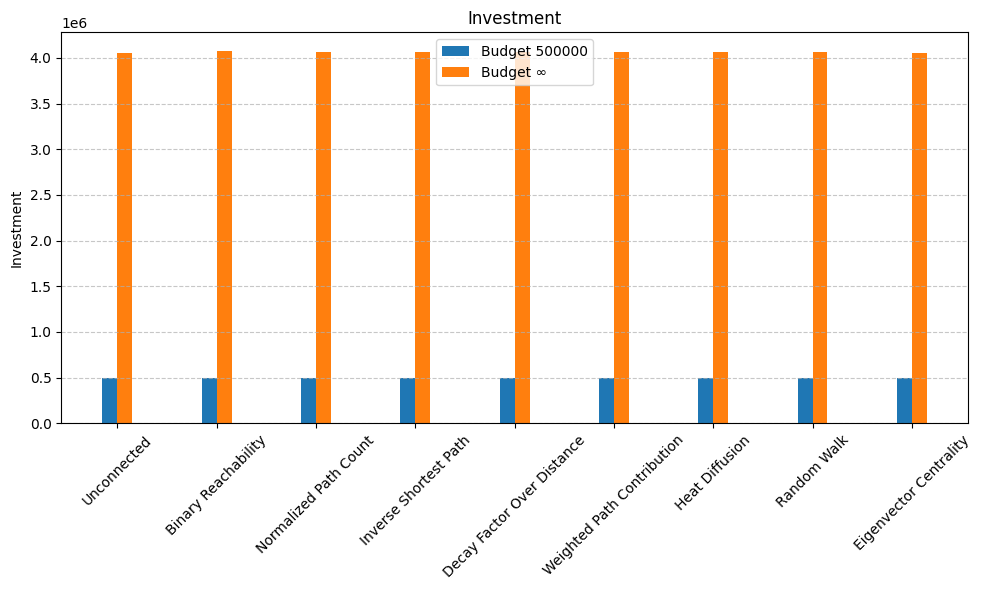

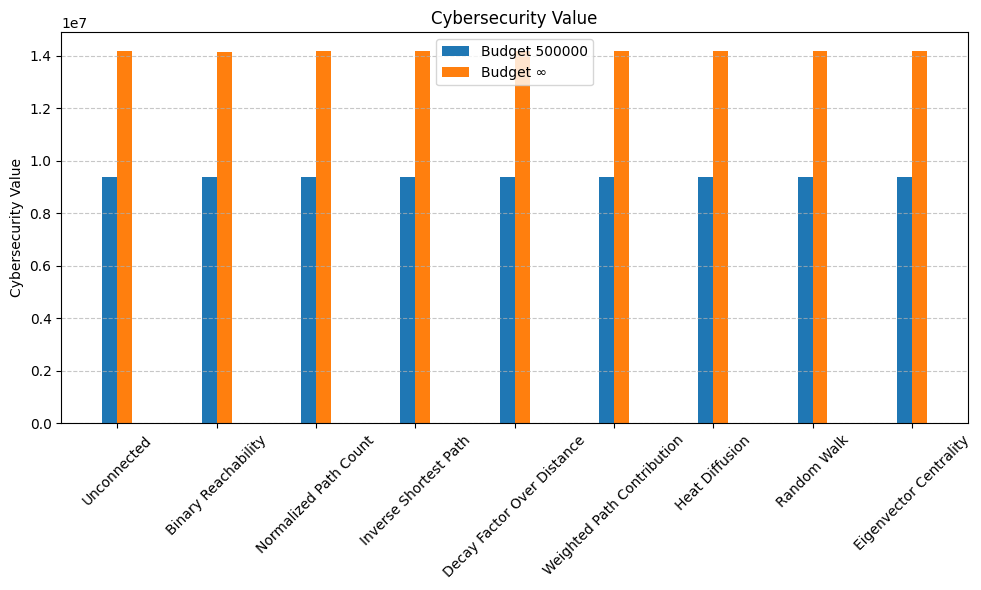

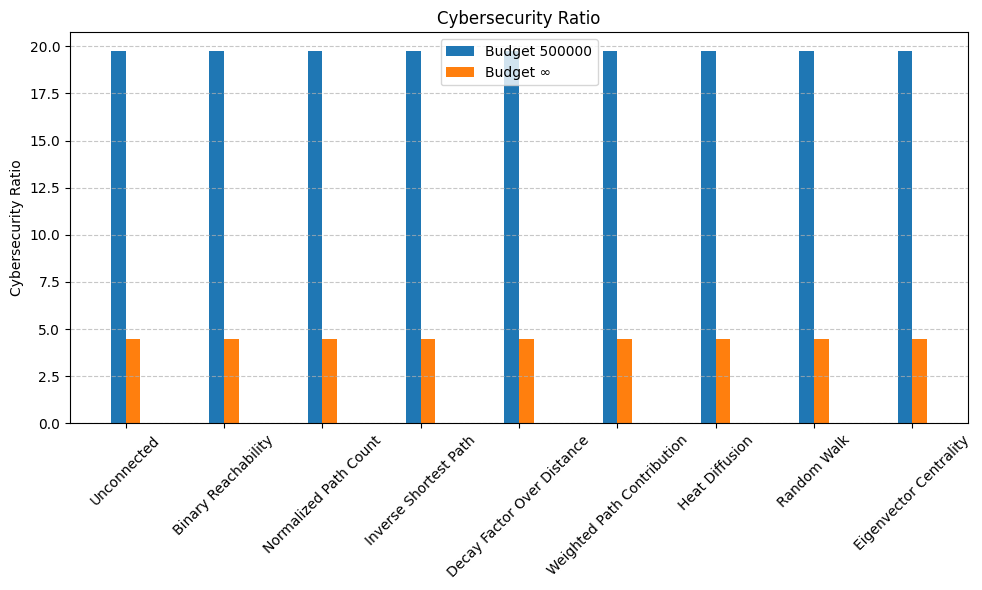

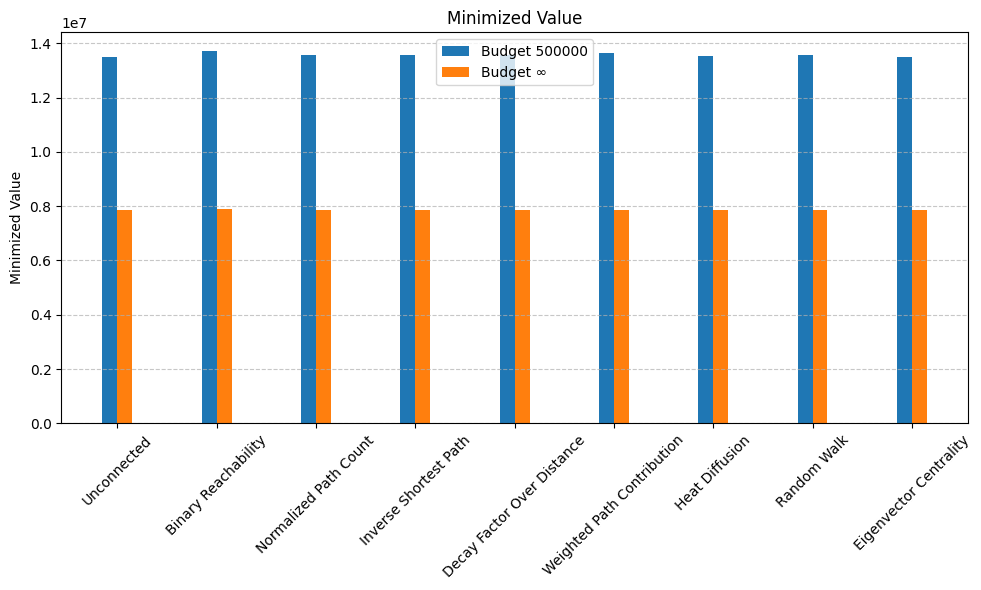

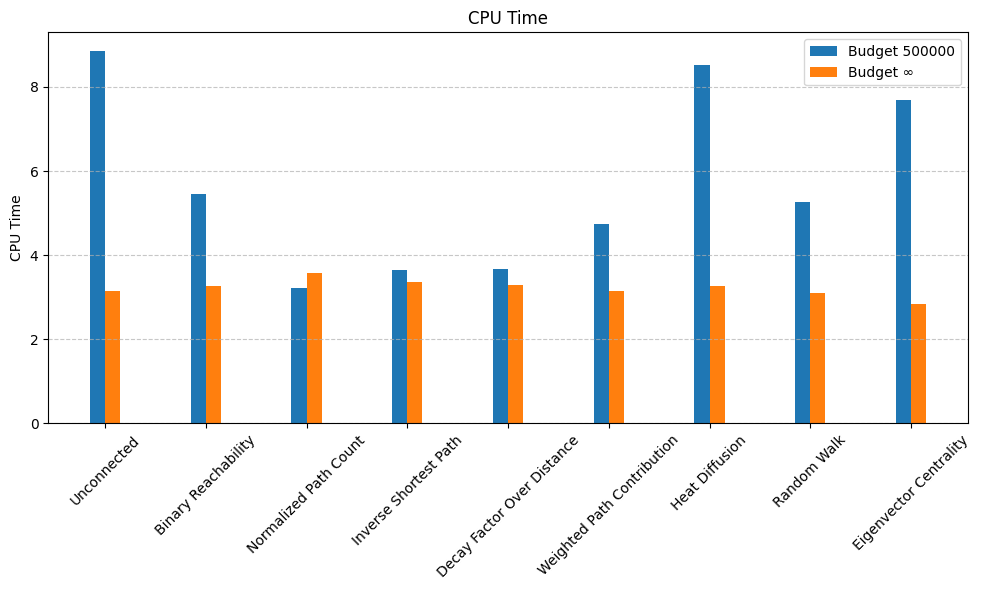

In [73]:
plot_results_cybsec_l(g_options, g_option_names, budgets, results, 20, 4)

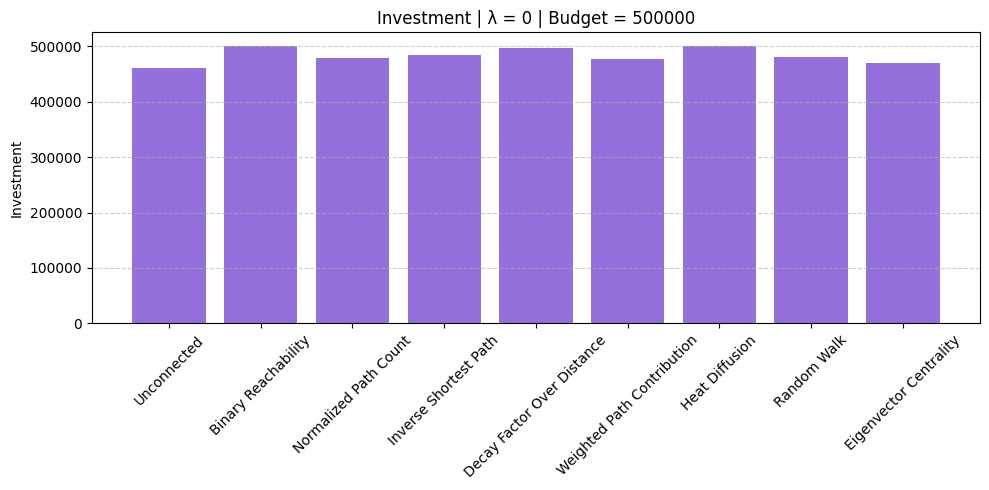

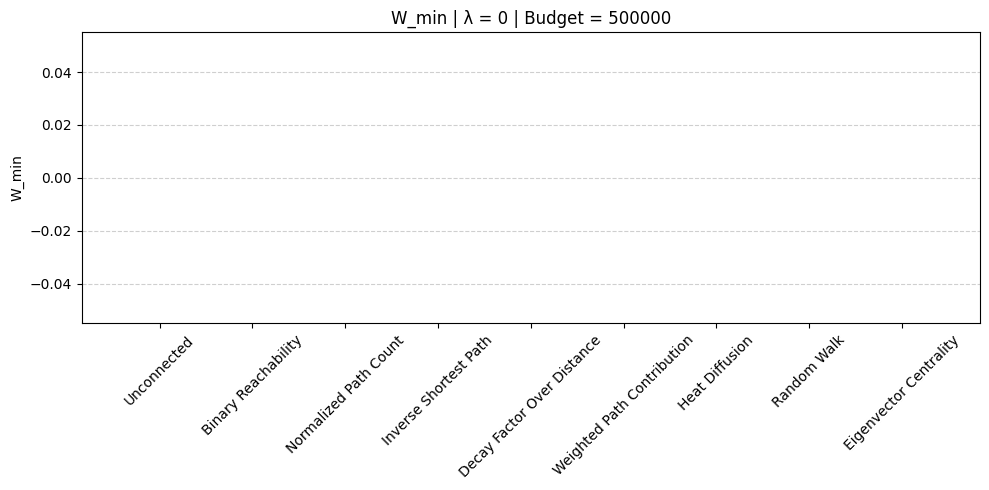

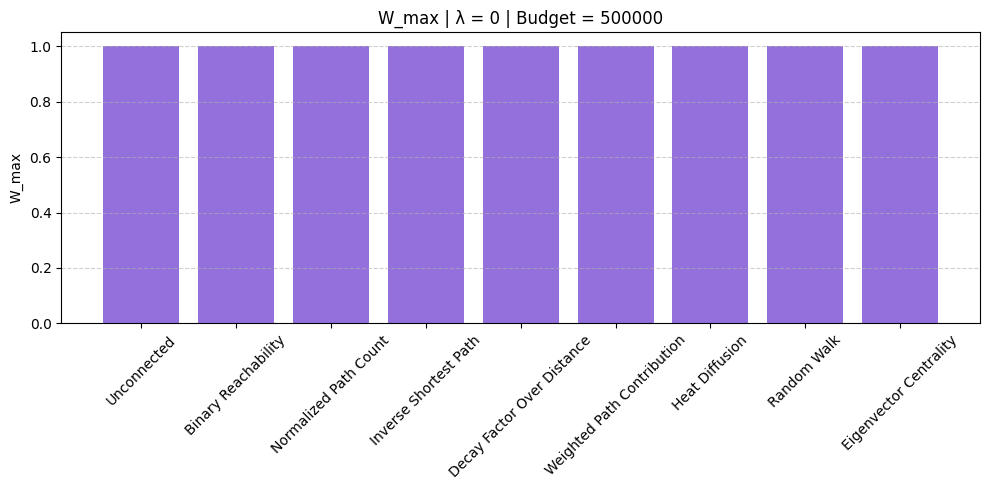

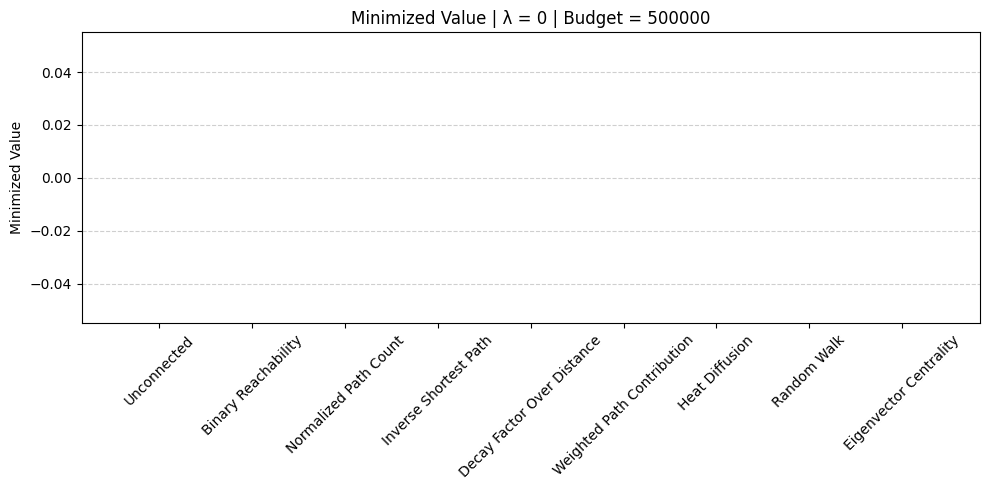

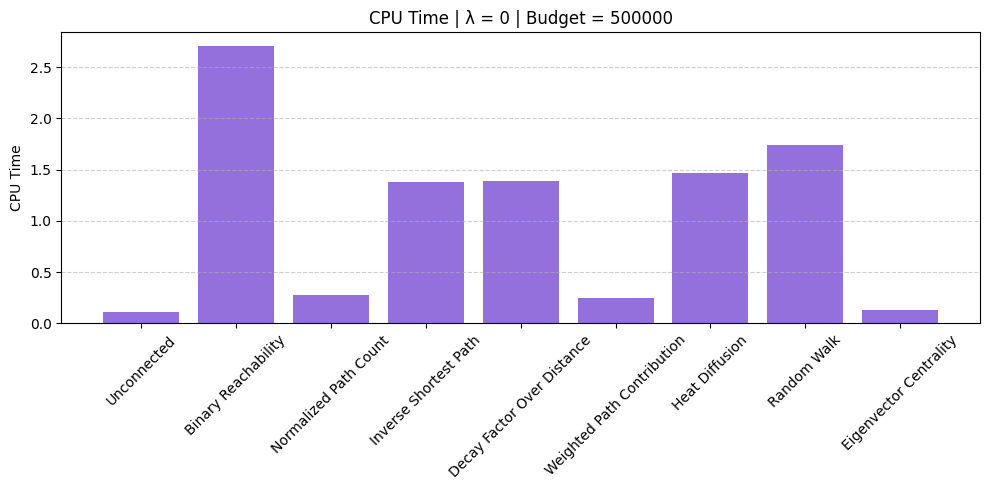

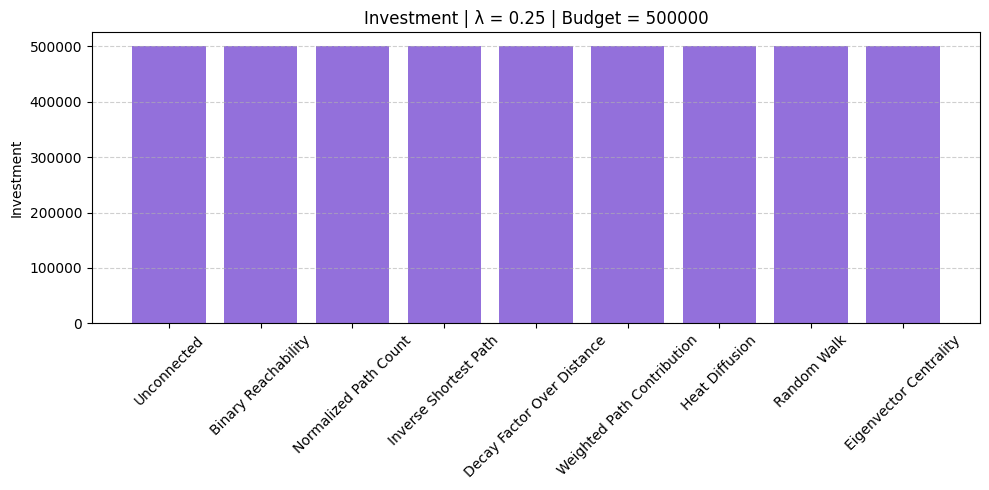

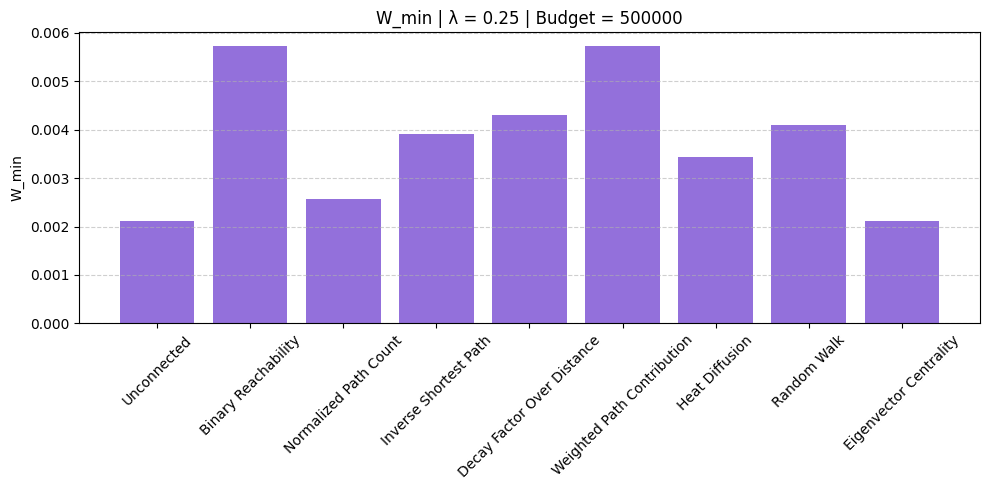

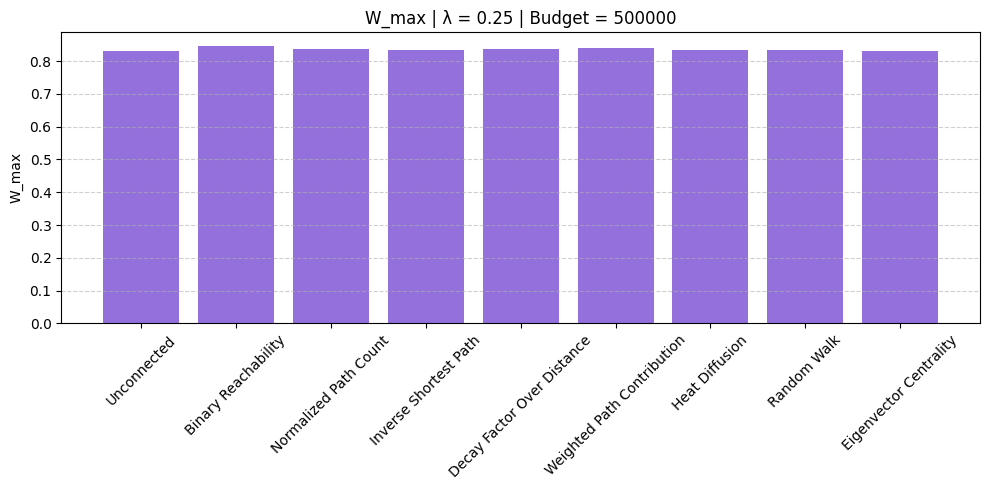

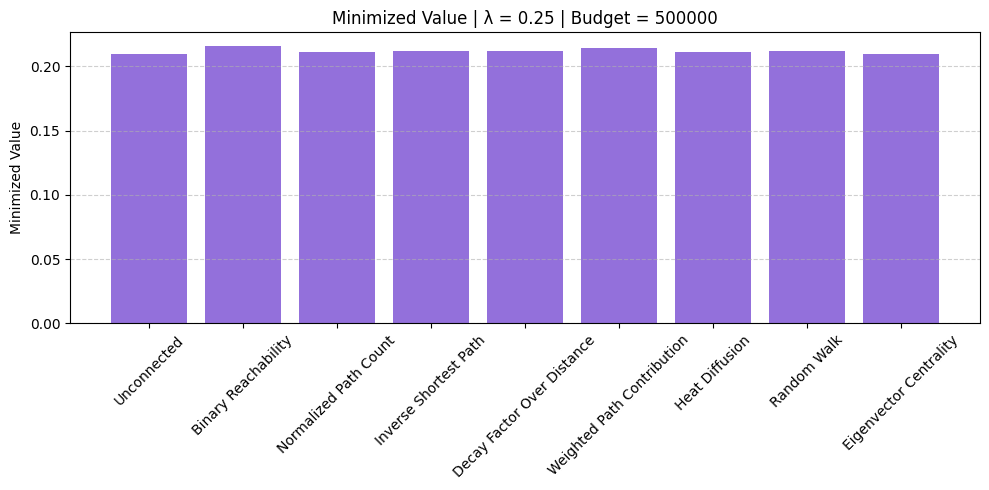

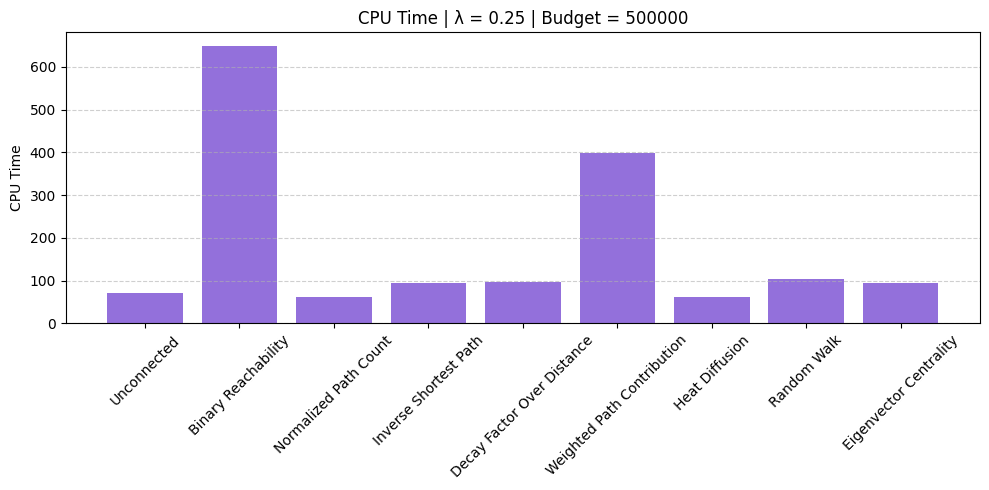

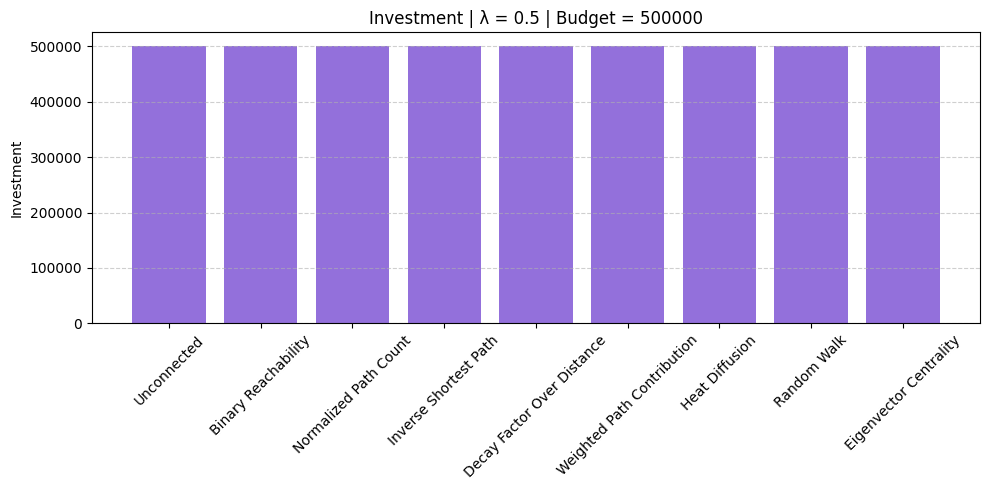

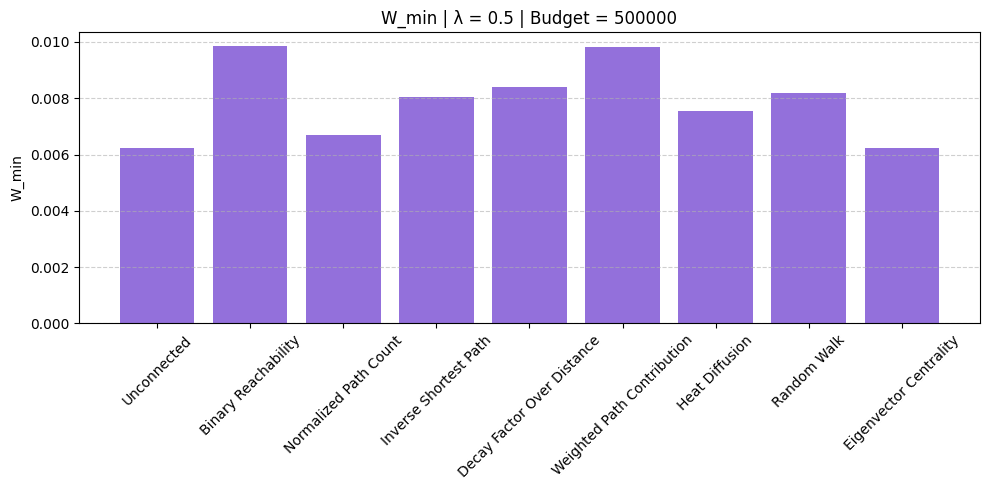

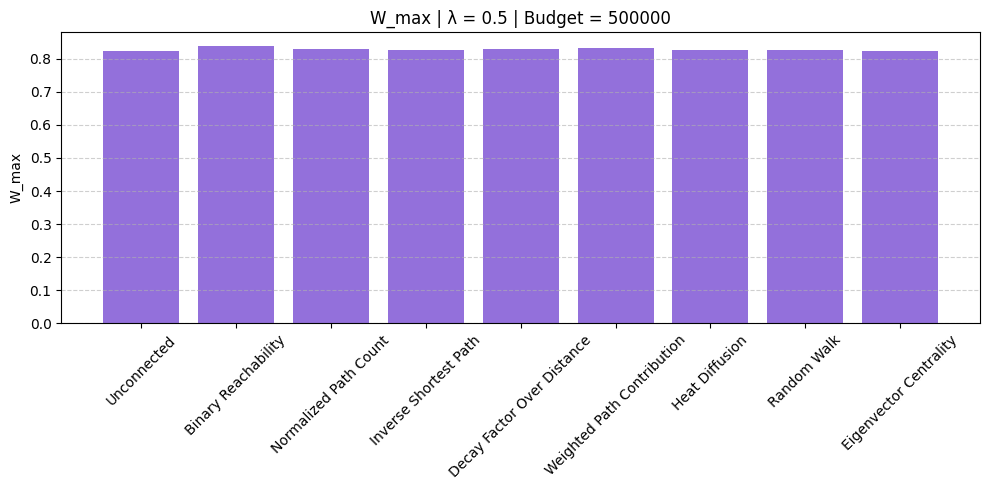

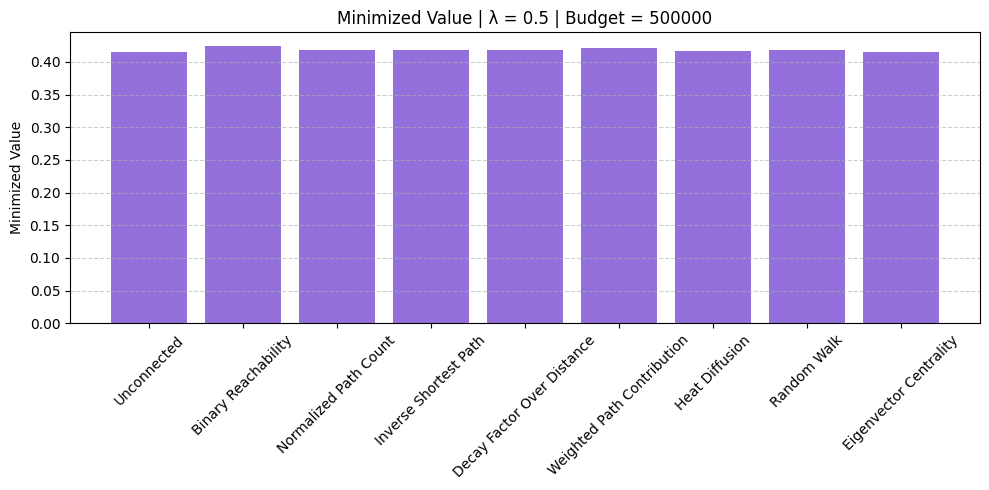

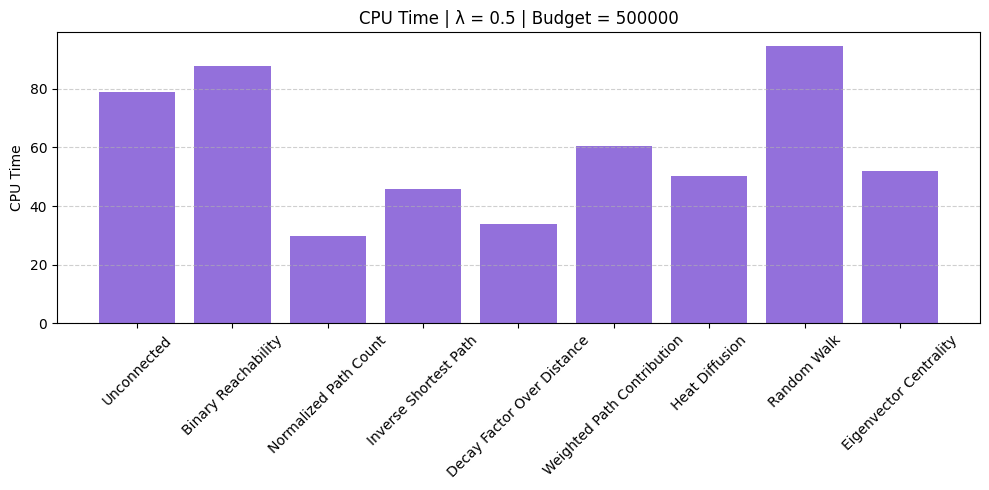

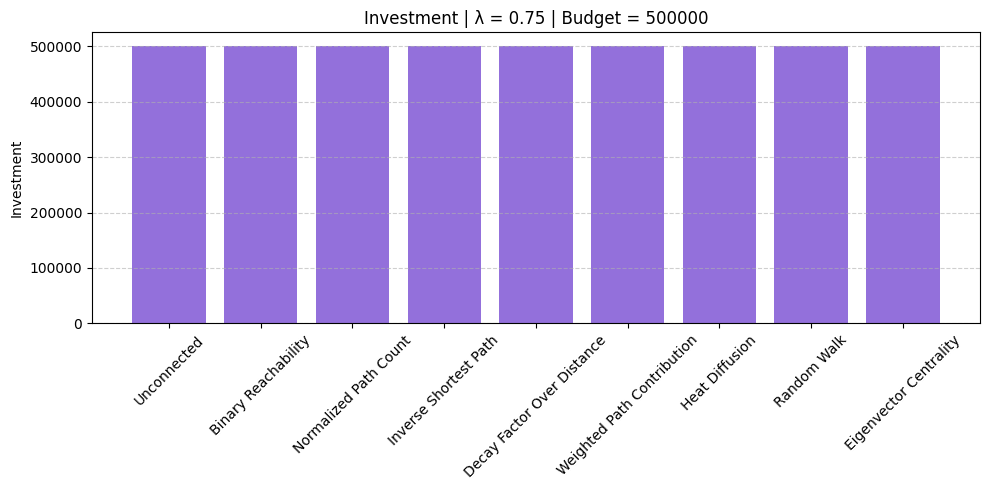

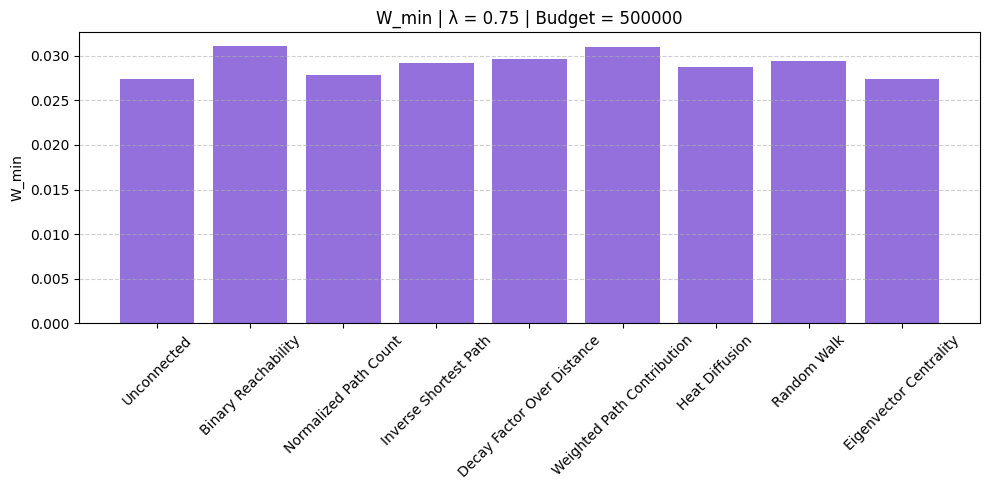

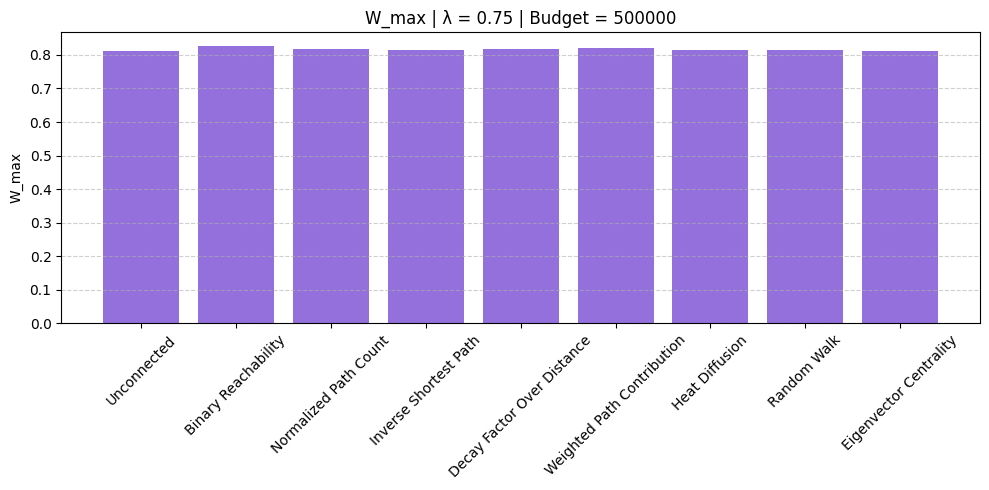

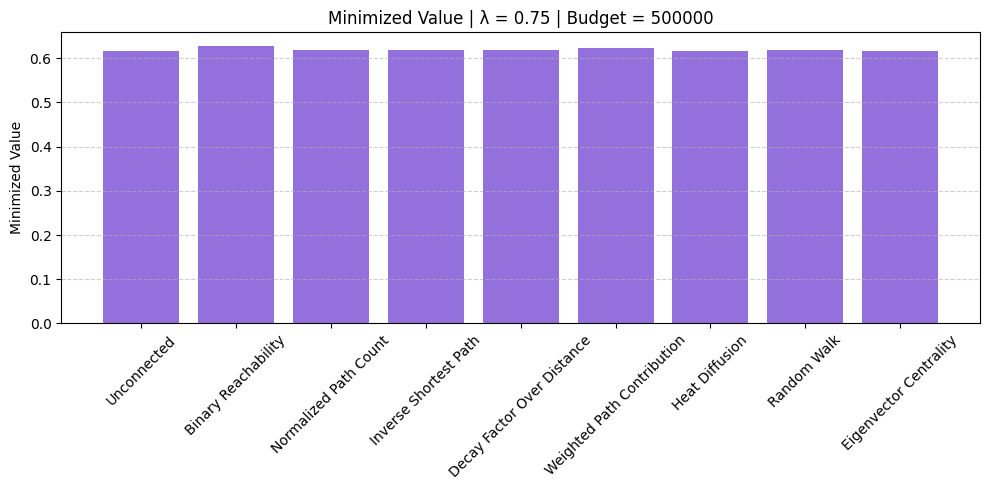

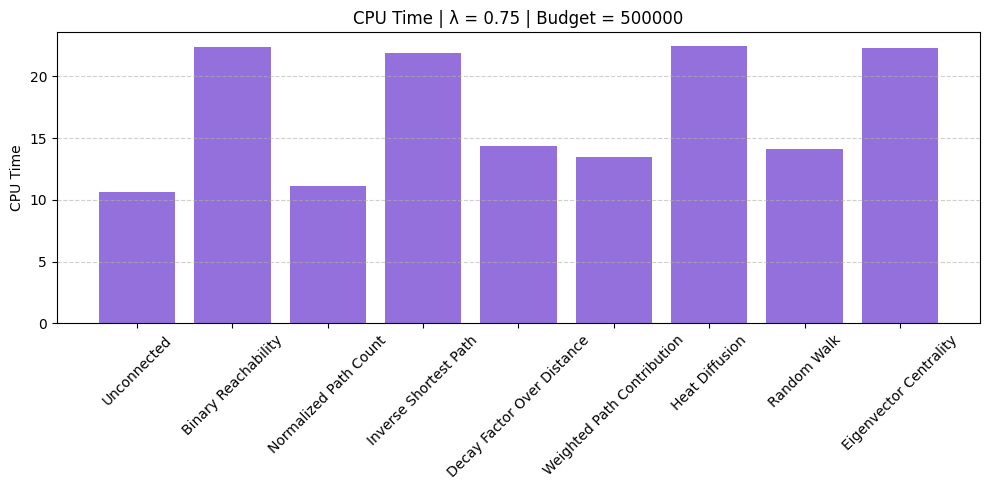

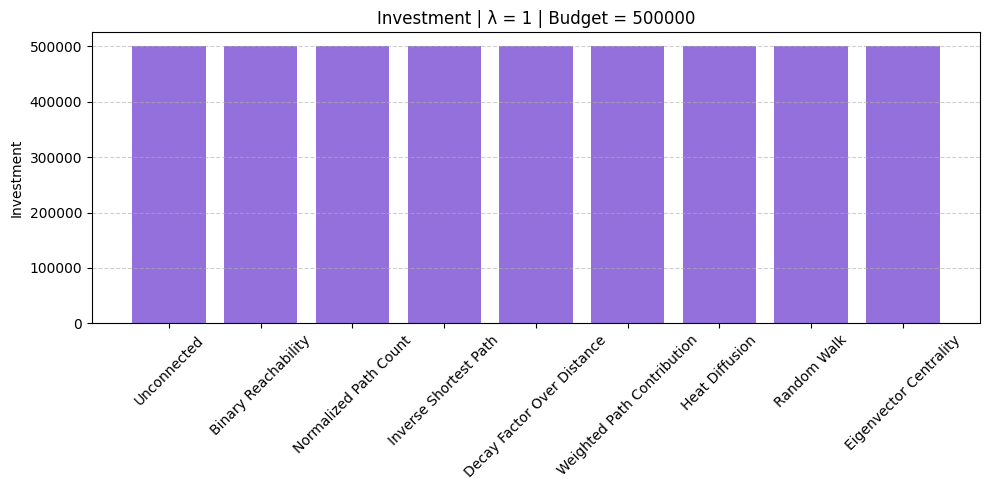

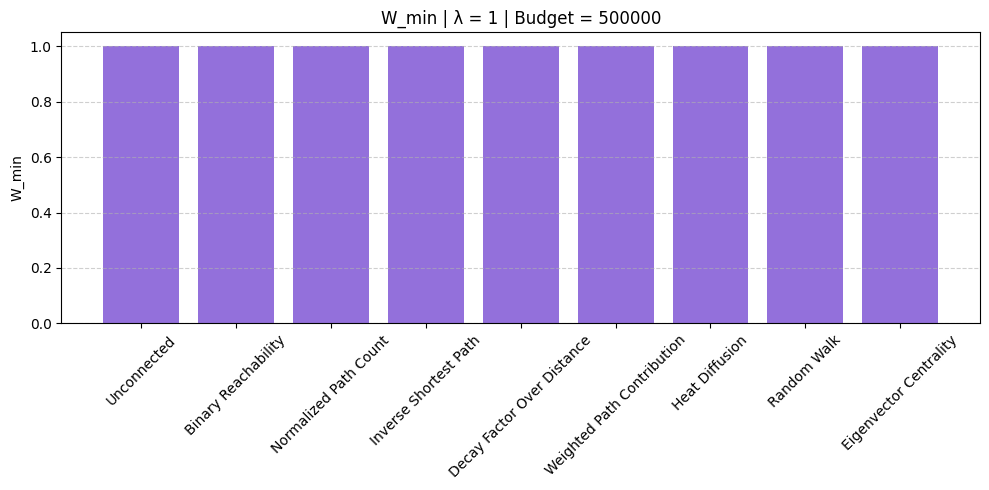

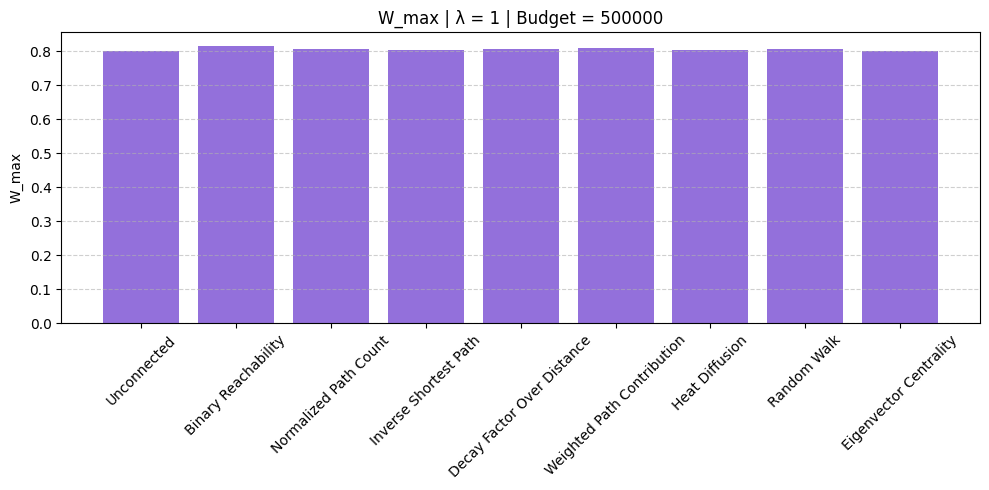

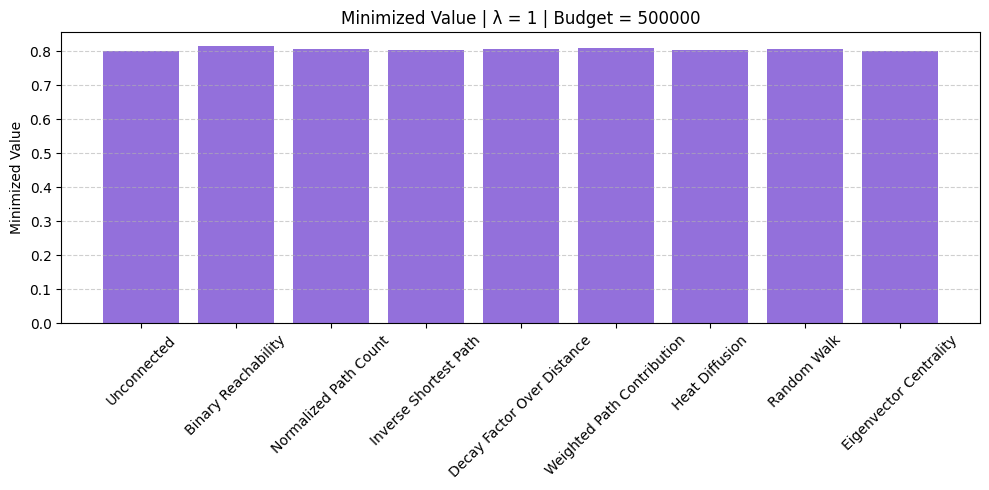

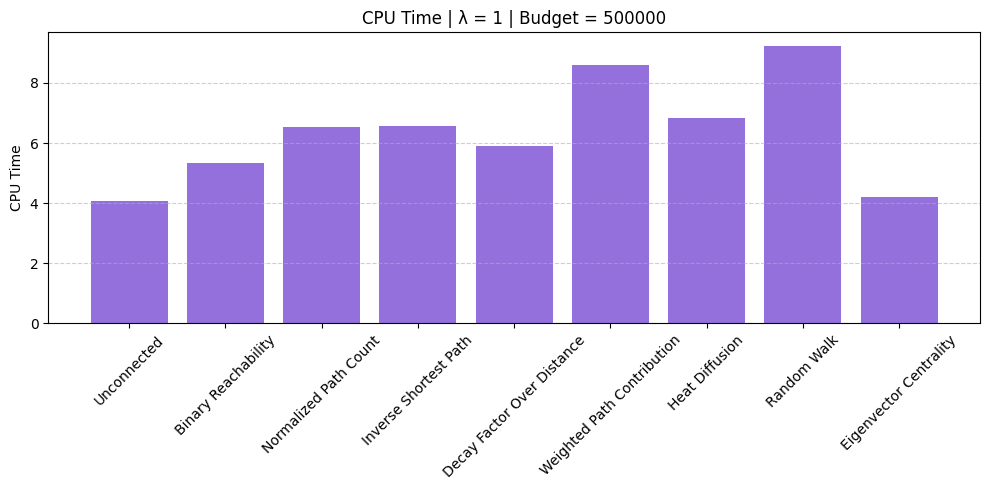

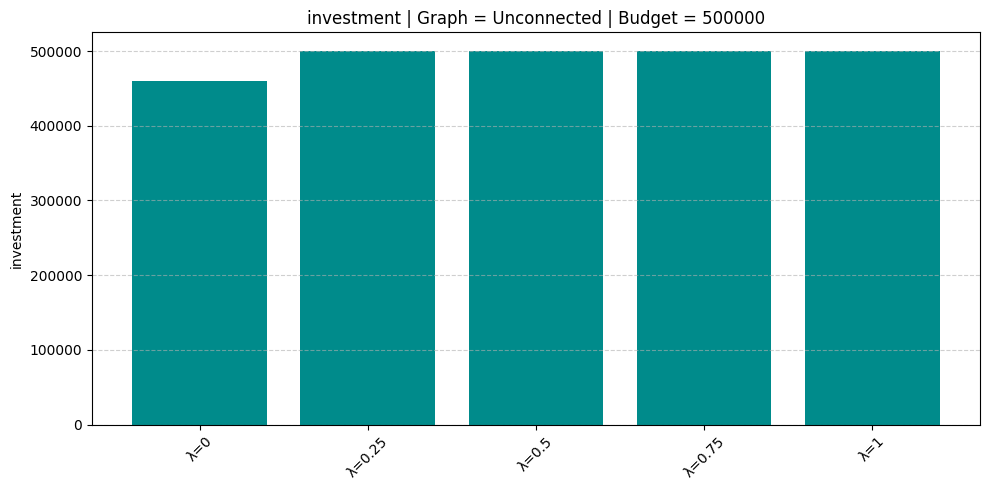

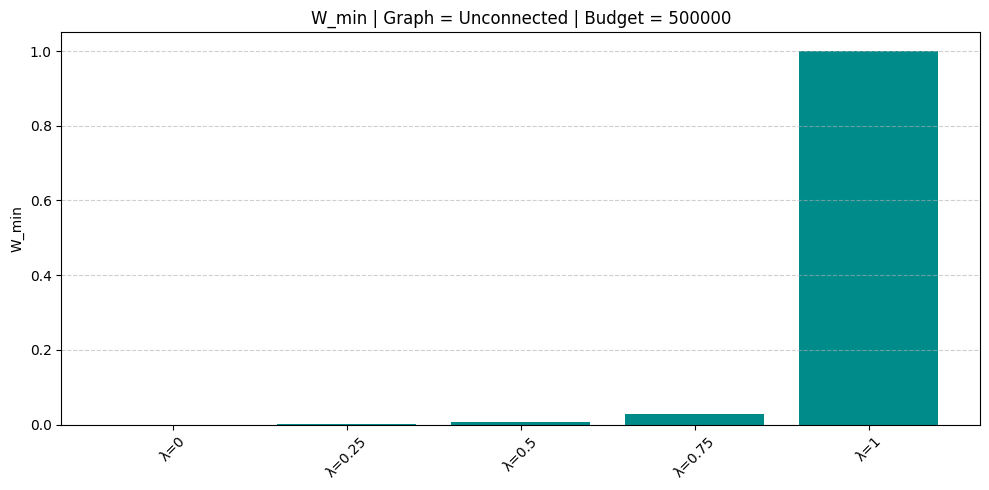

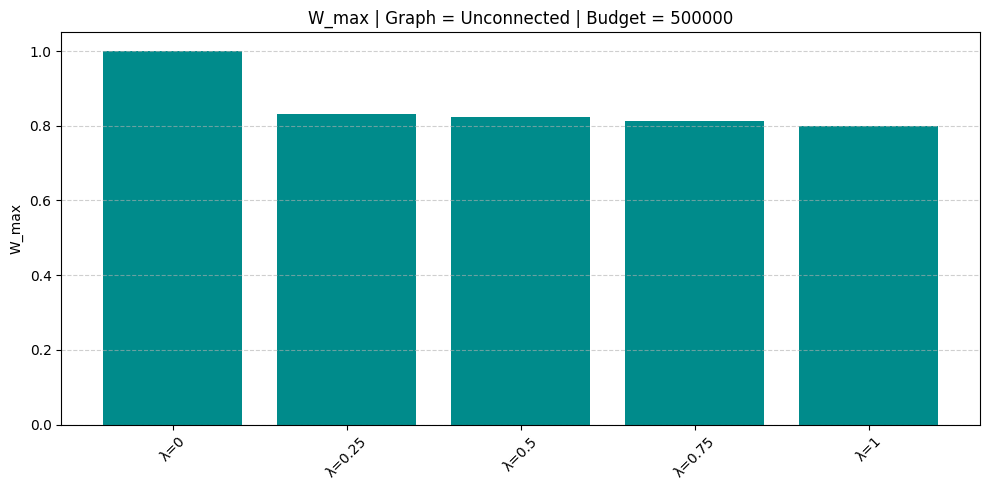

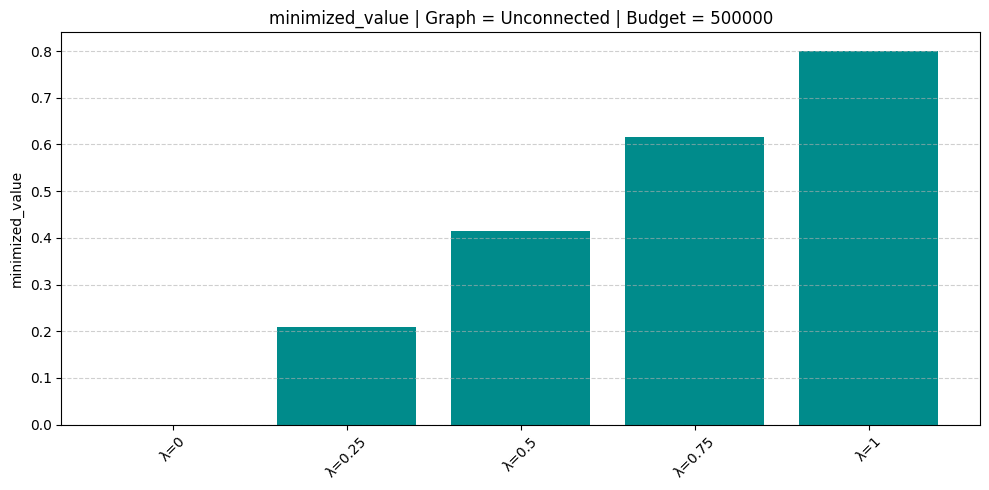

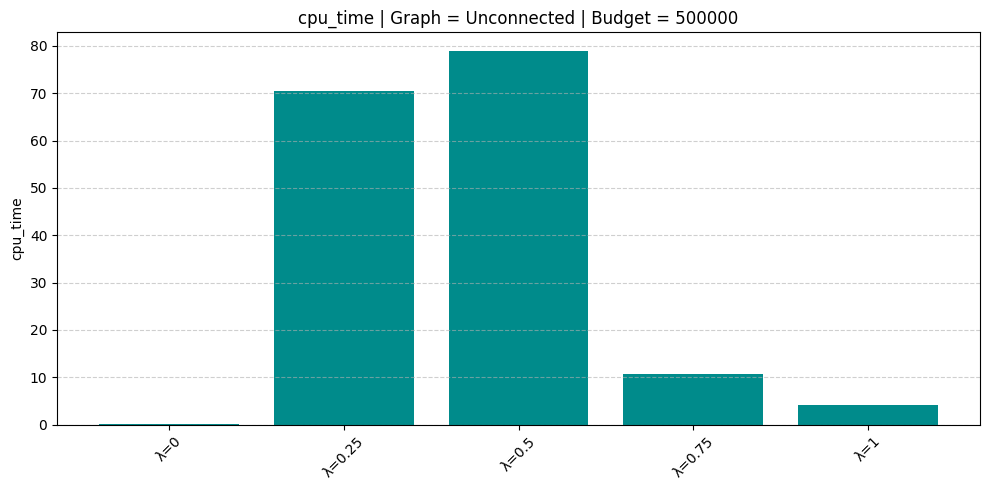

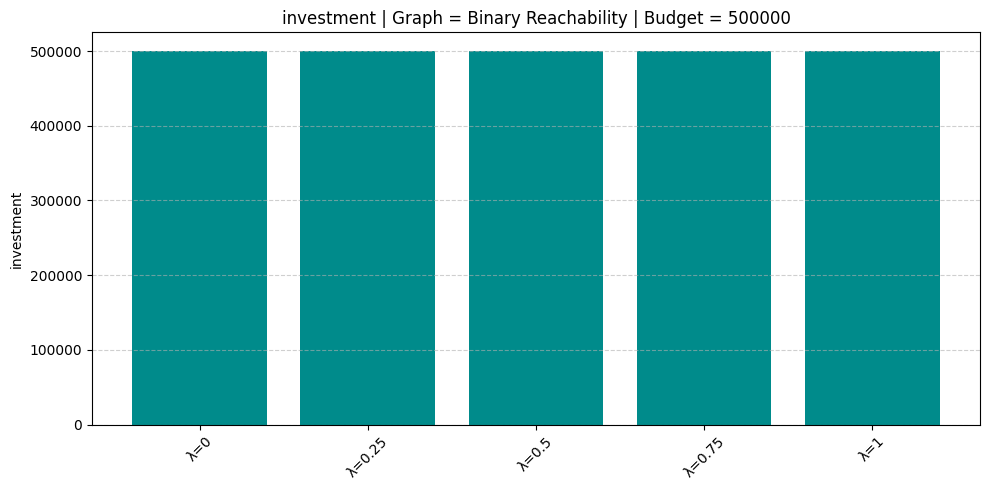

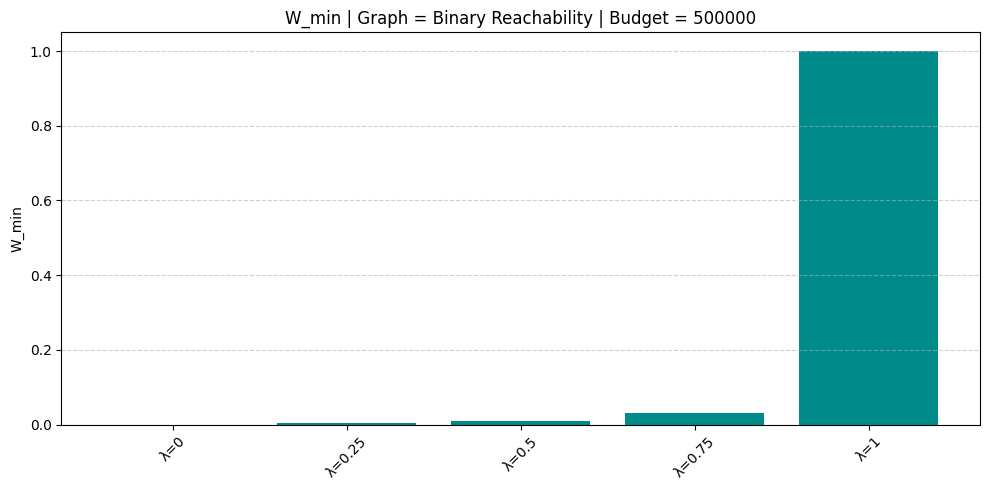

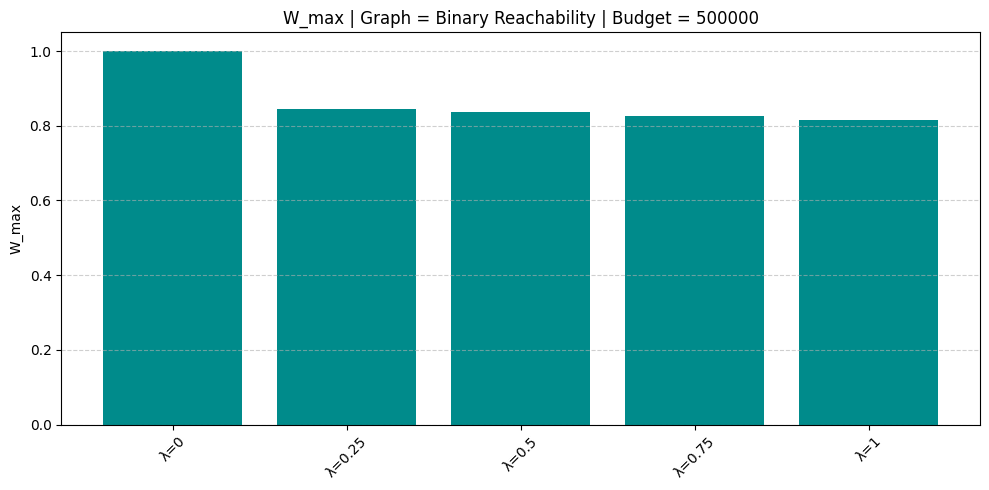

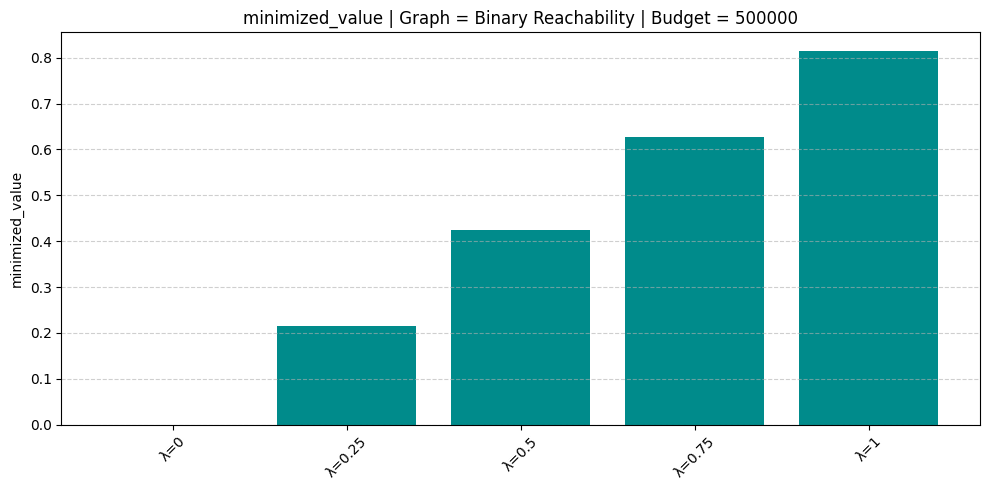

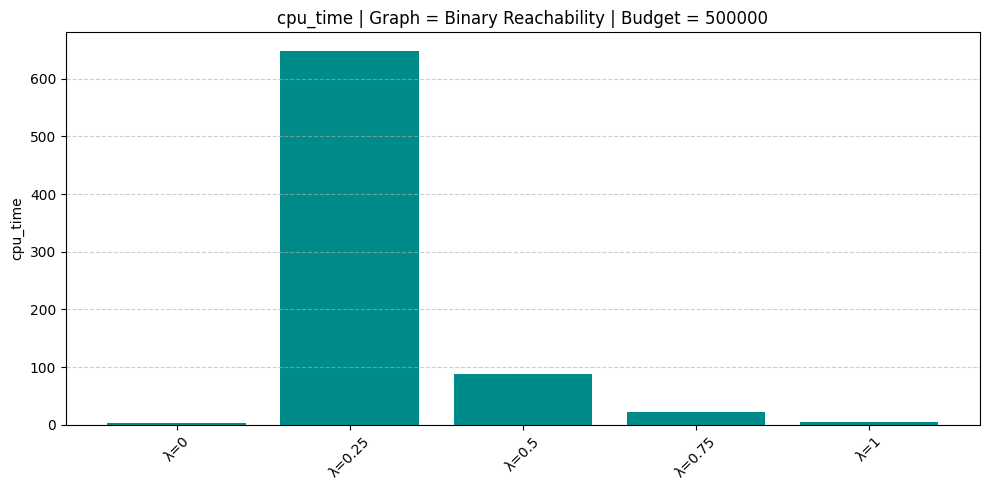

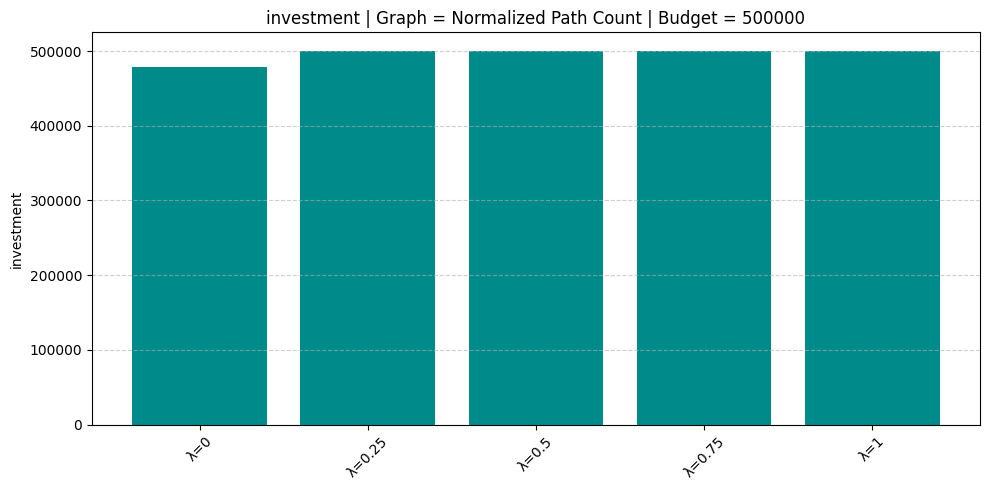

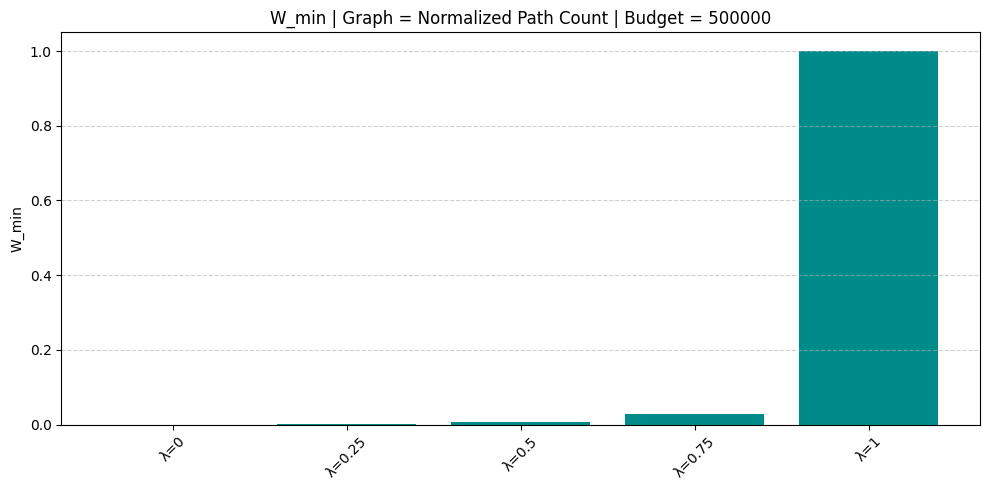

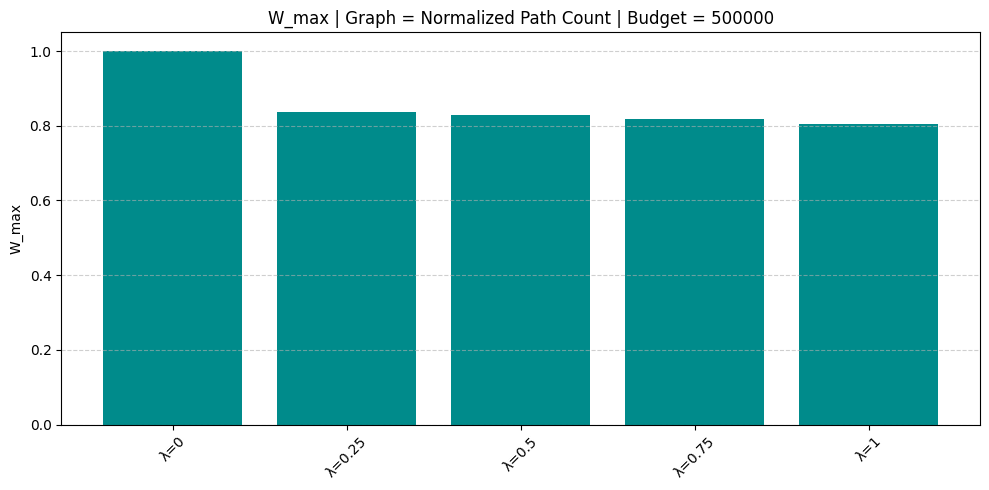

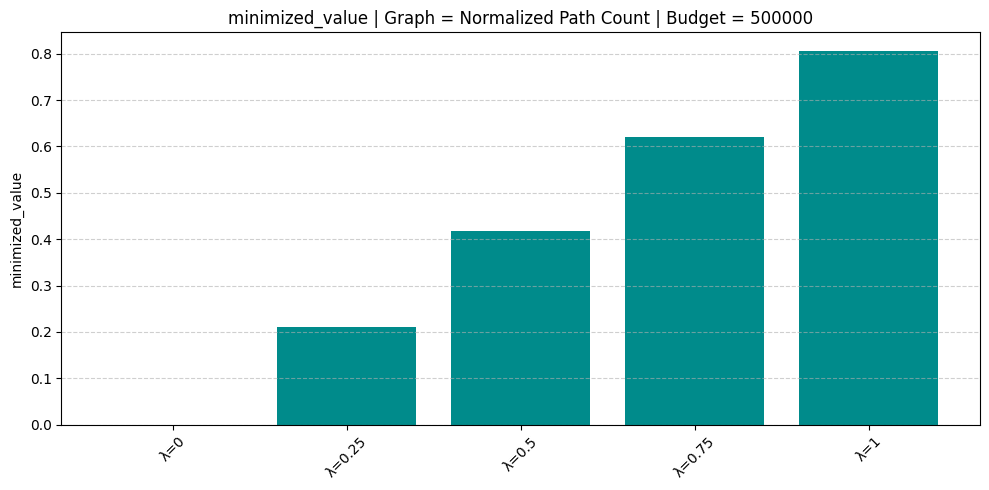

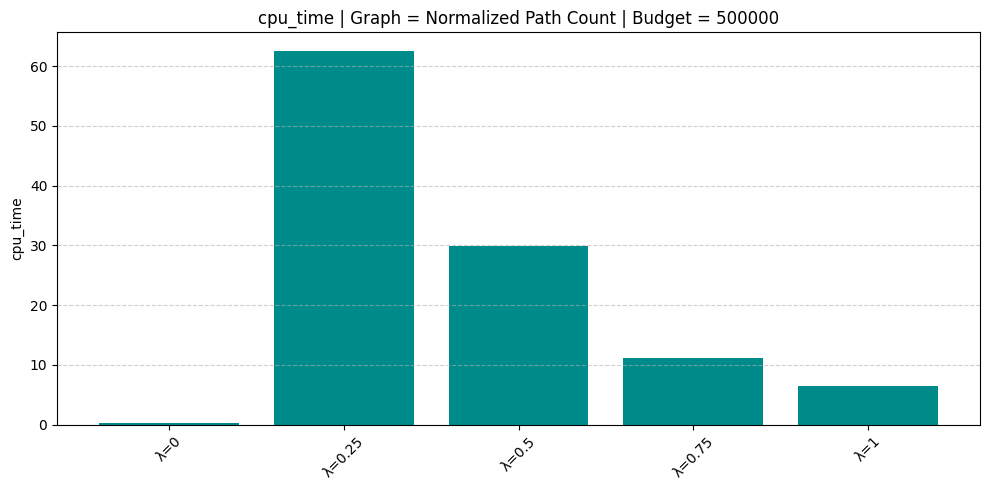

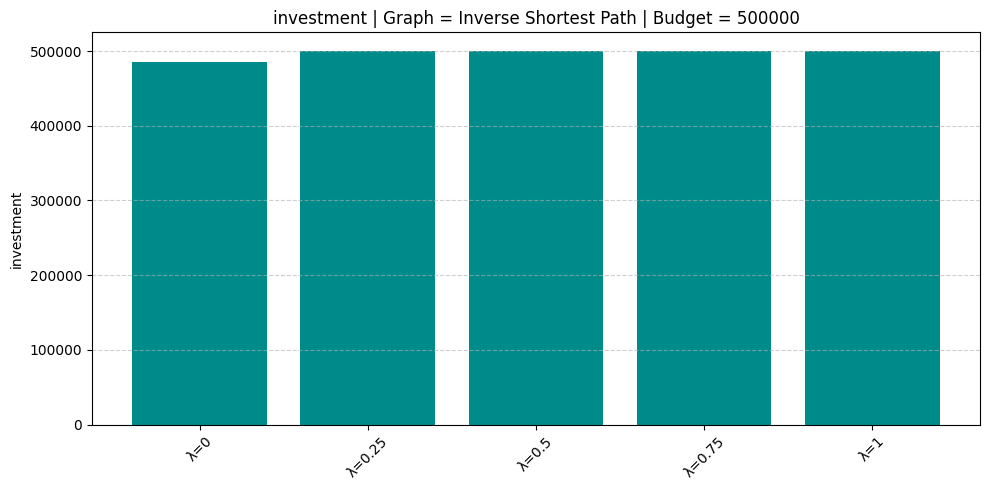

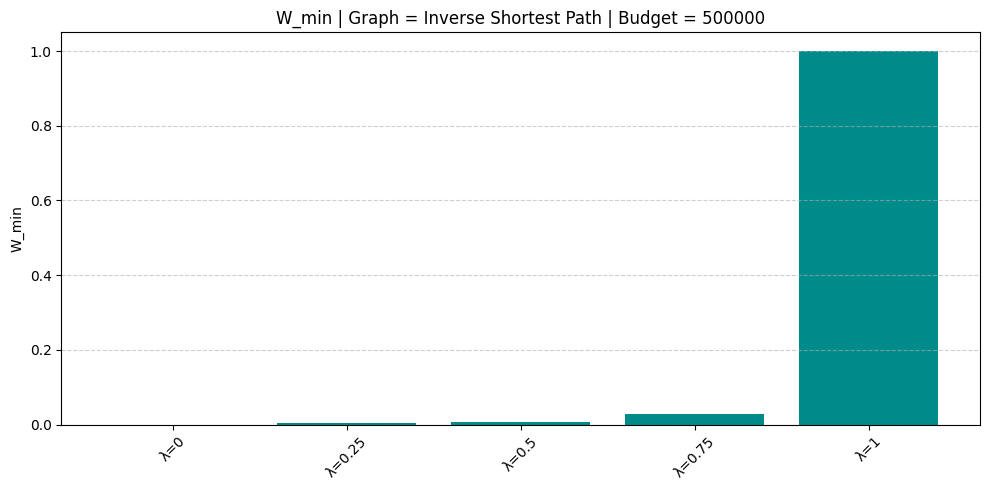

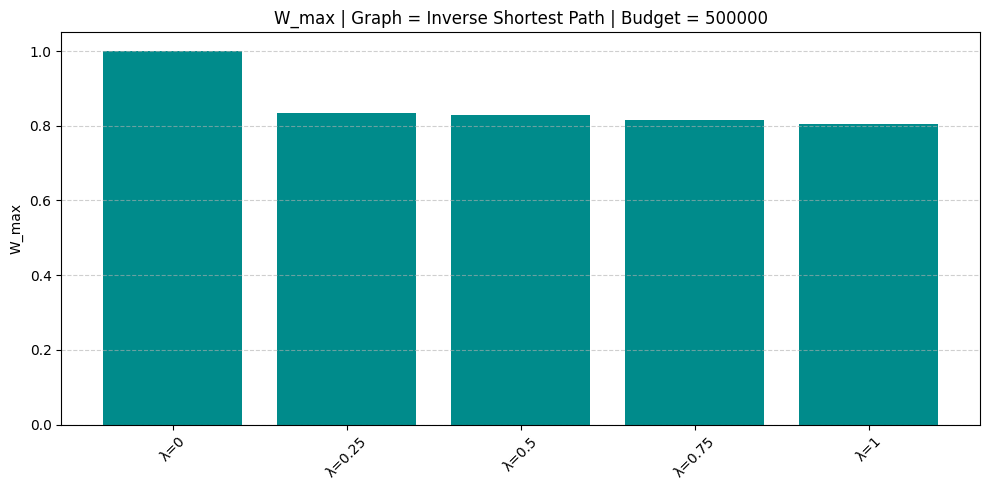

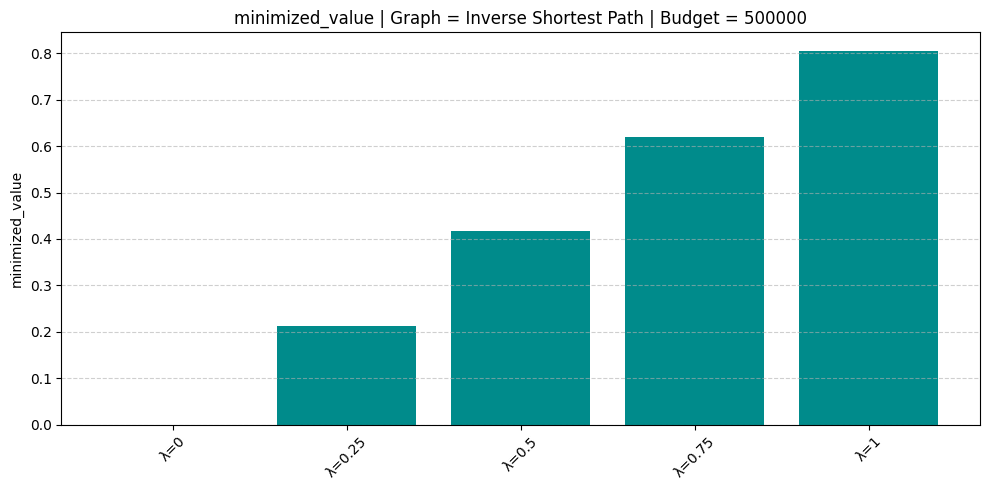

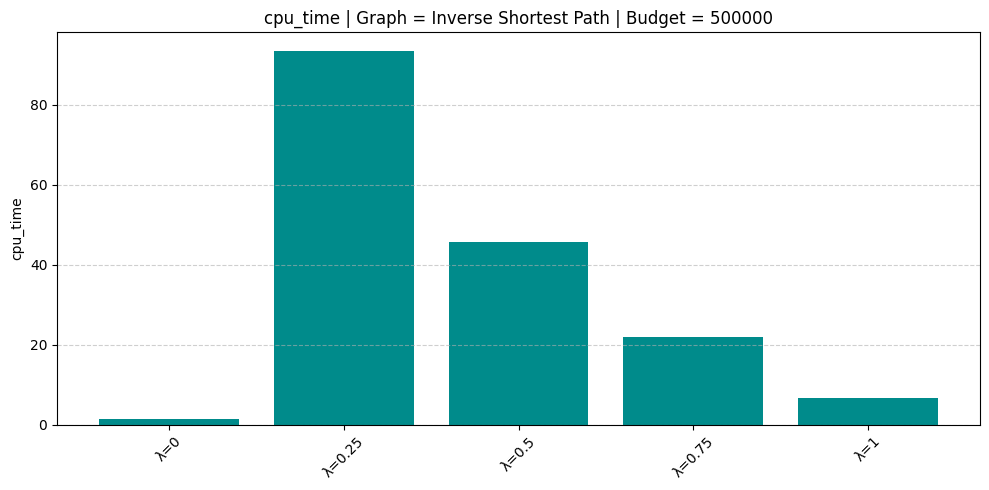

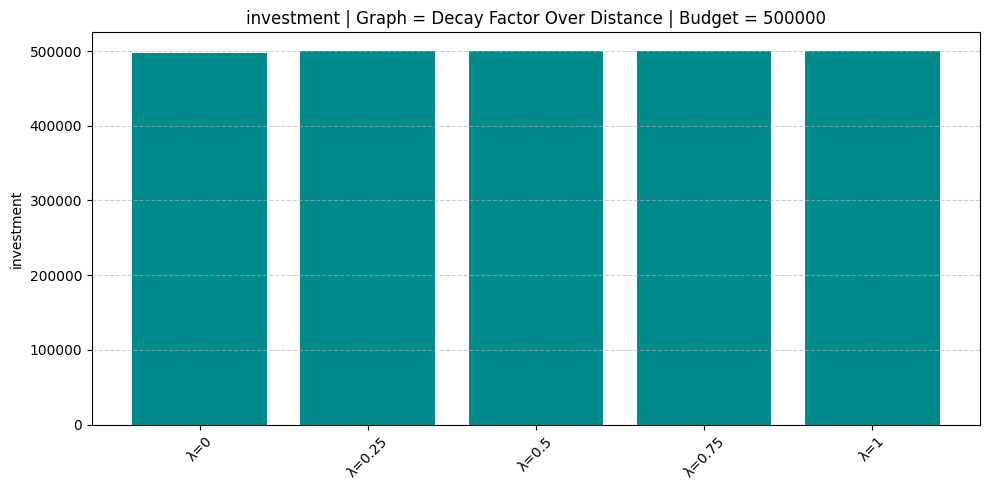

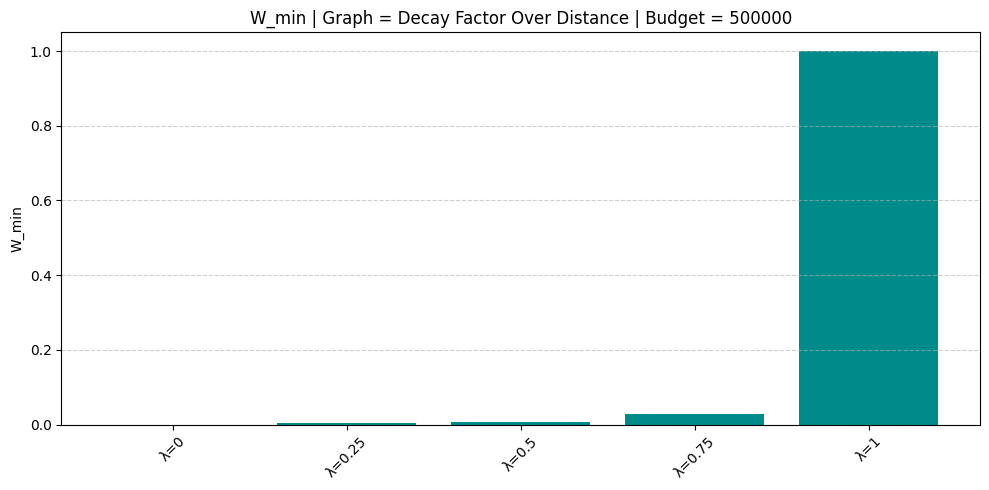

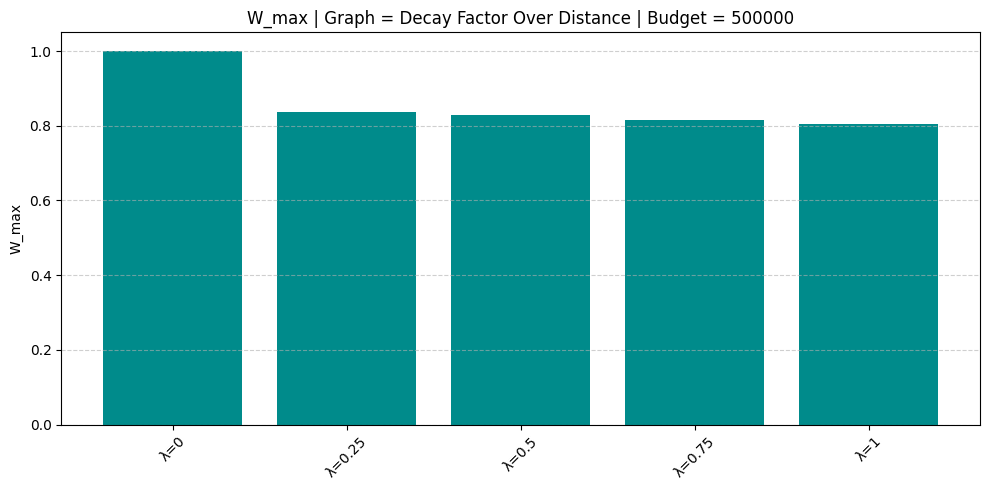

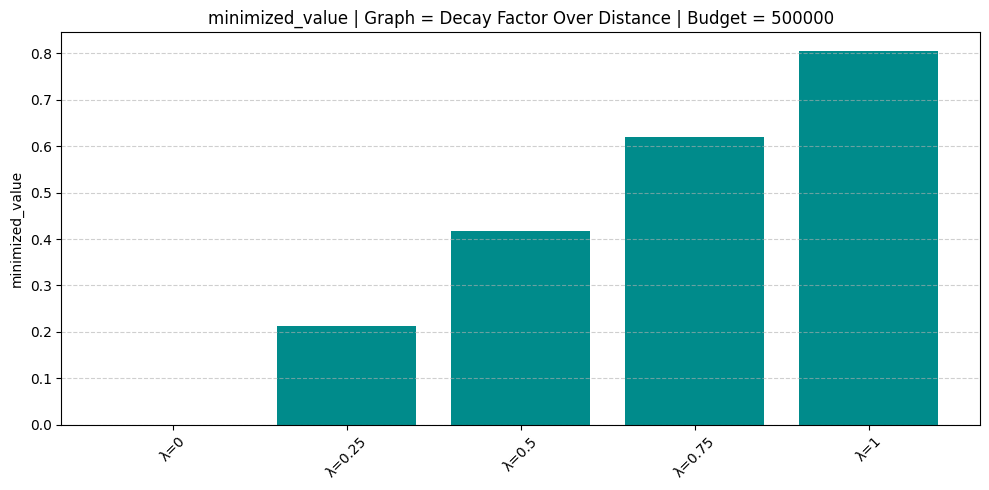

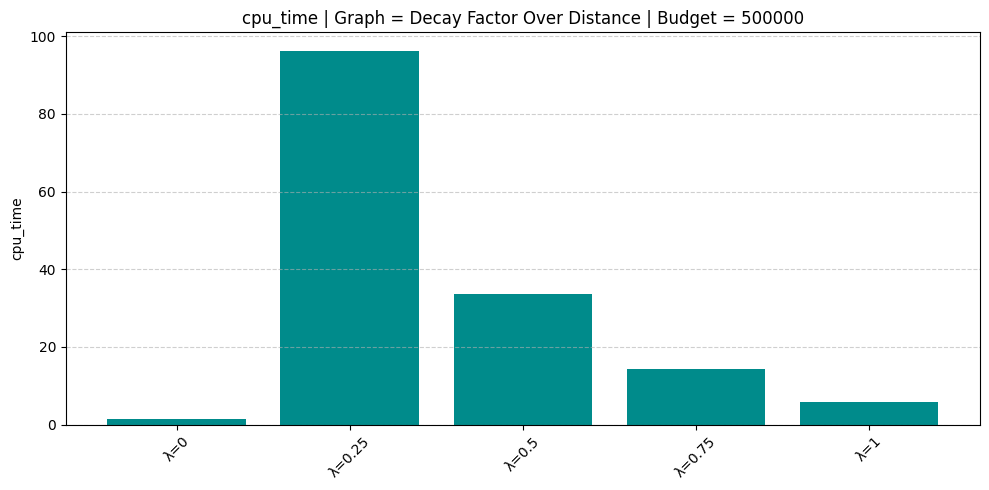

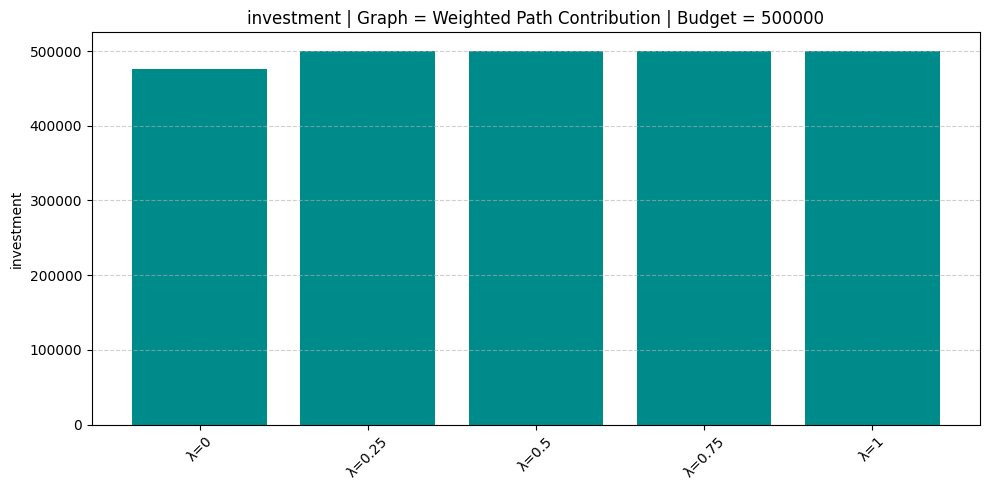

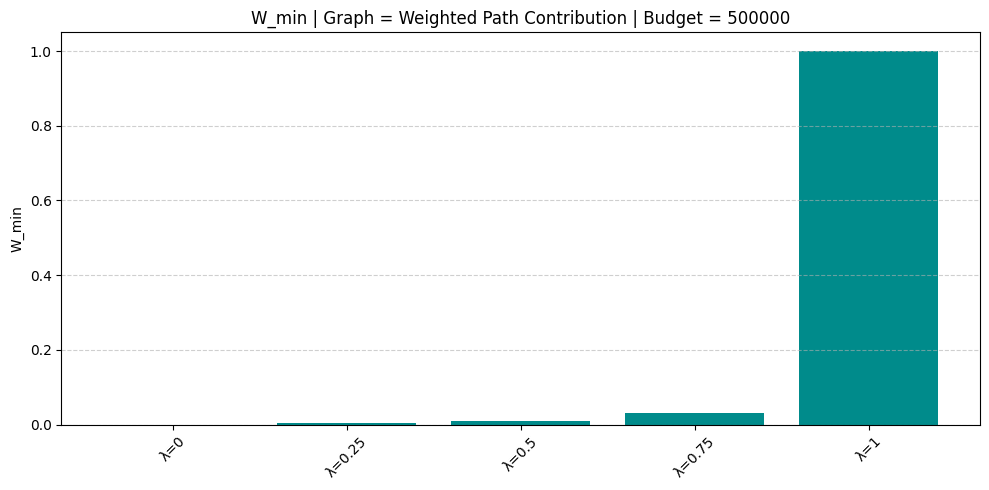

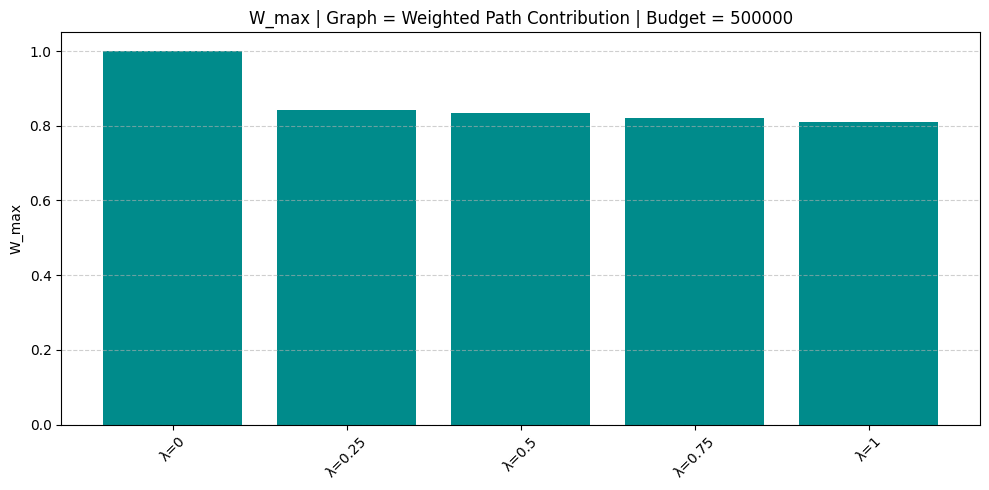

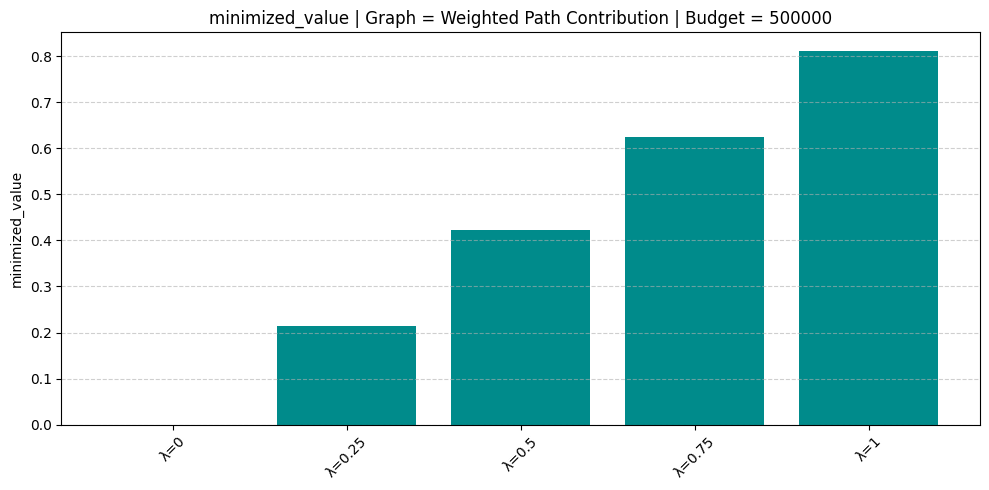

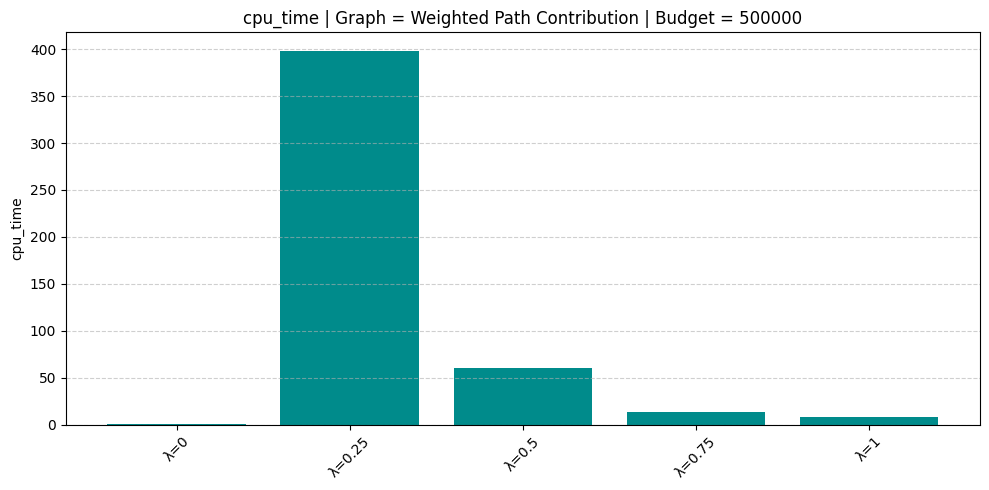

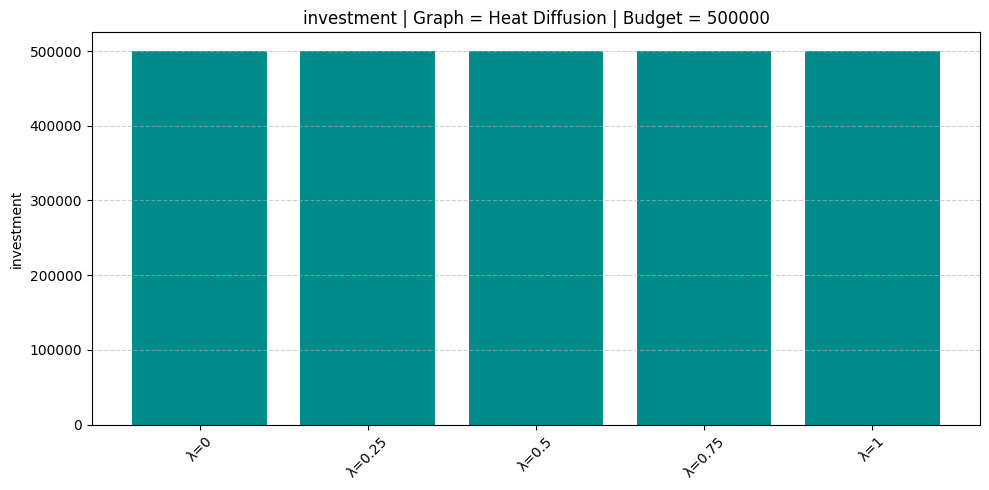

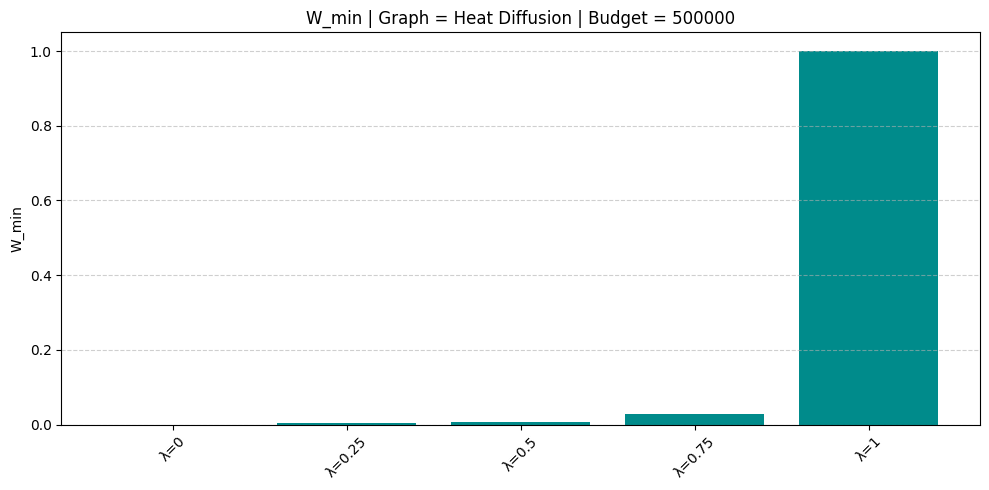

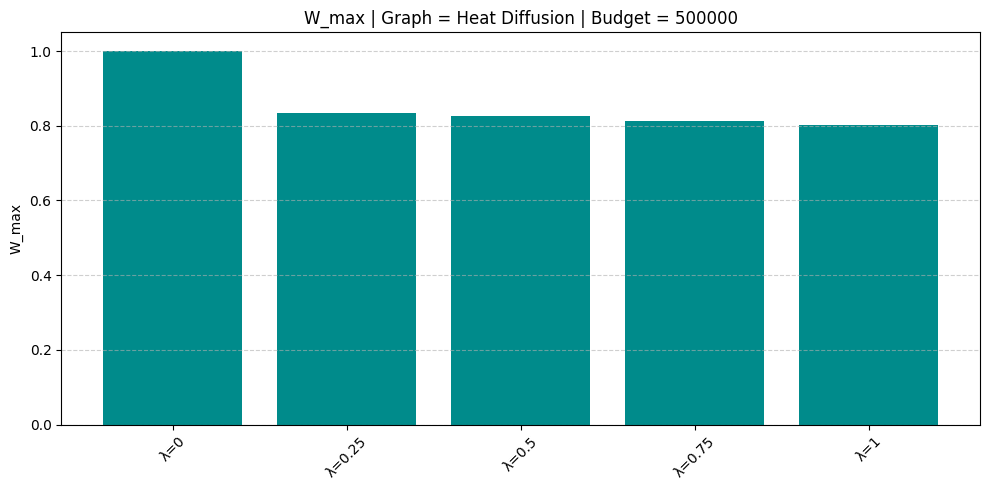

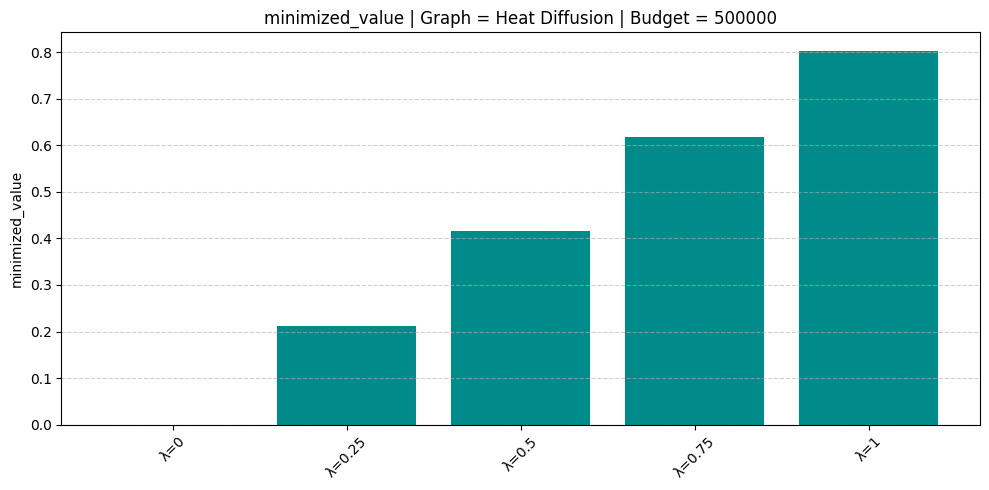

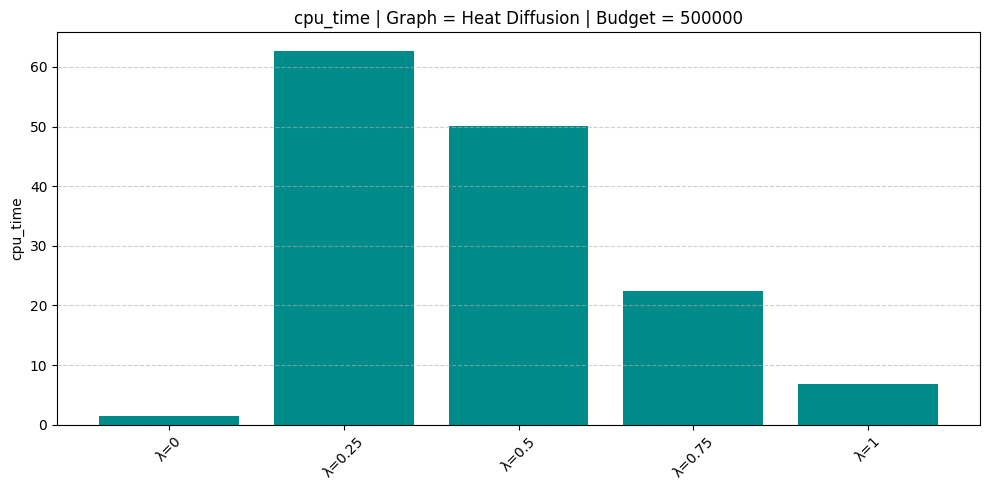

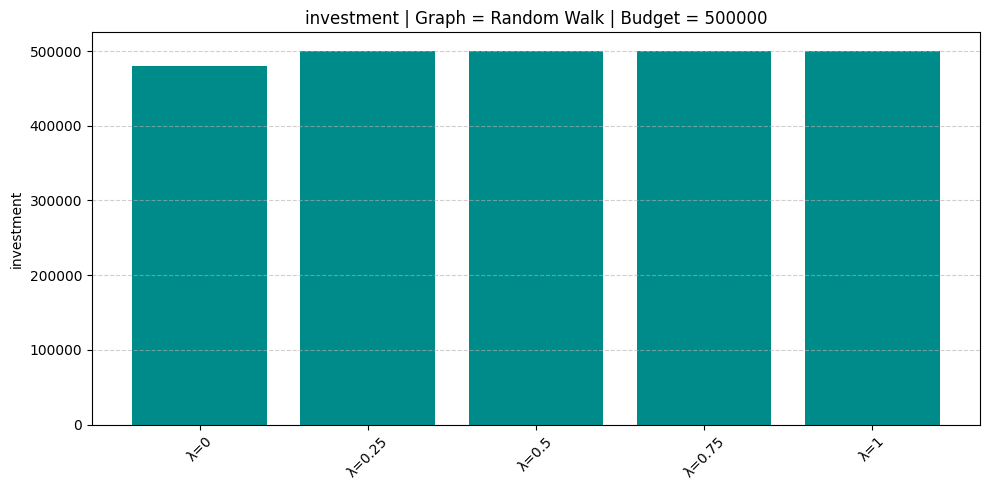

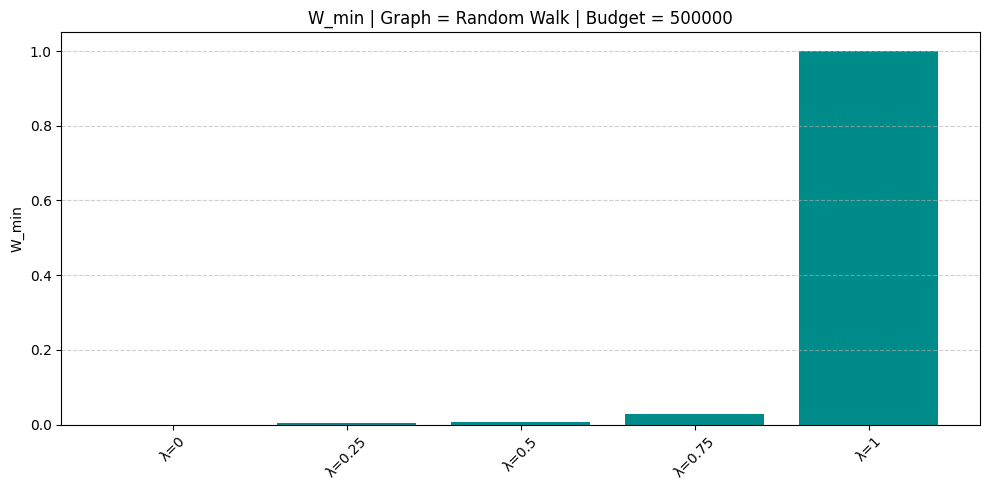

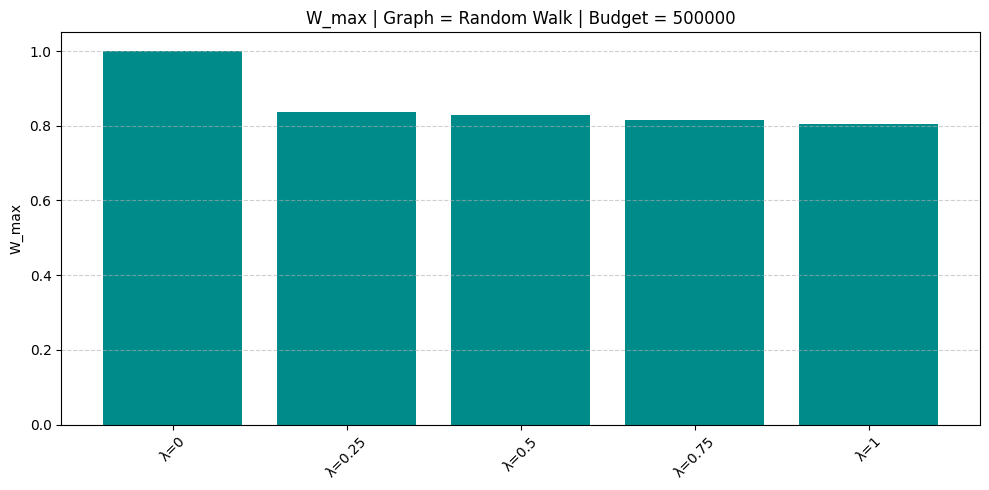

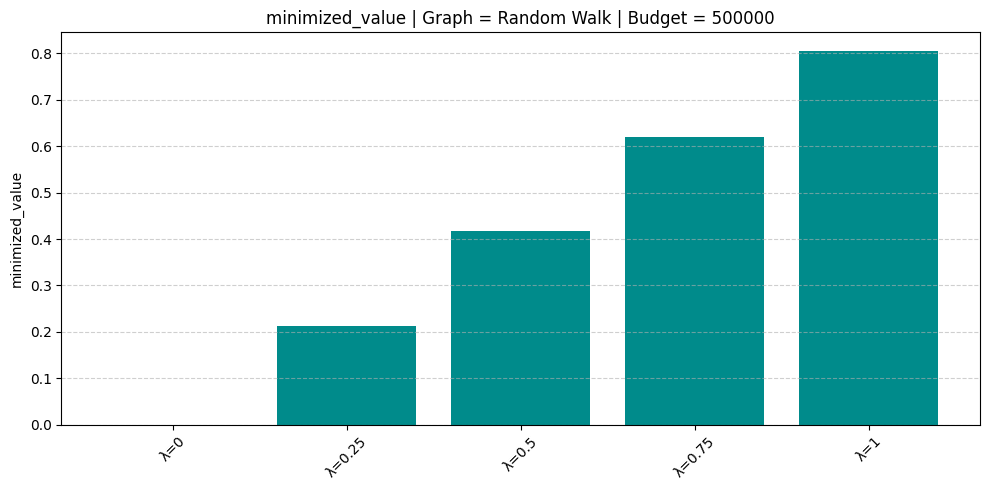

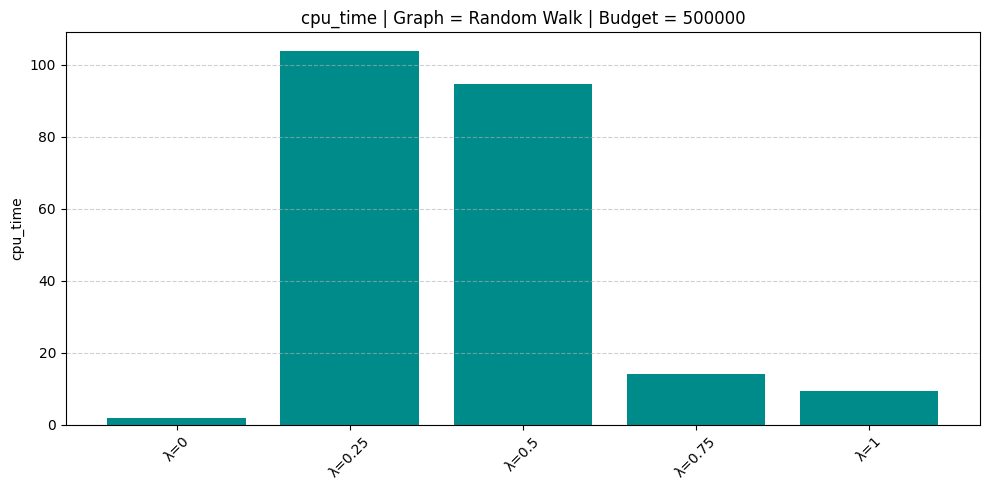

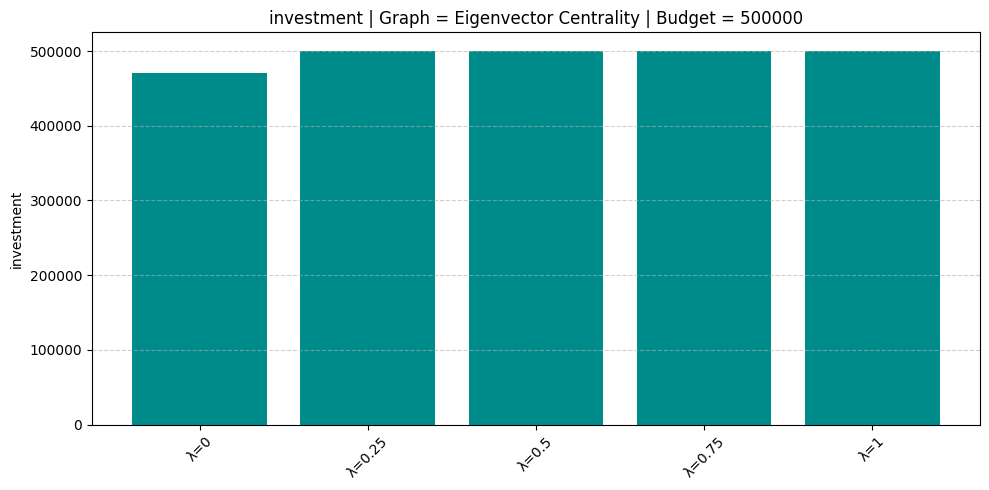

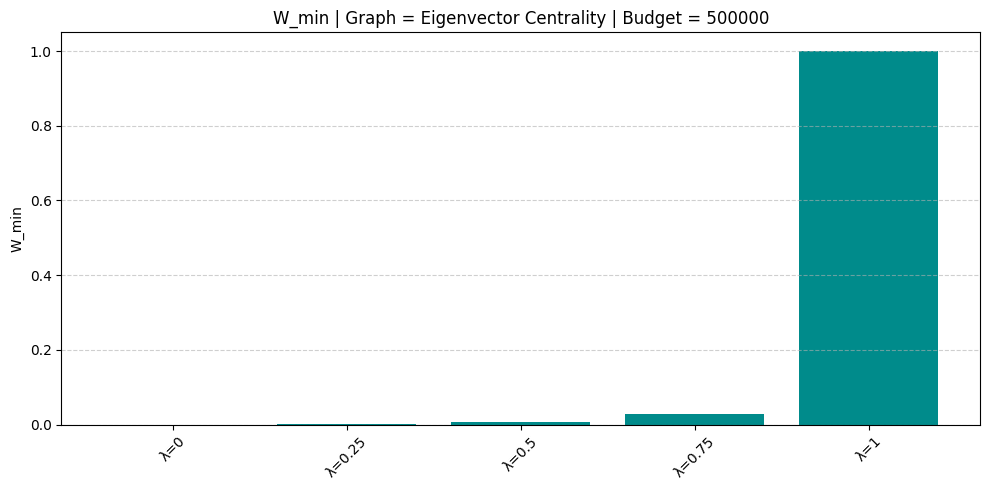

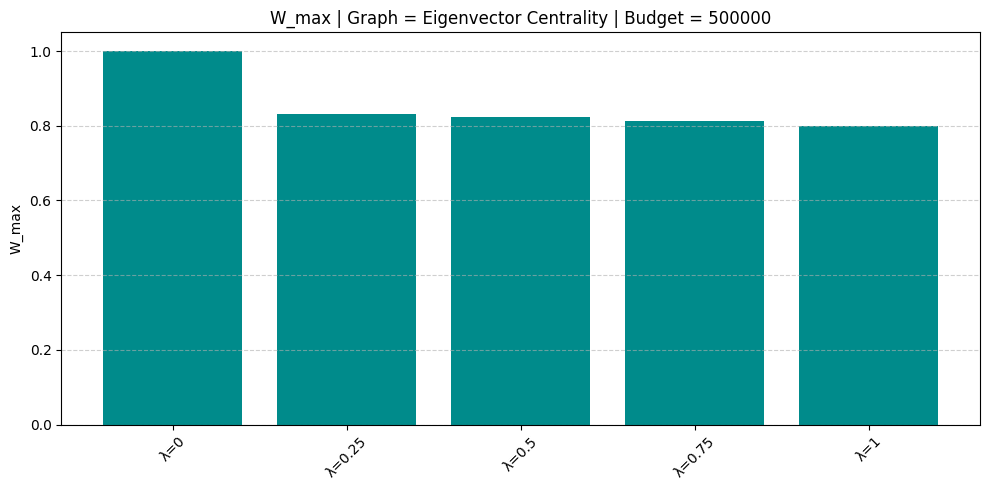

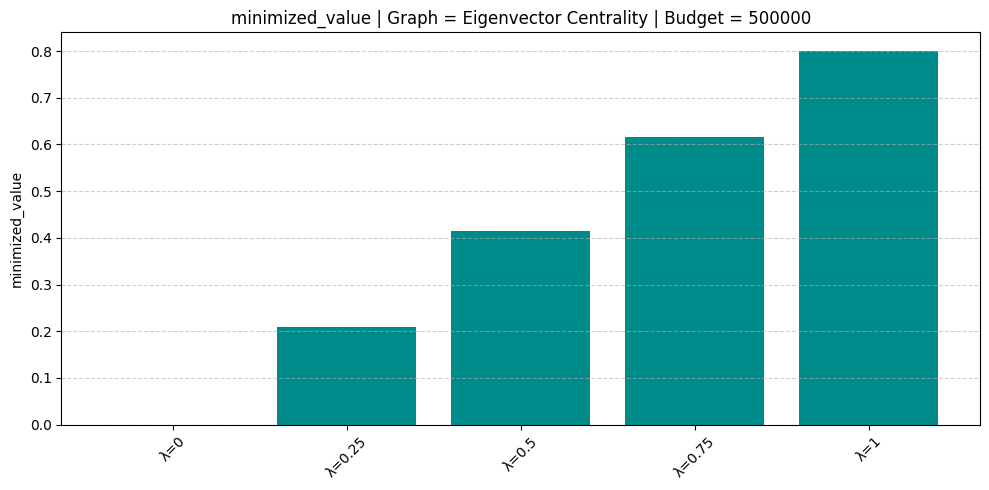

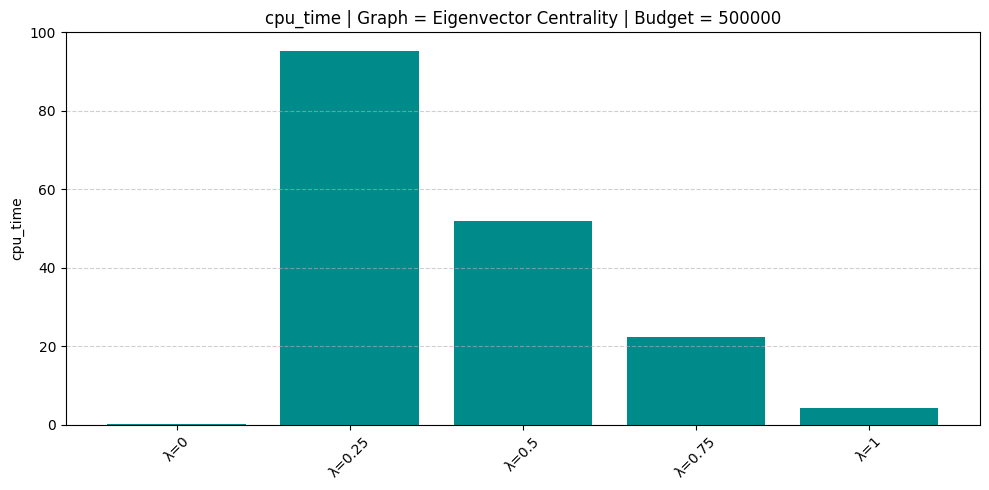

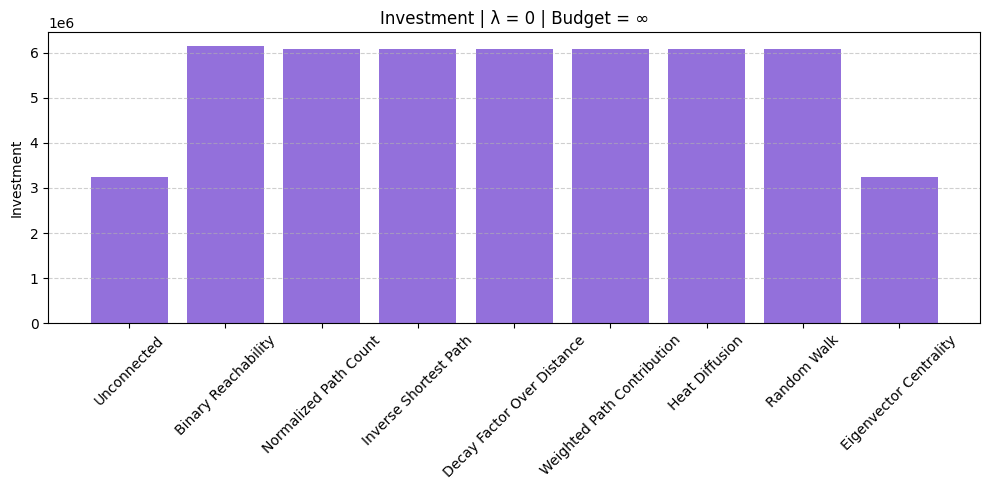

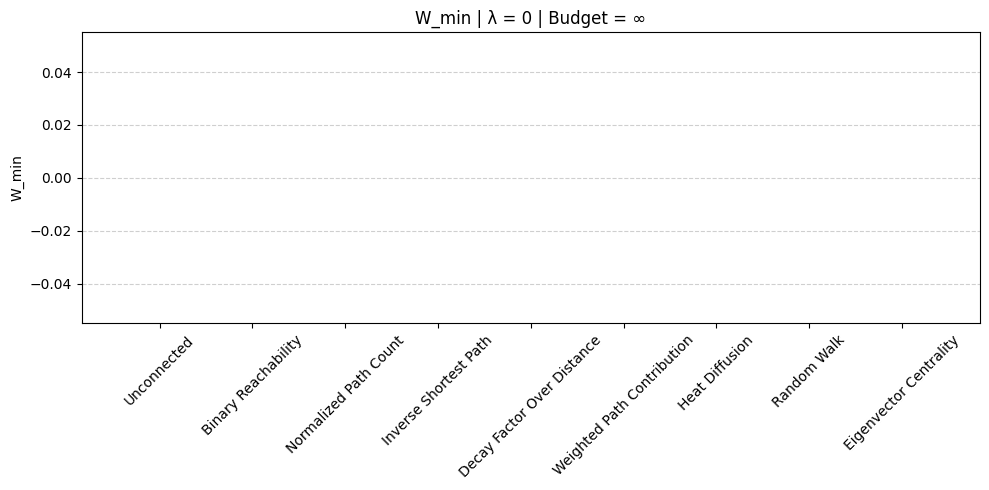

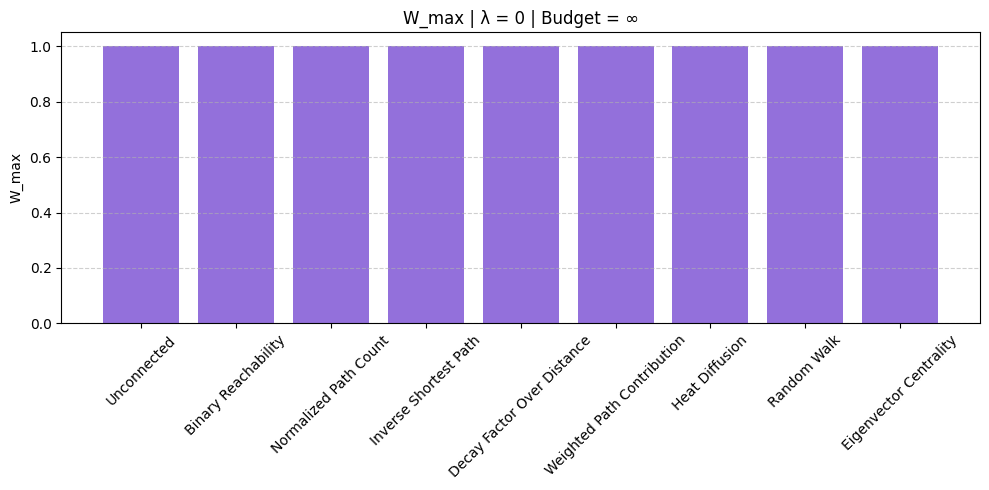

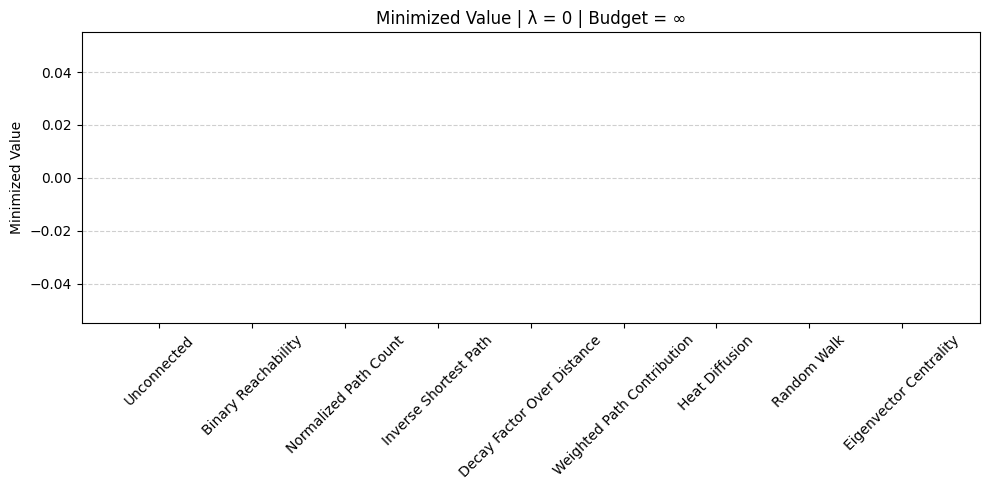

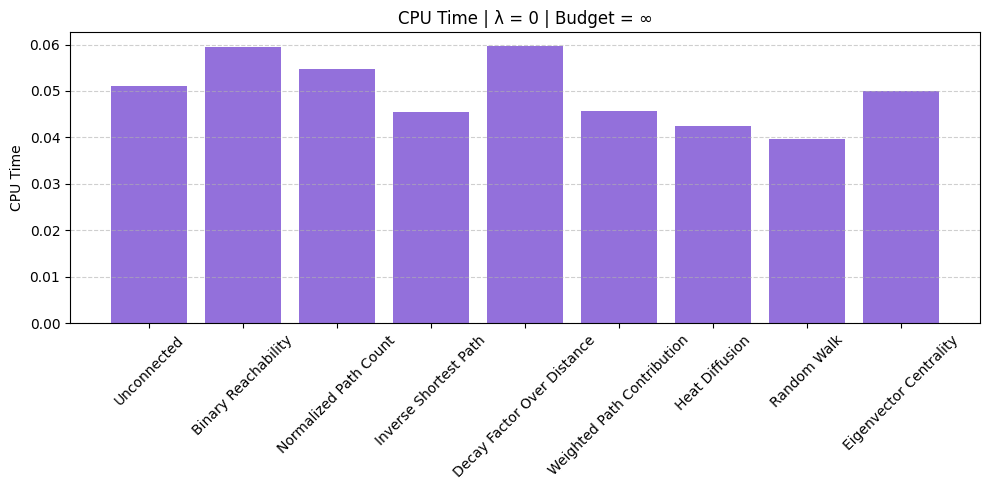

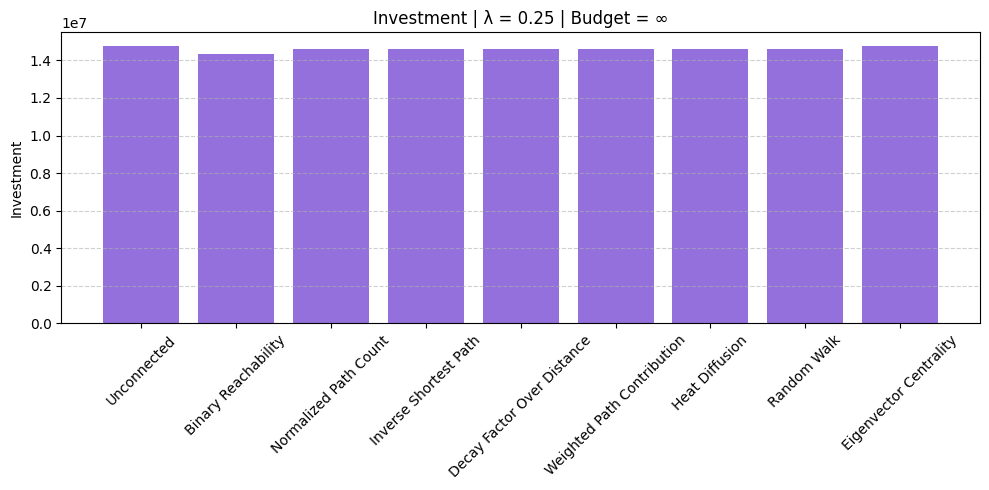

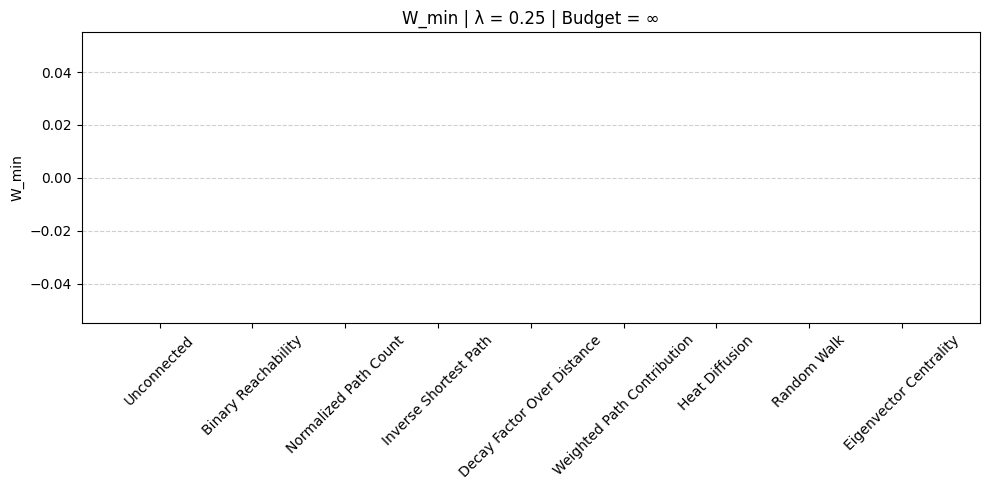

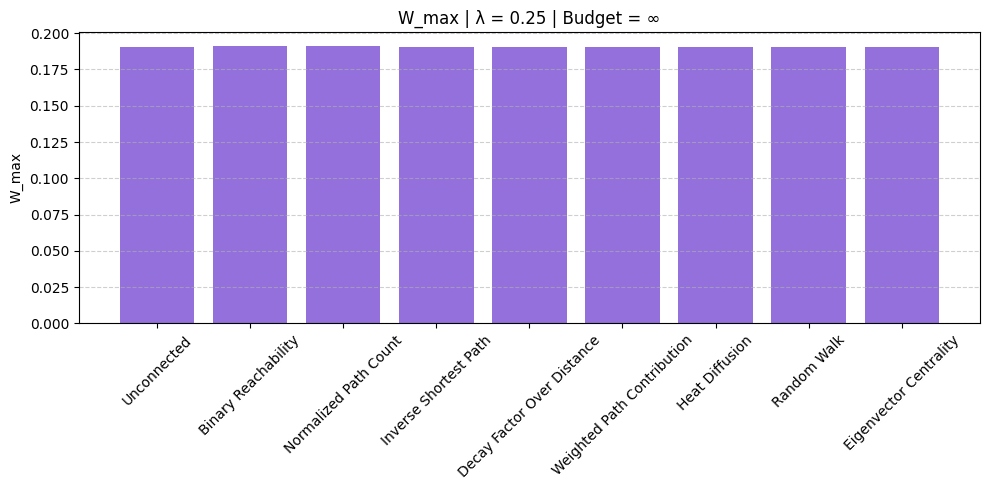

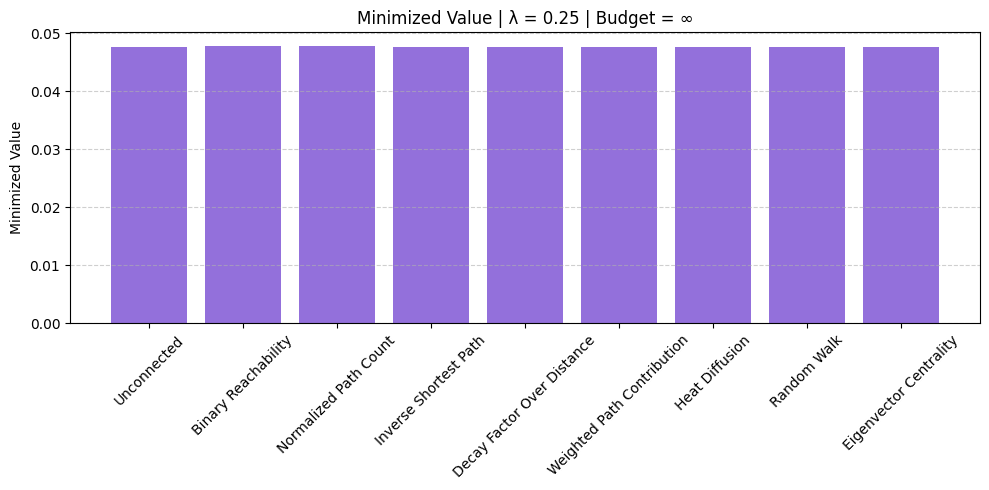

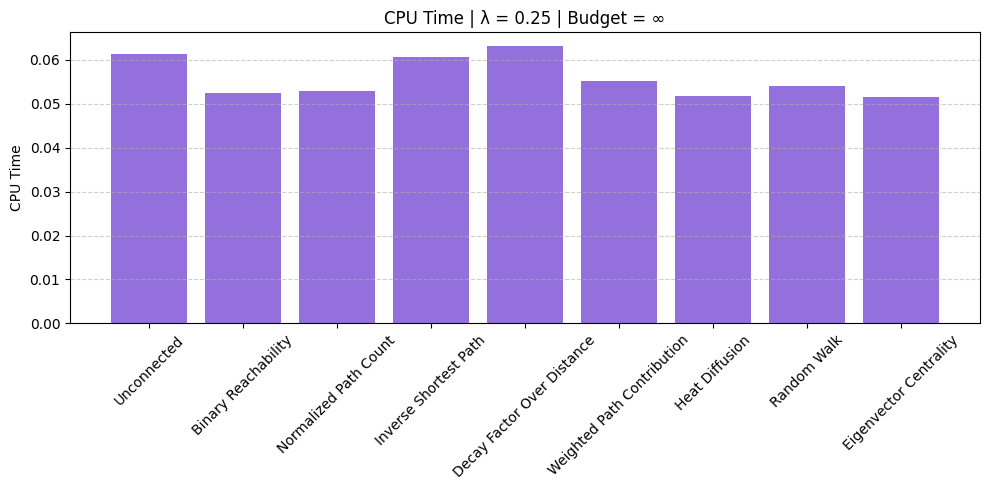

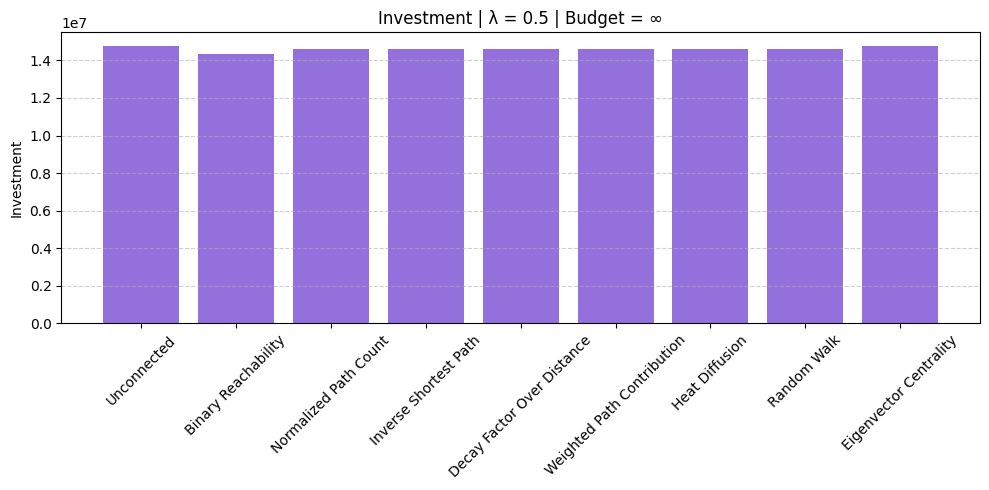

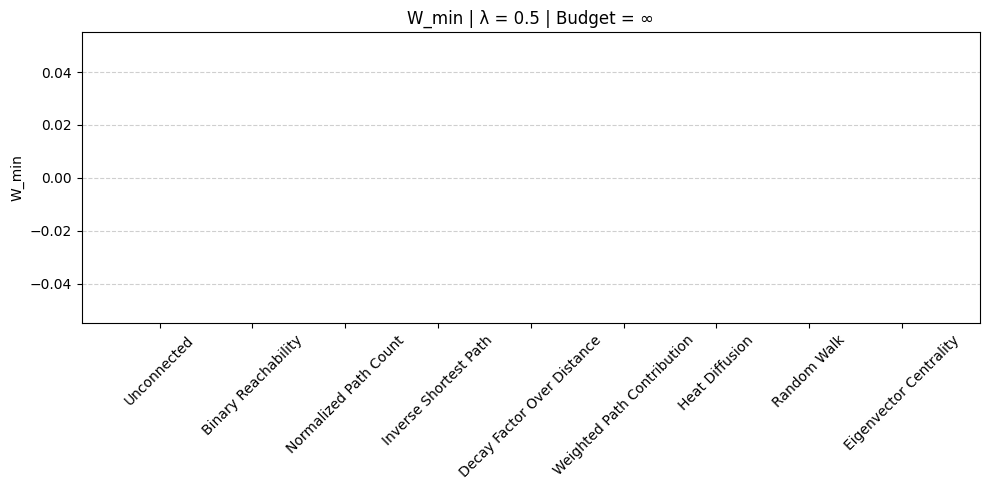

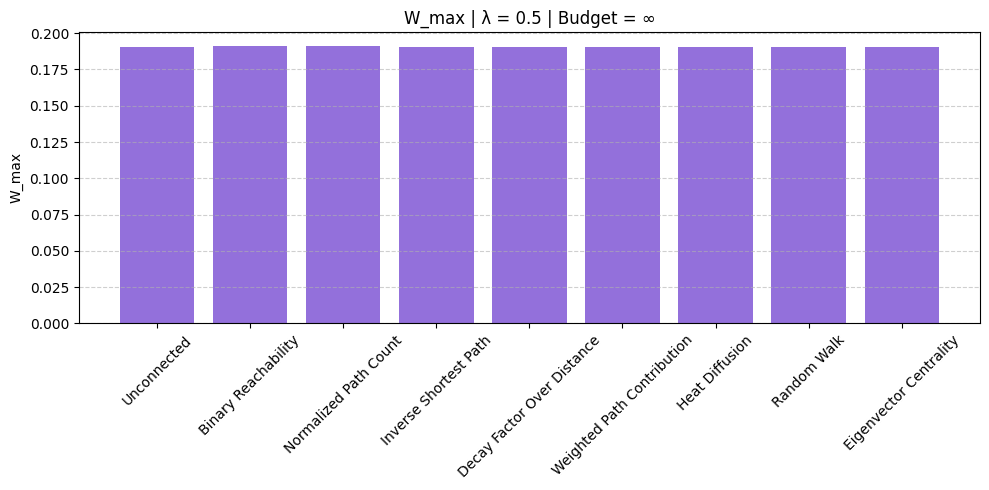

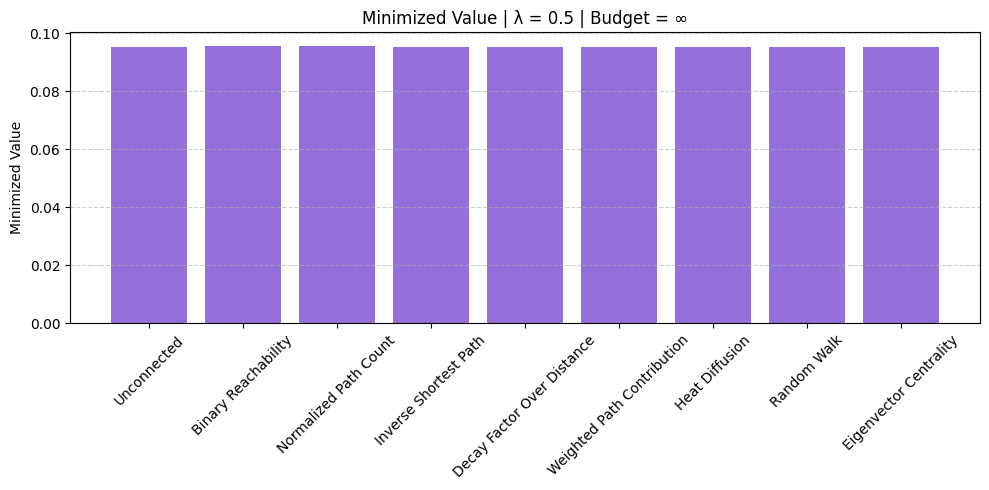

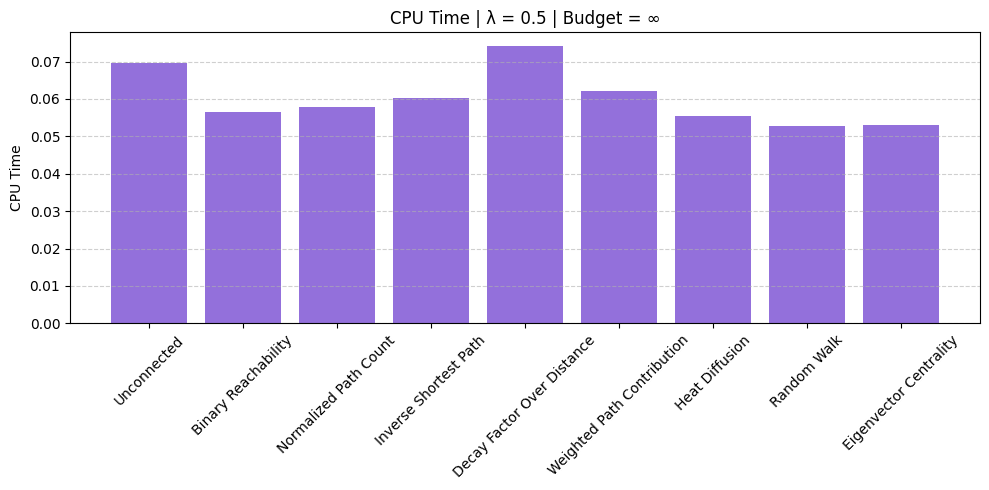

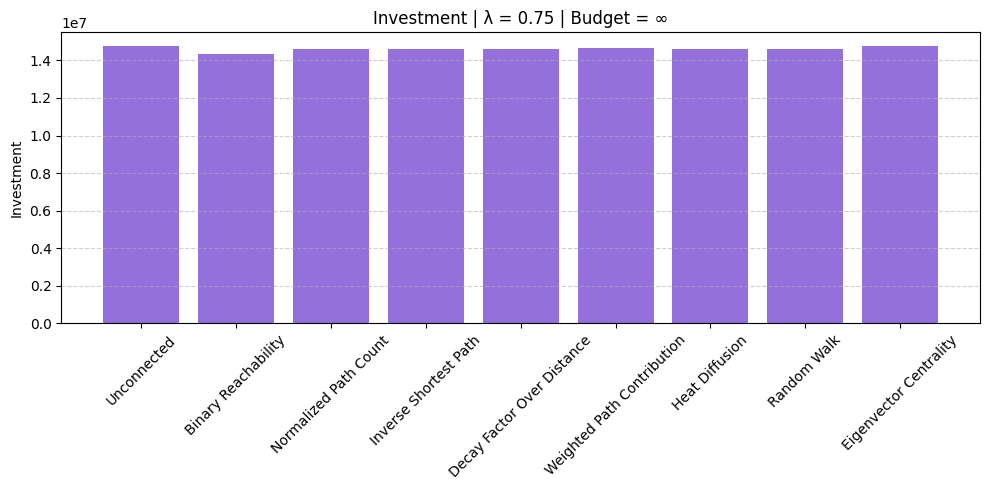

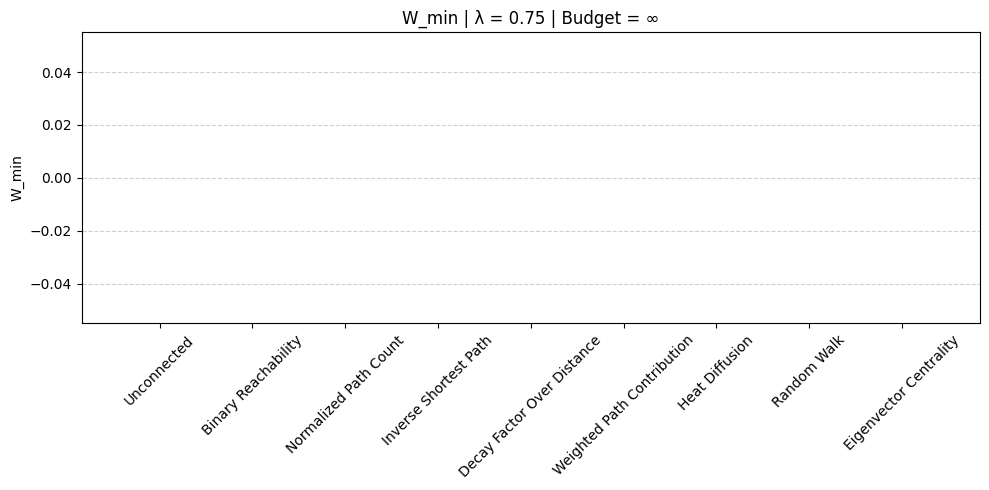

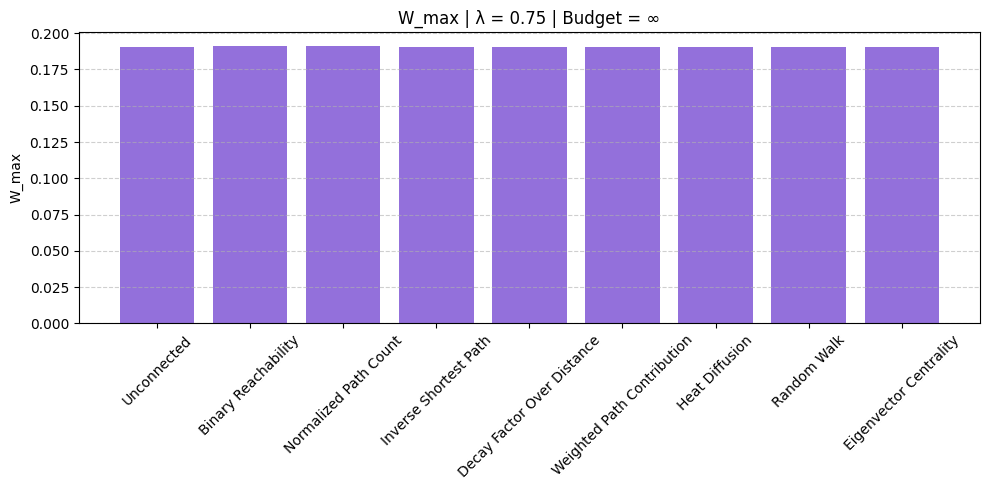

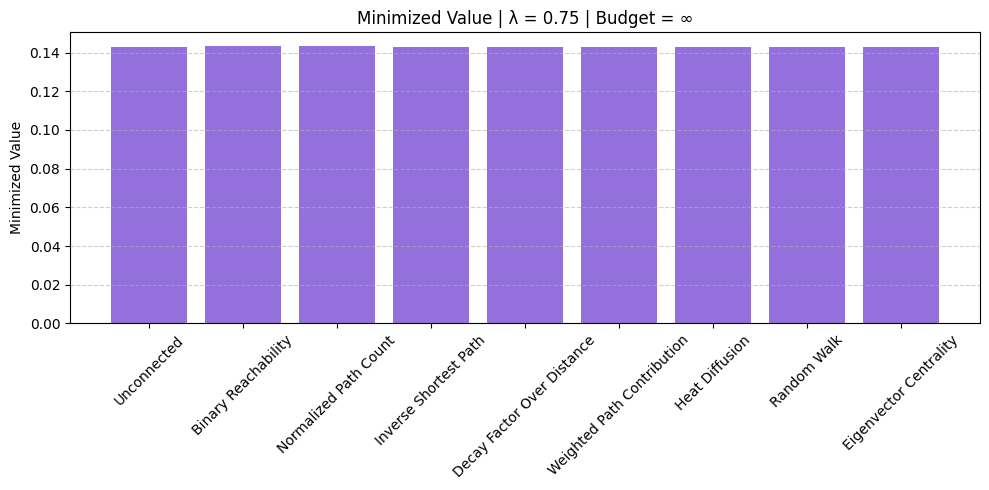

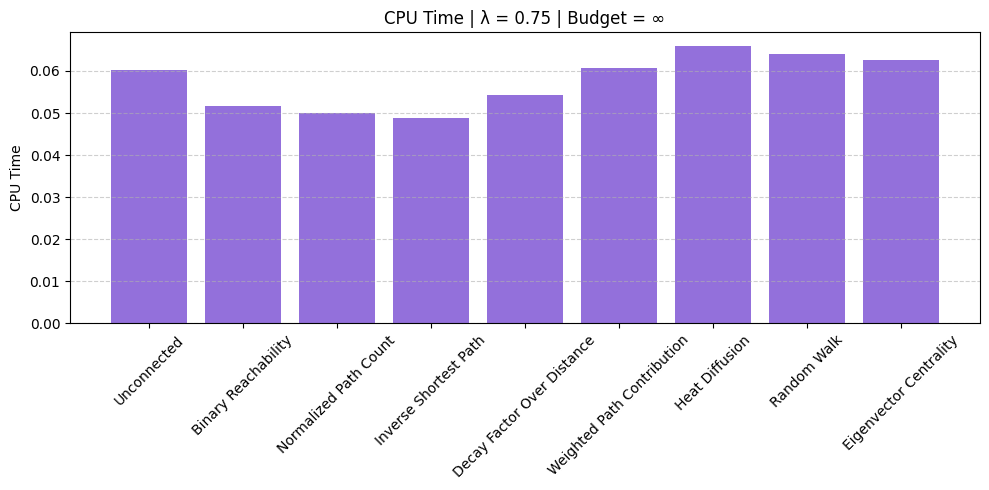

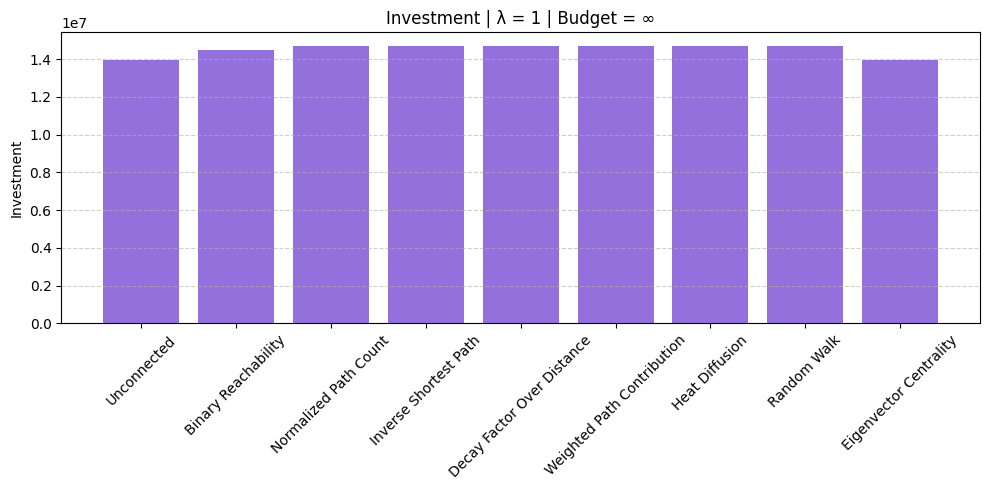

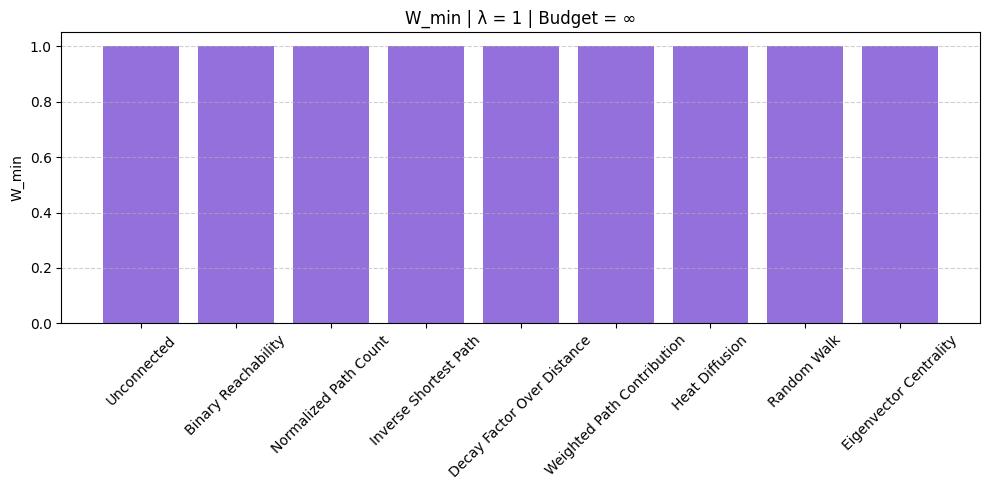

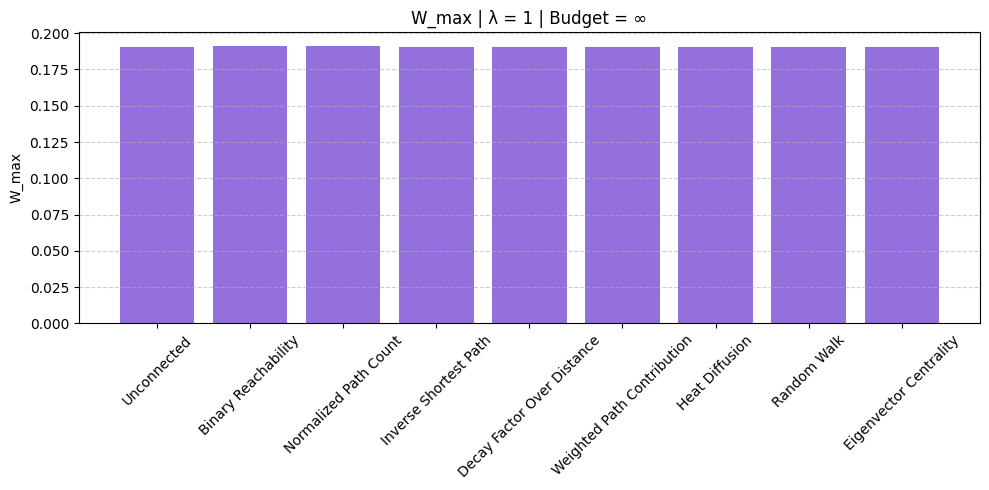

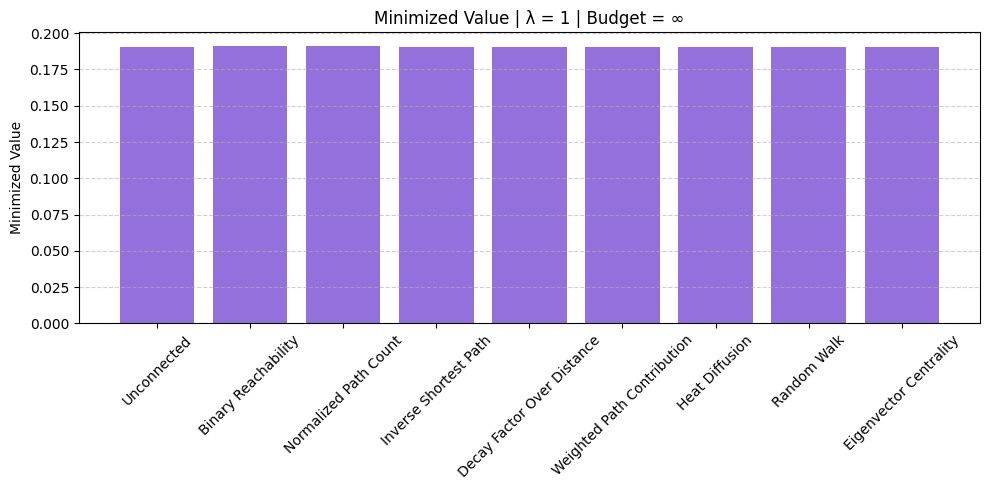

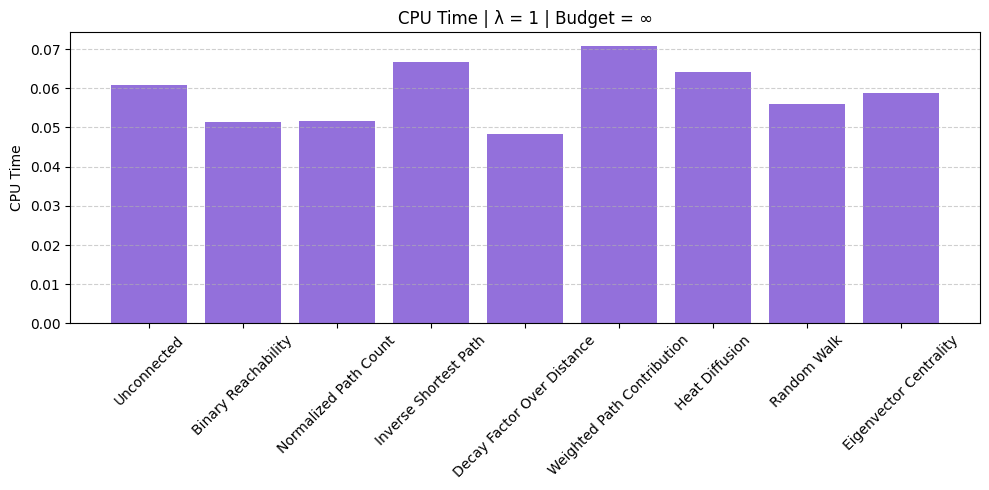

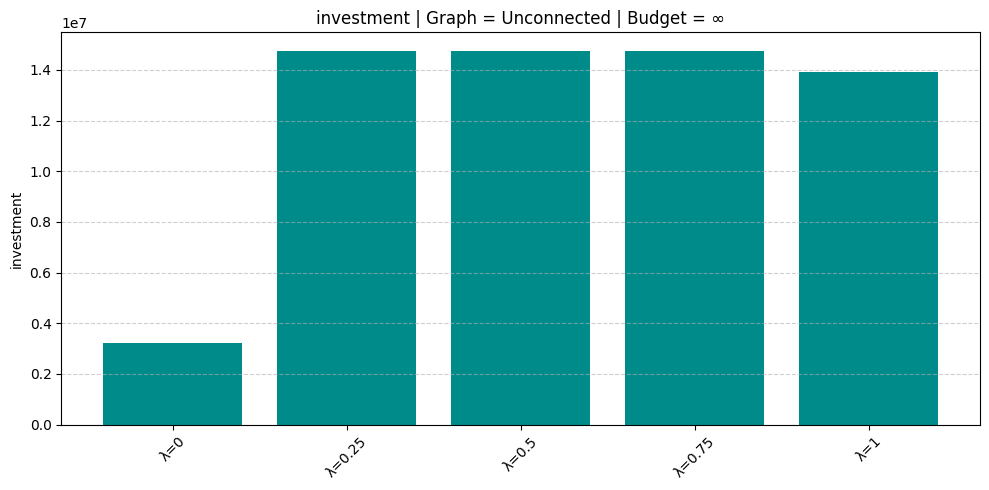

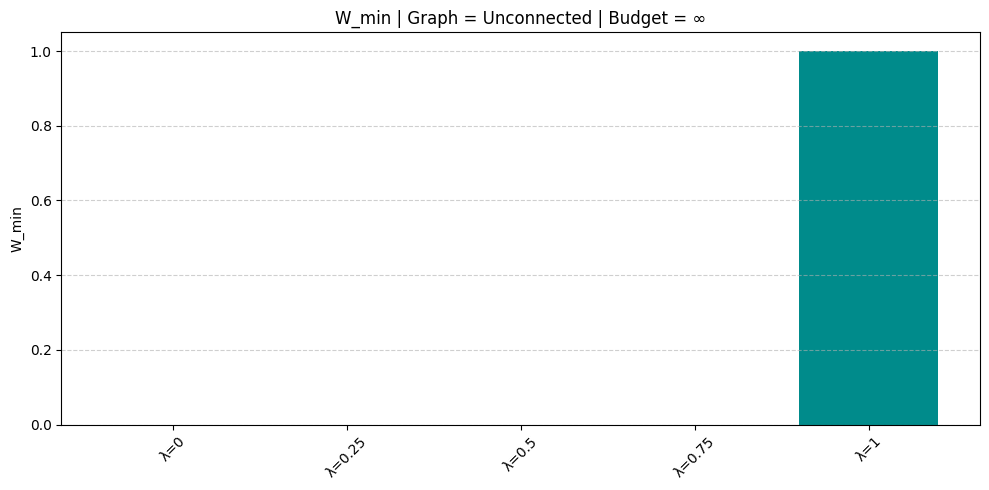

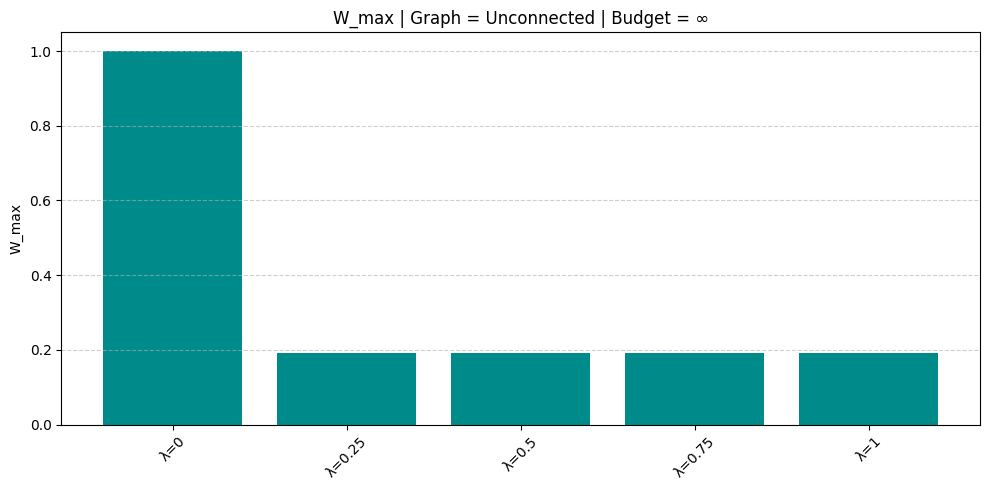

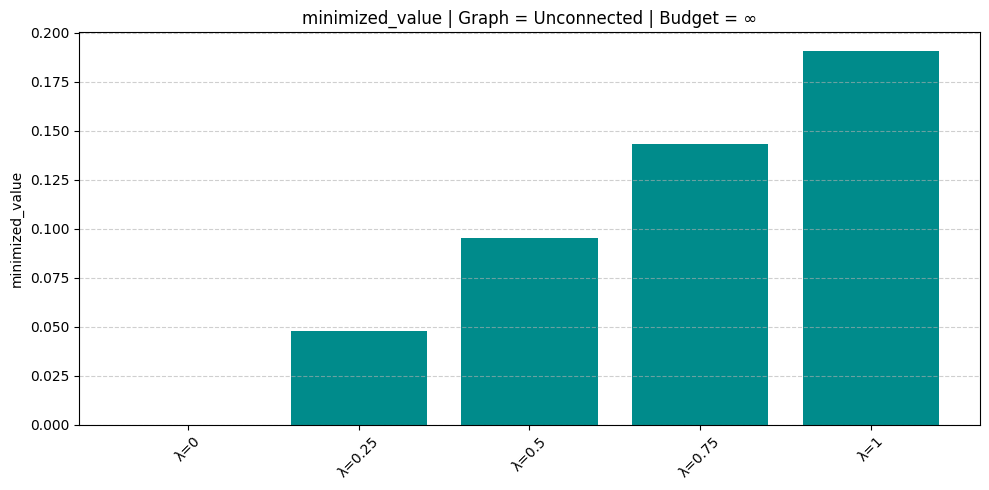

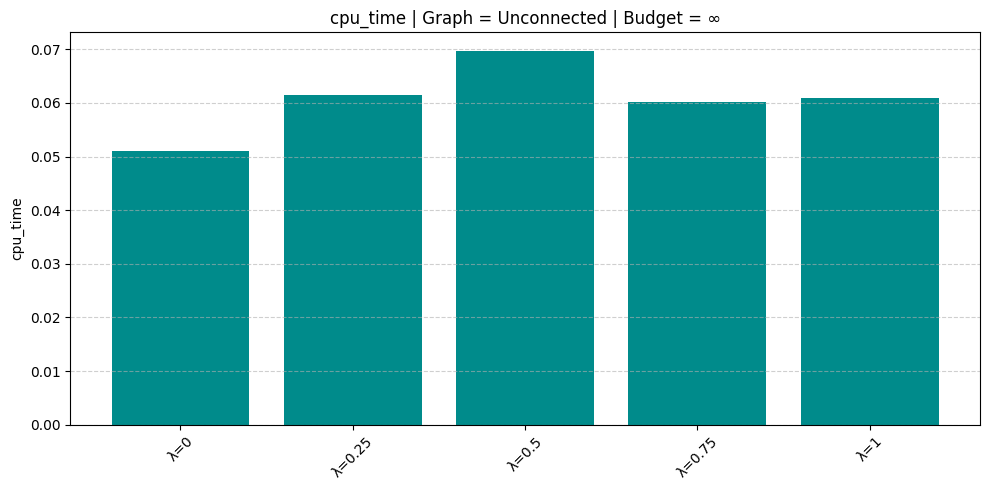

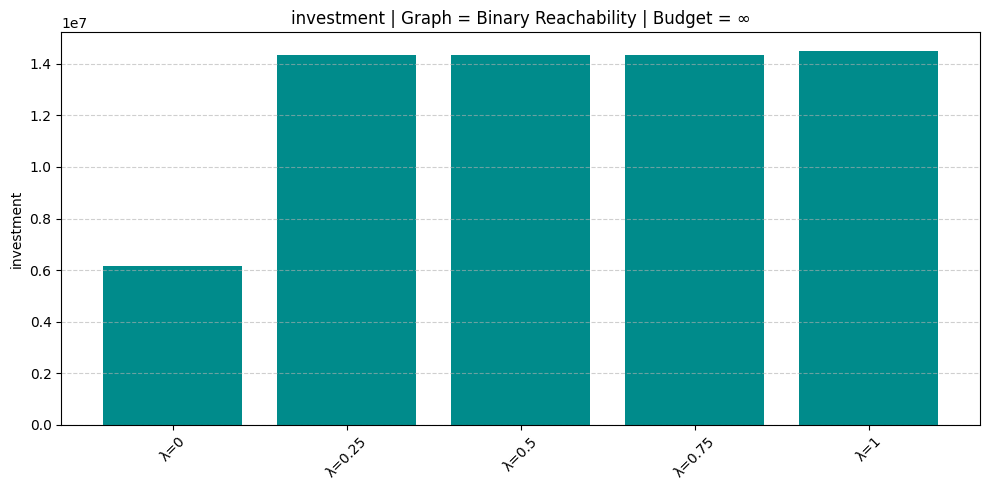

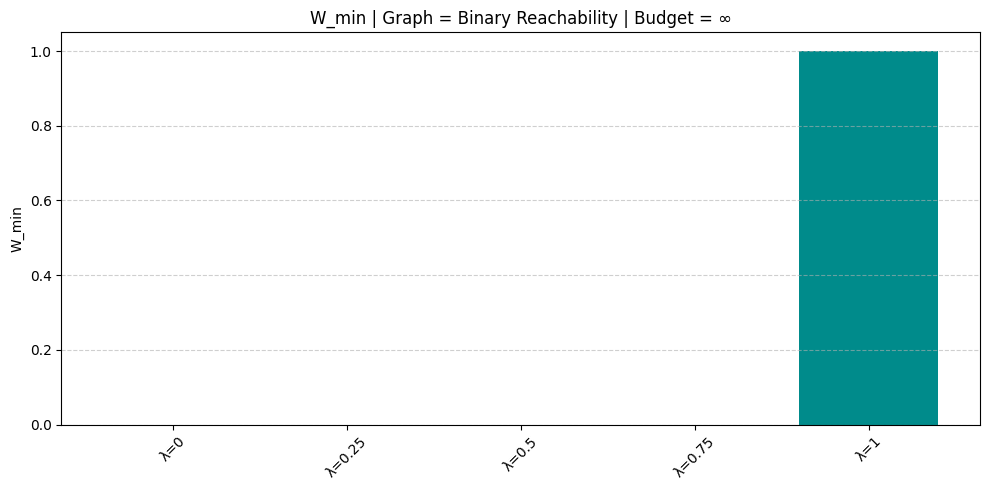

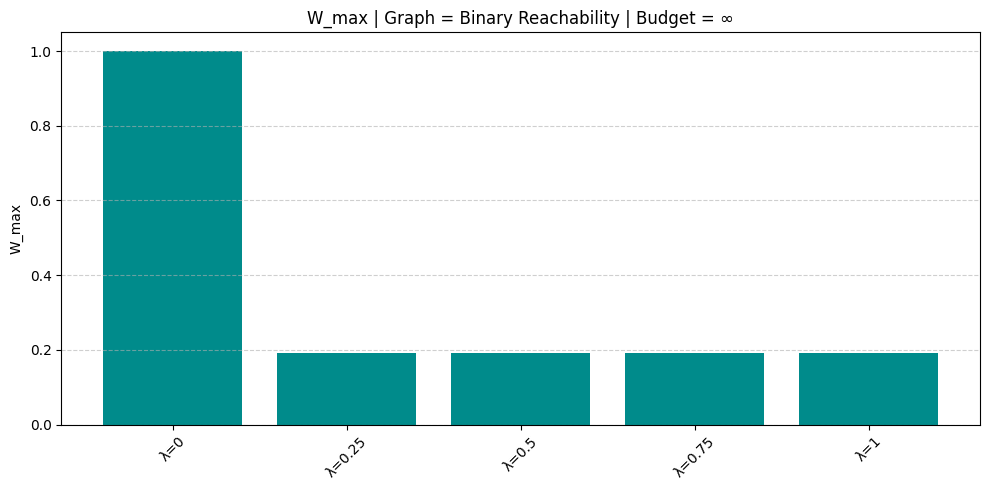

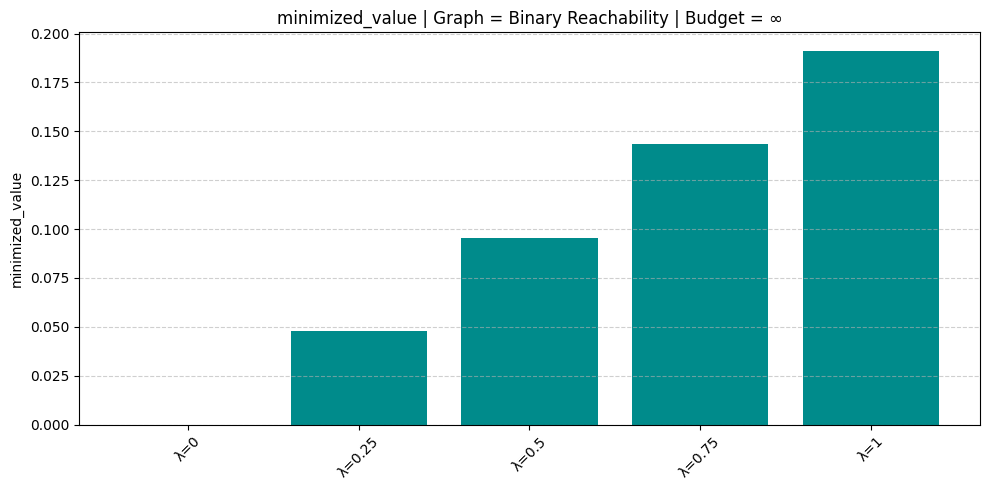

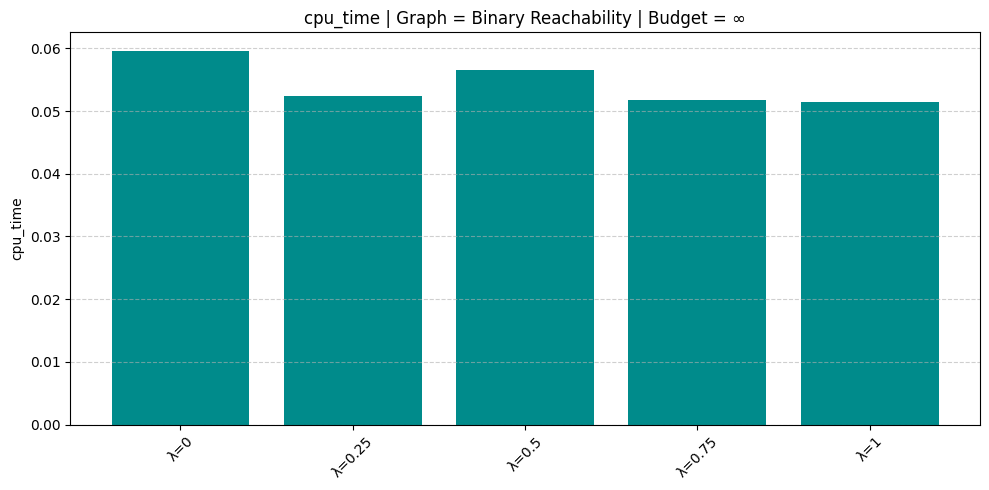

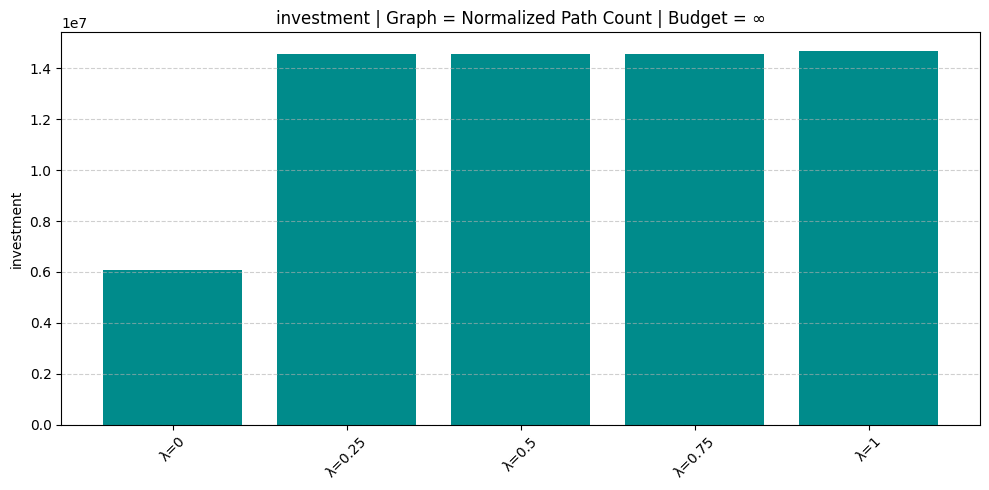

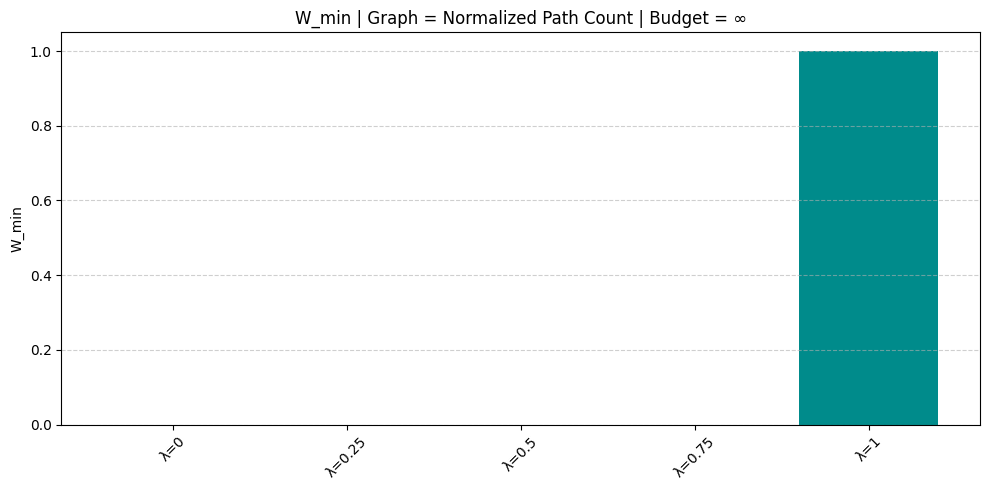

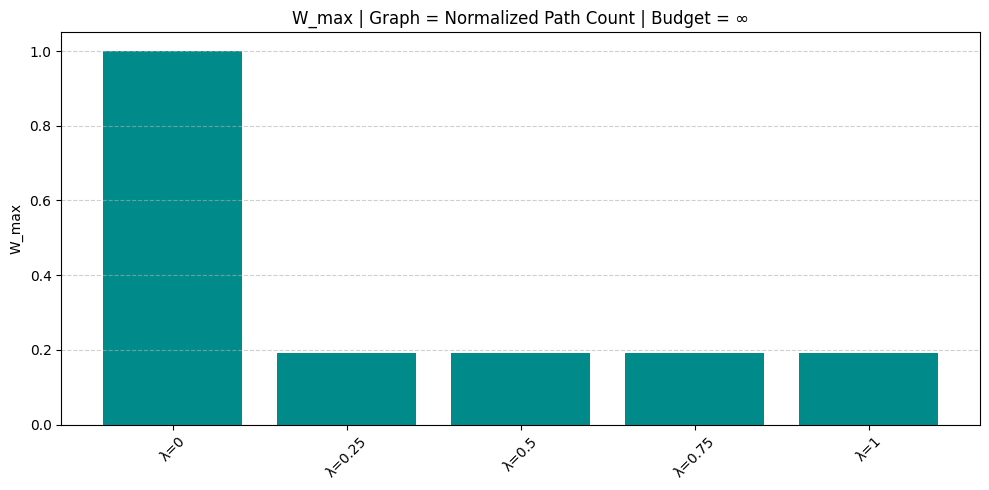

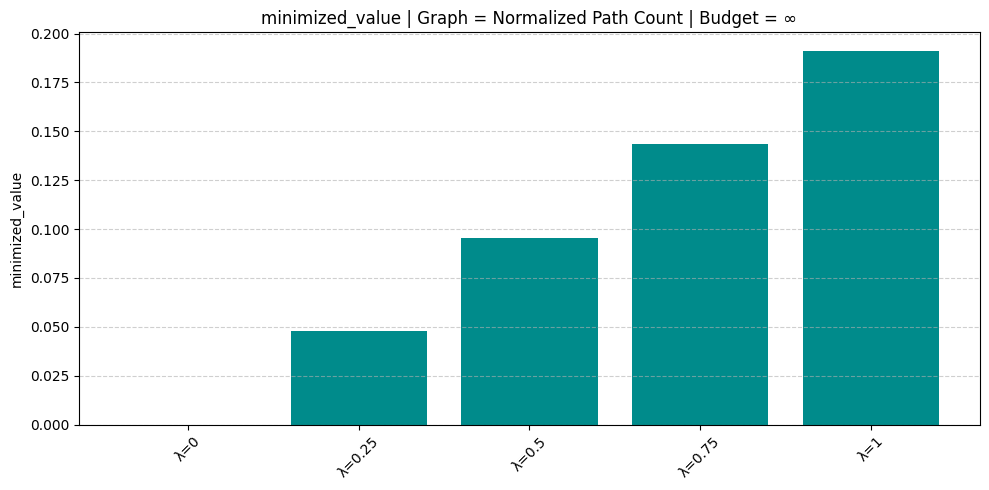

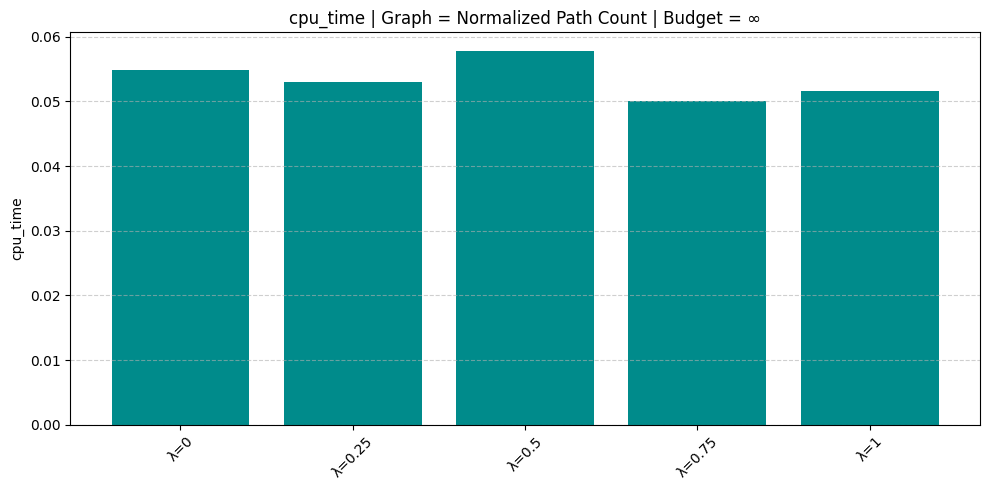

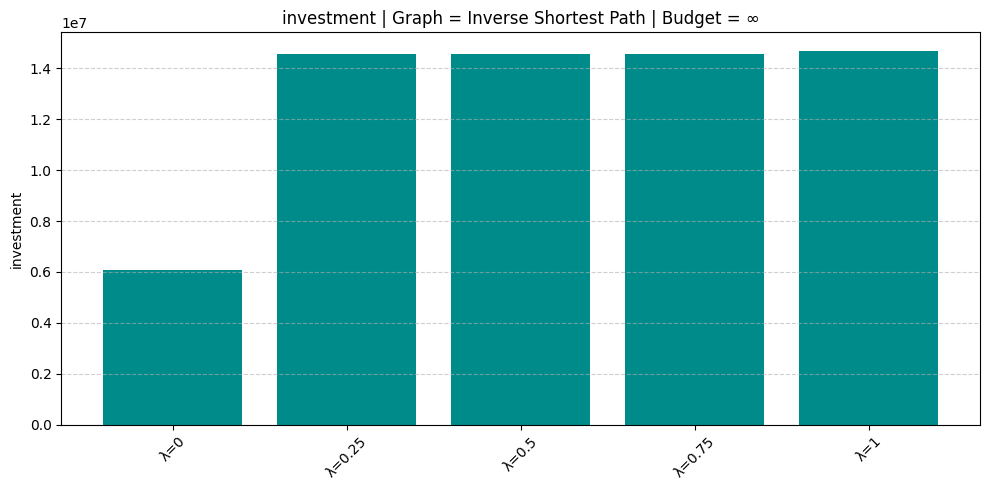

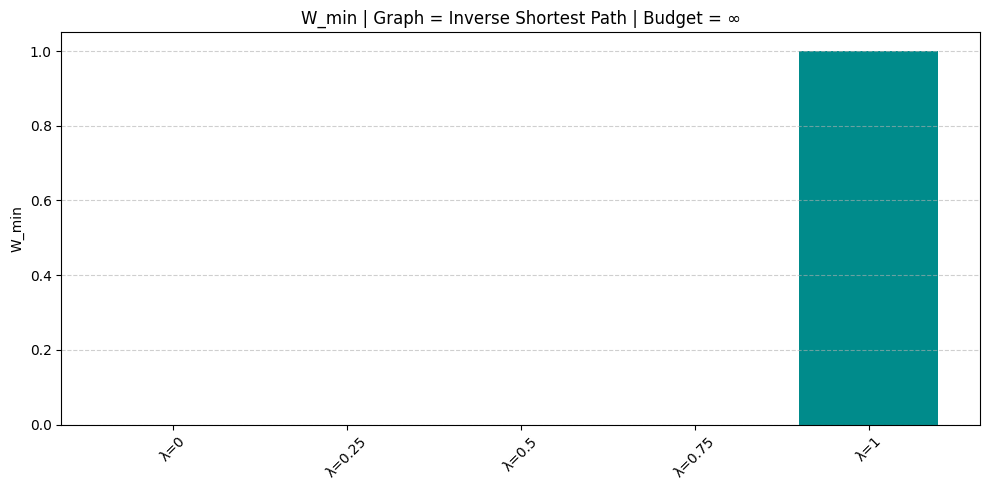

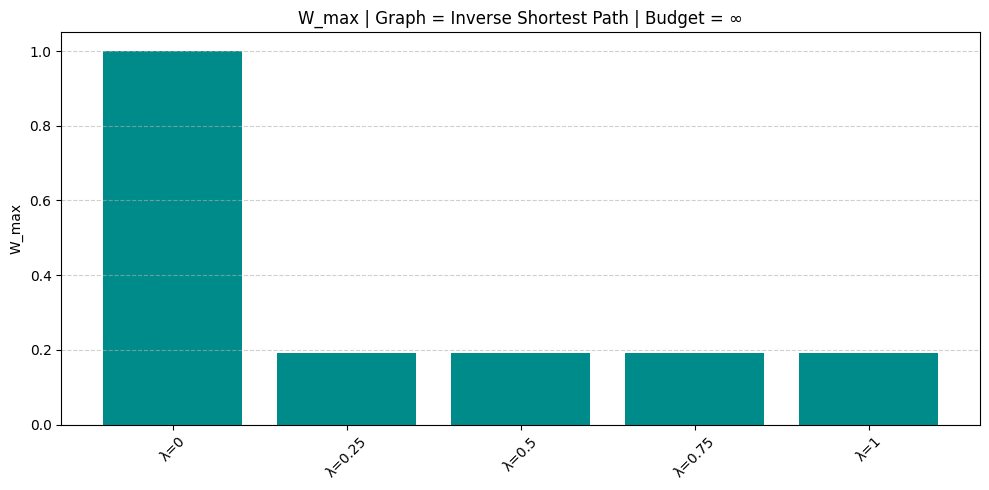

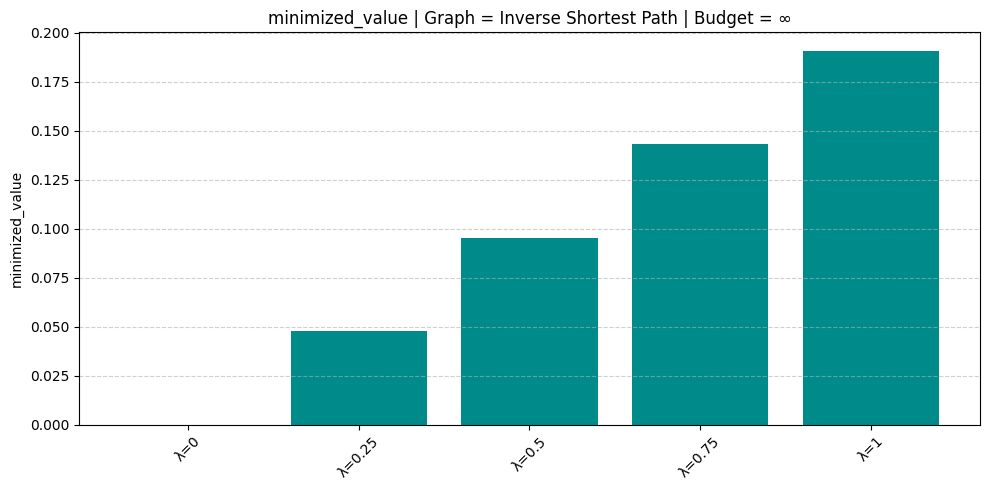

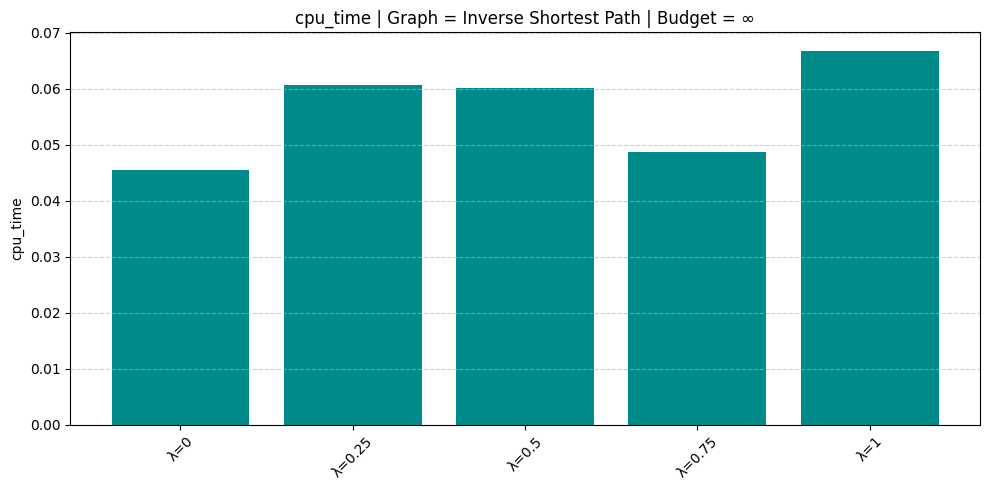

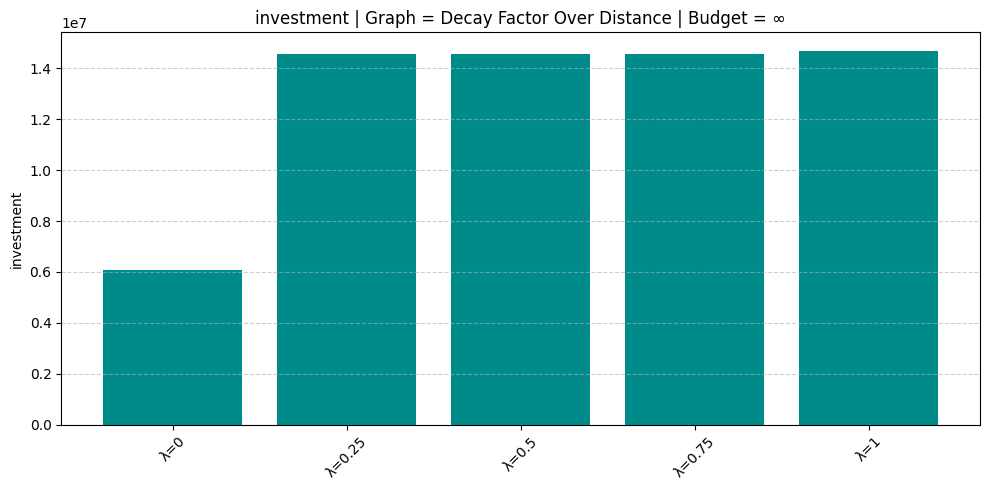

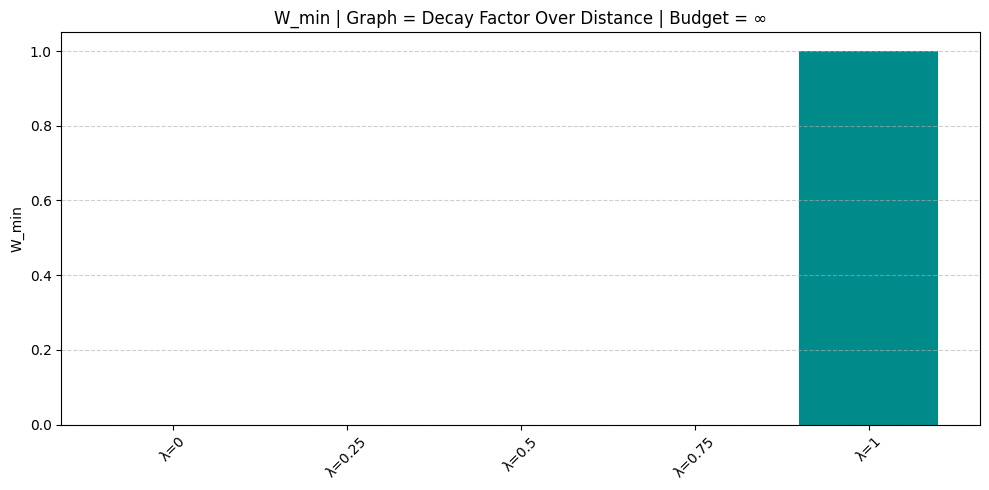

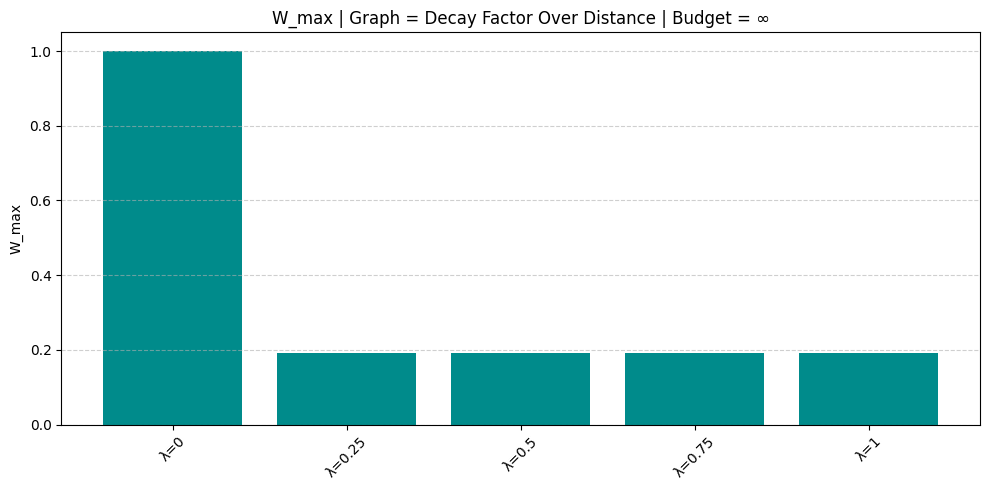

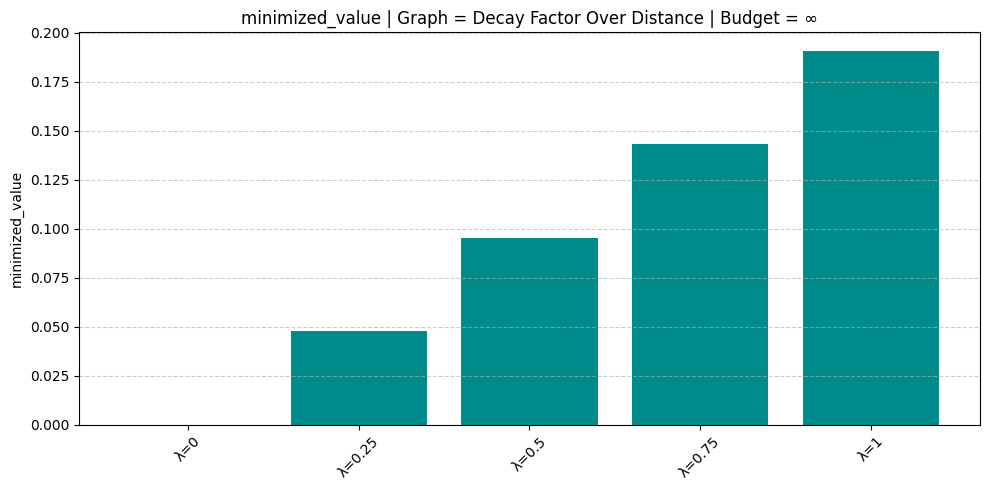

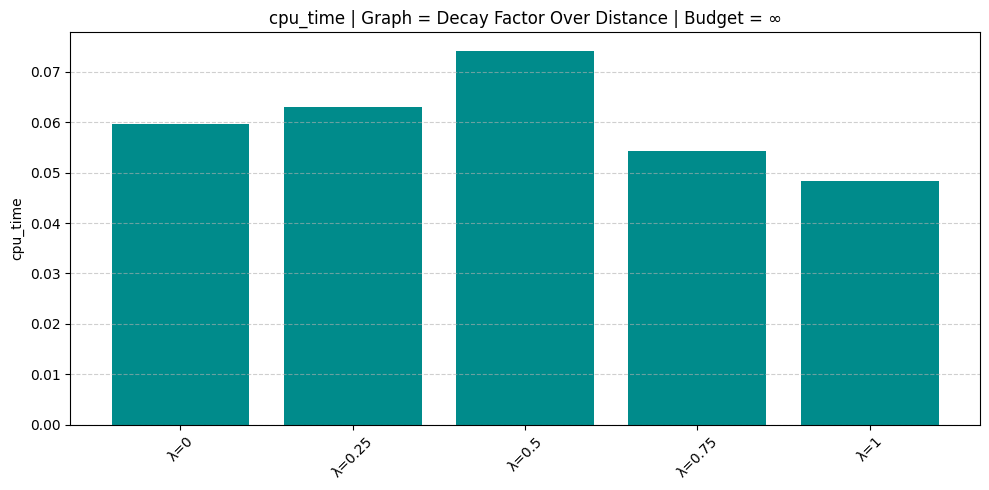

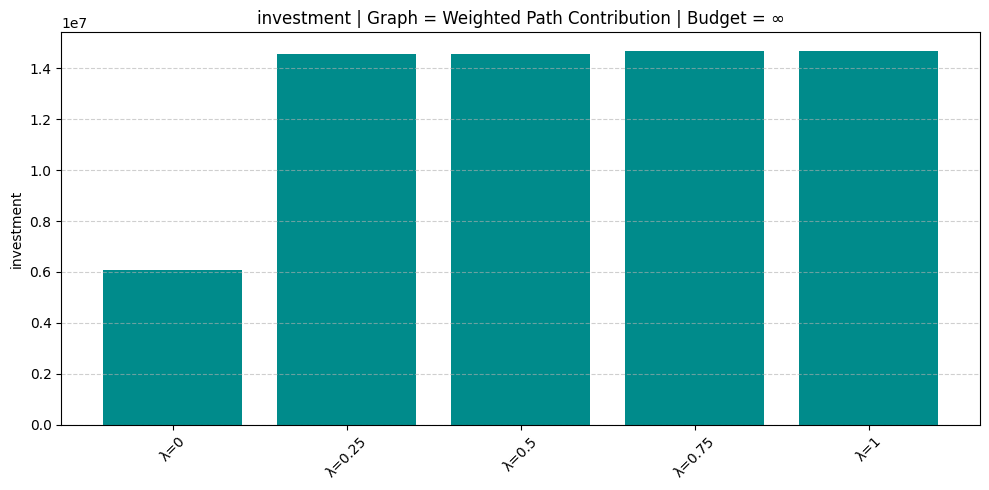

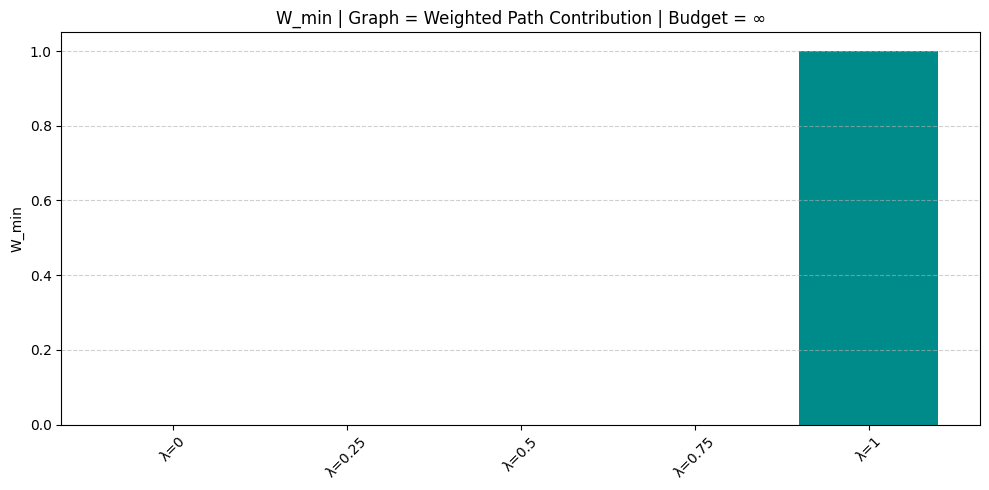

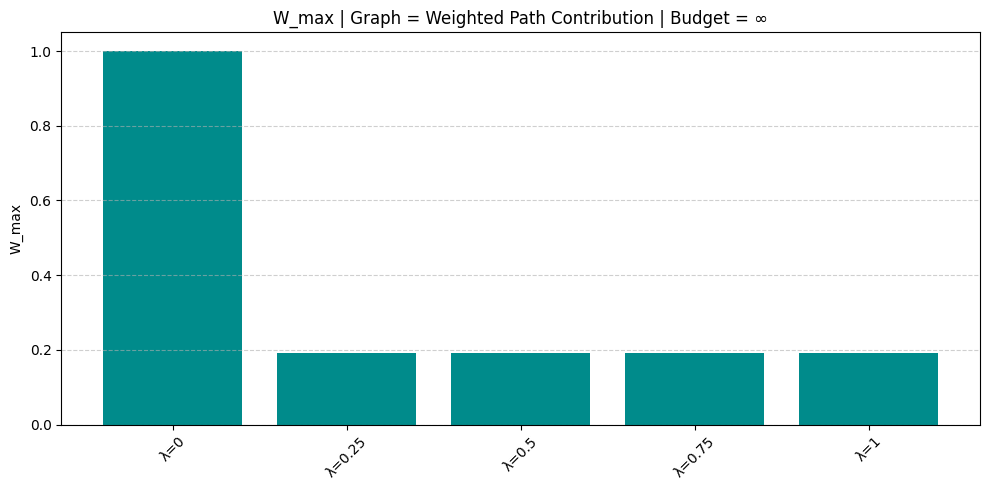

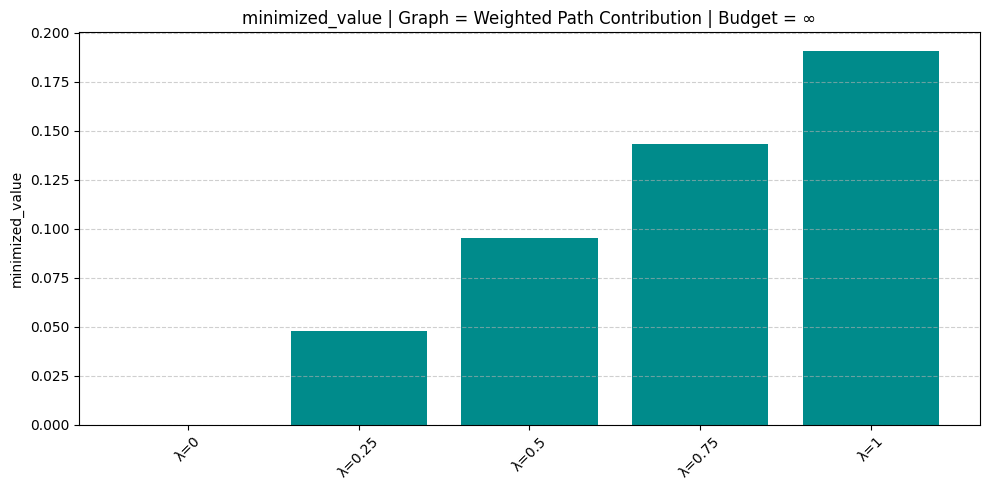

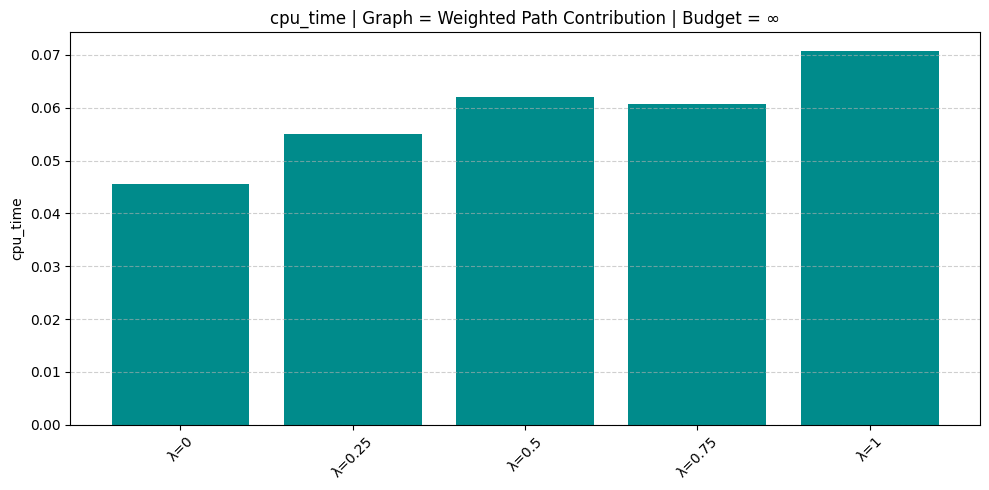

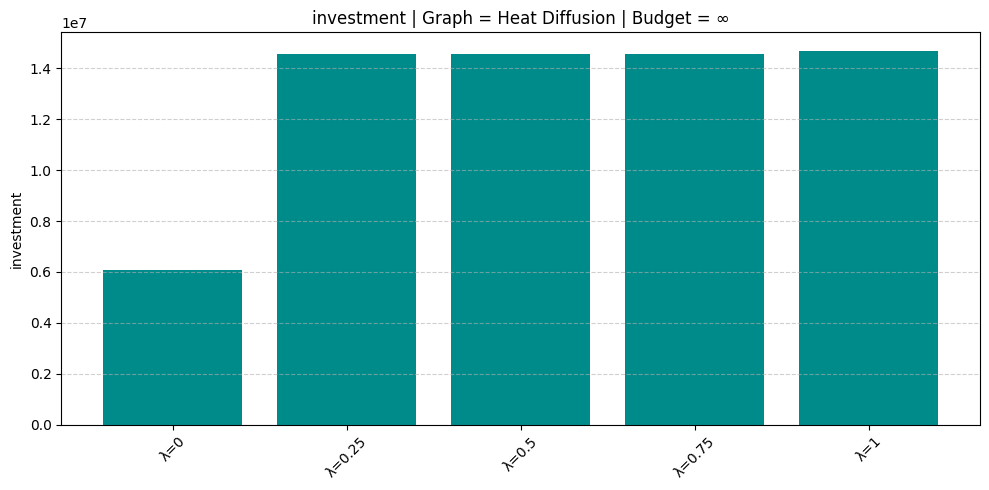

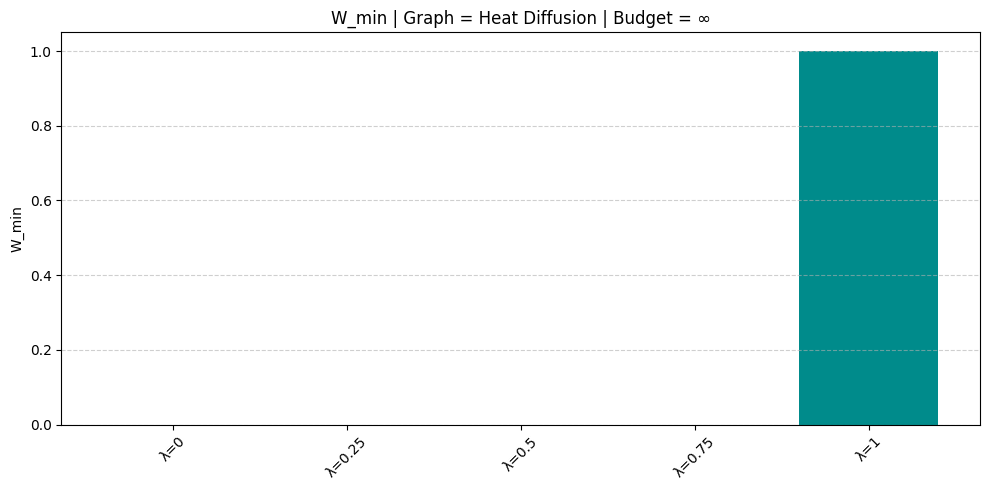

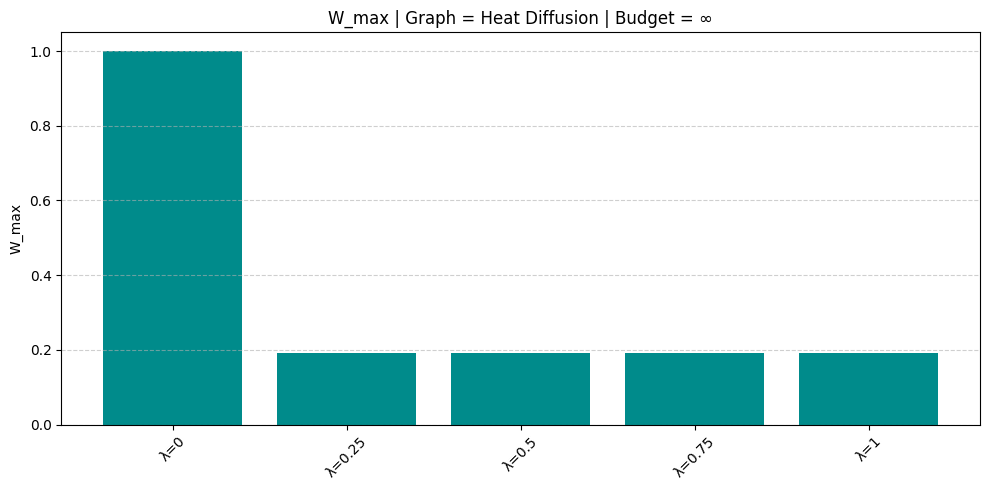

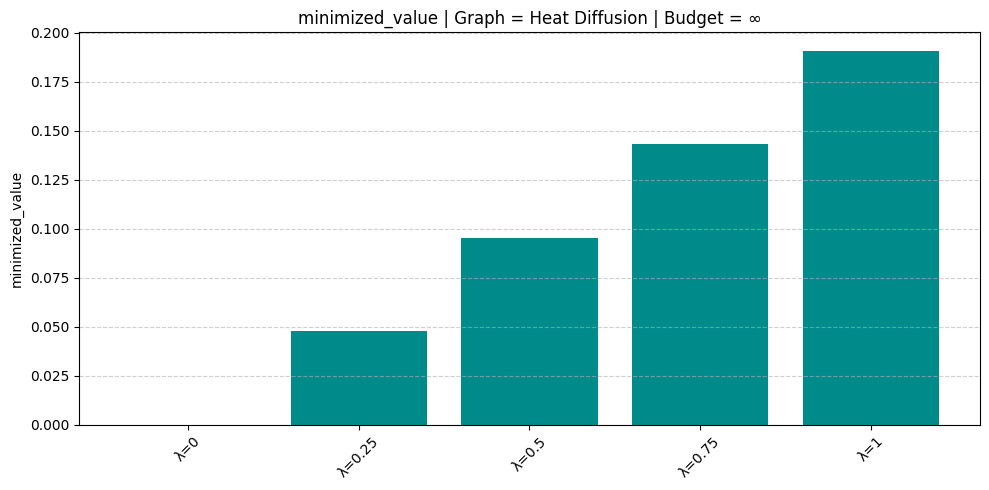

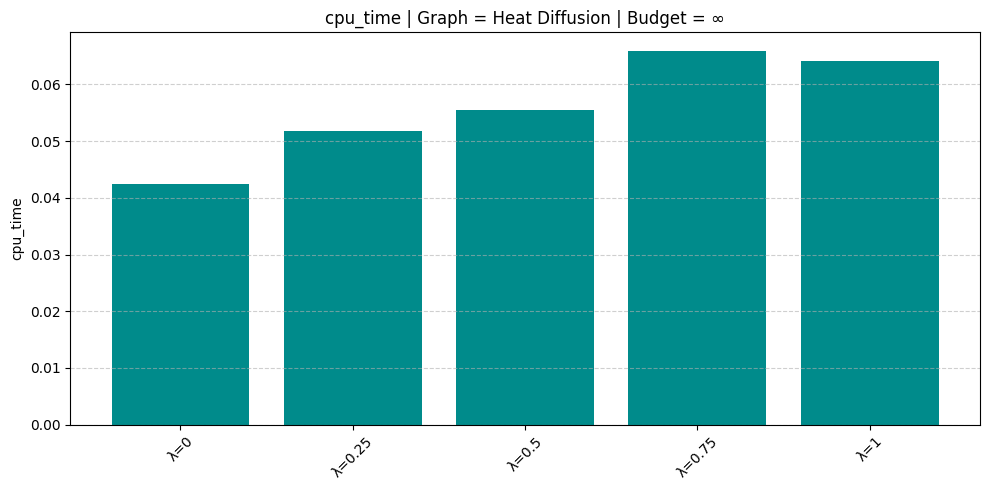

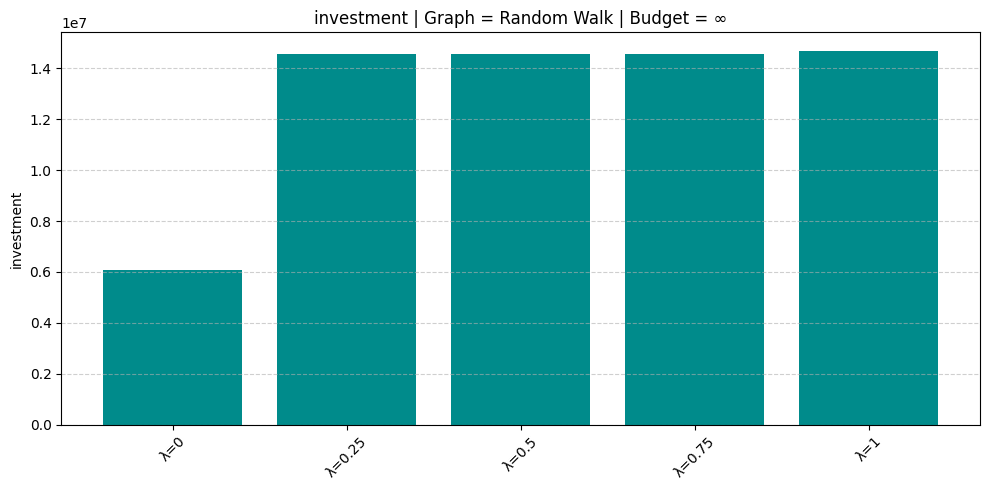

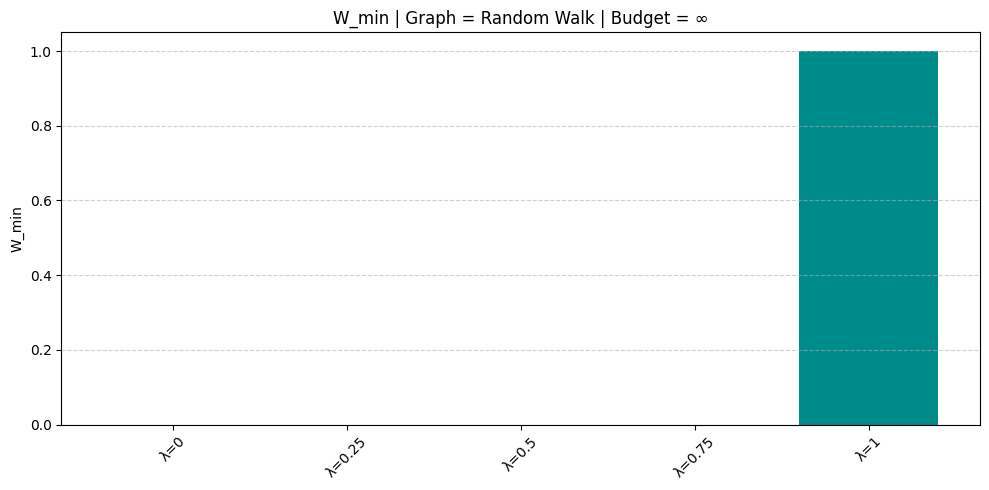

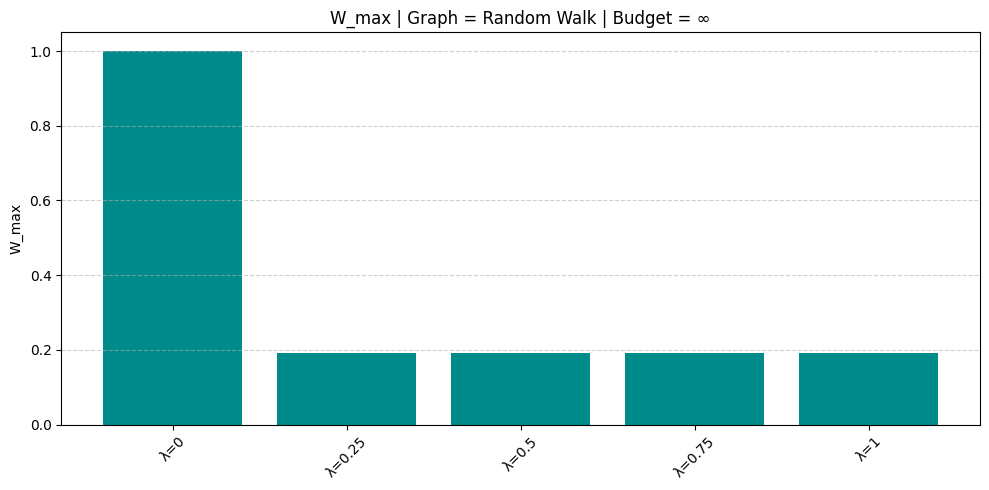

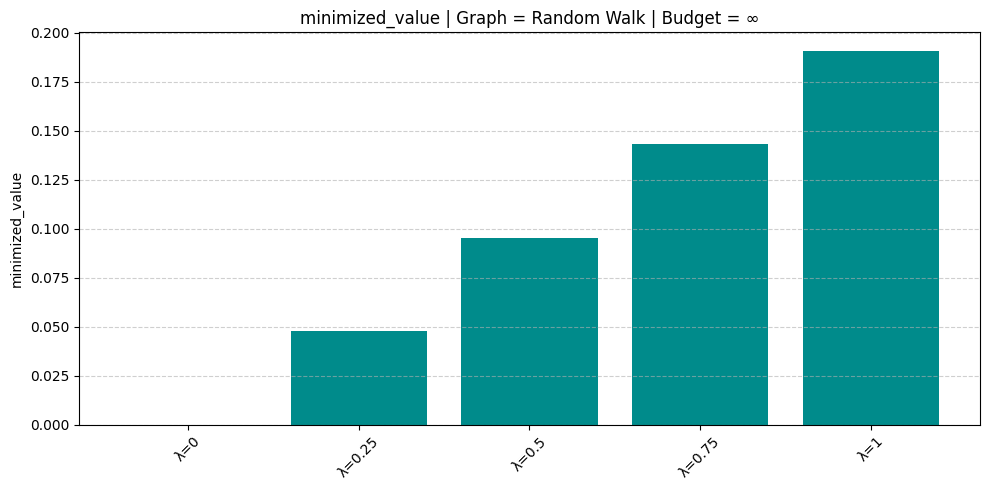

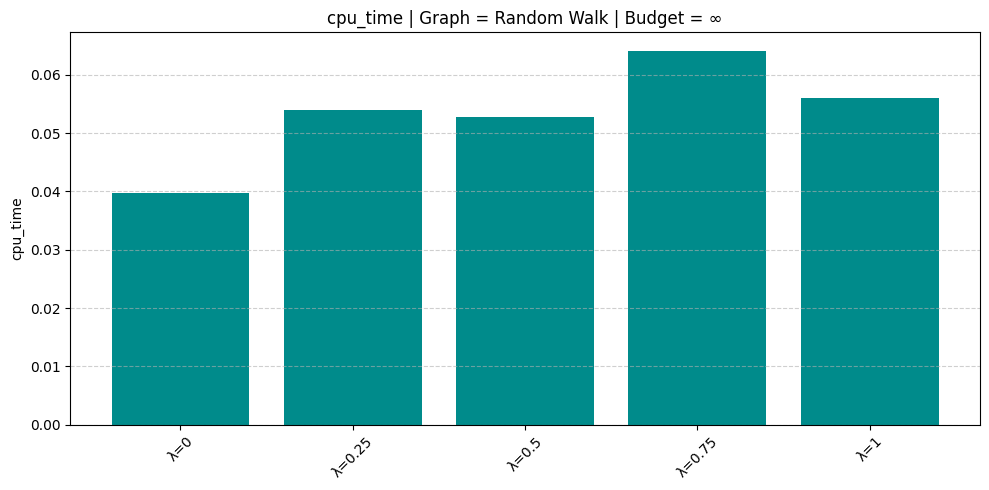

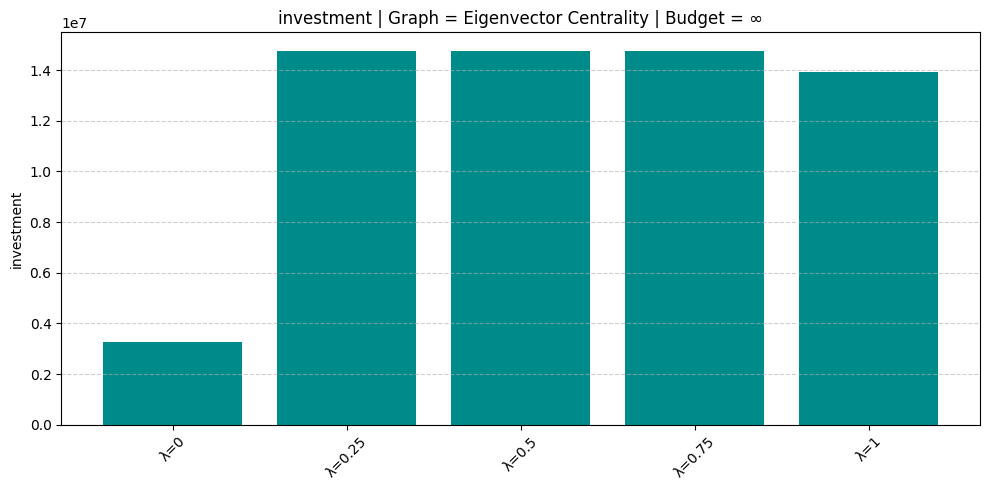

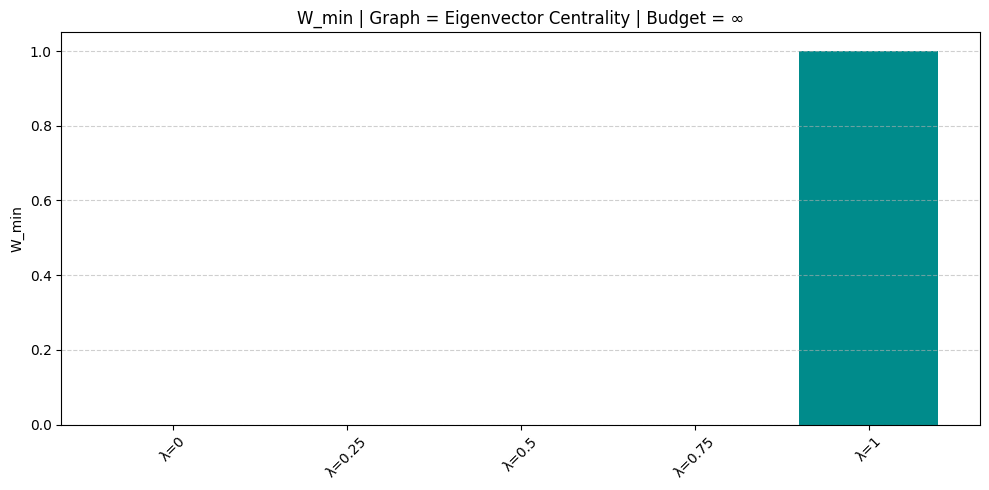

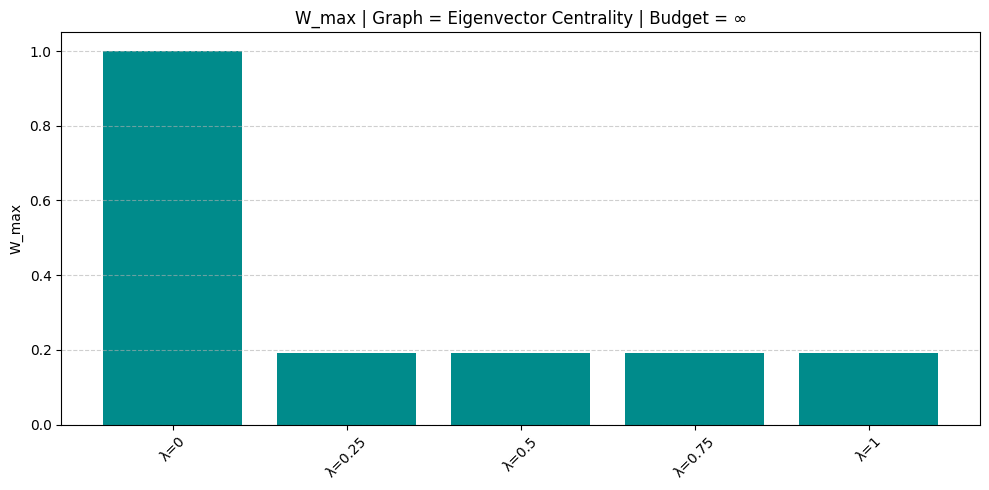

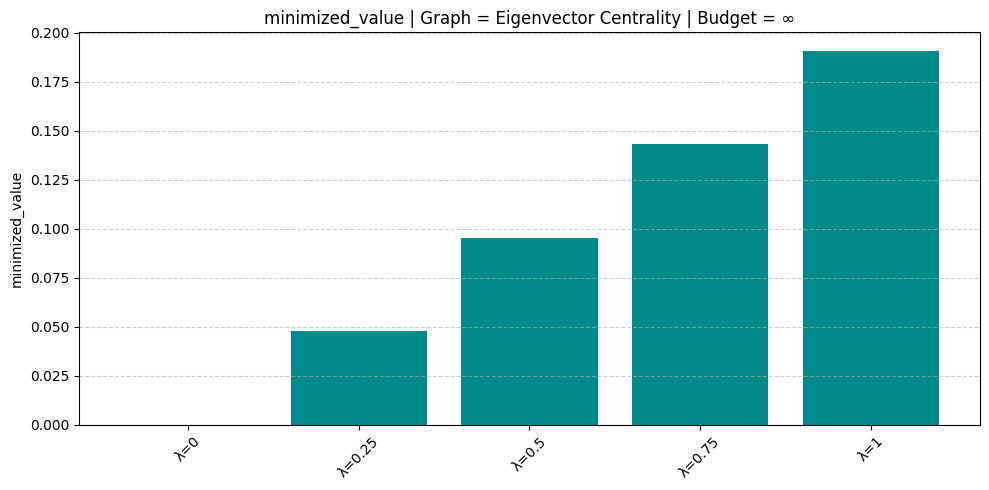

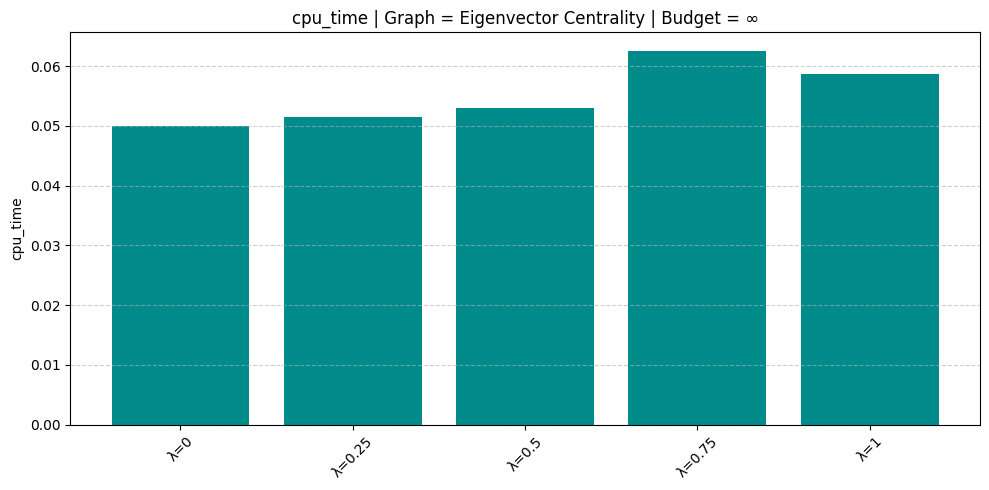


🔹 **Summary Table: Cybsec_BW Results** 🔹
+----------------------------+----------+----------+--------------+---------+---------+-------------------+------------+
| Graph                      | Budget   |   Lambda |   Investment |   W_min |   W_max |   Minimized Value |   CPU Time |
+============================+==========+==========+==============+=========+=========+===================+============+
| Unconnected                | 500000   |        0 |       460000 |       0 |       1 |                 0 |       0.11 |
+----------------------------+----------+----------+--------------+---------+---------+-------------------+------------+
| Unconnected                | 500000   |     0.25 |       500000 |       0 |    0.83 |              0.21 |       70.4 |
+----------------------------+----------+----------+--------------+---------+---------+-------------------+------------+
| Unconnected                | 500000   |      0.5 |       500000 |    0.01 |    0.82 |              0.41 |    

In [83]:
plot_results_cybsec_bw(g_option_names, budgets, lambda_vals, results)

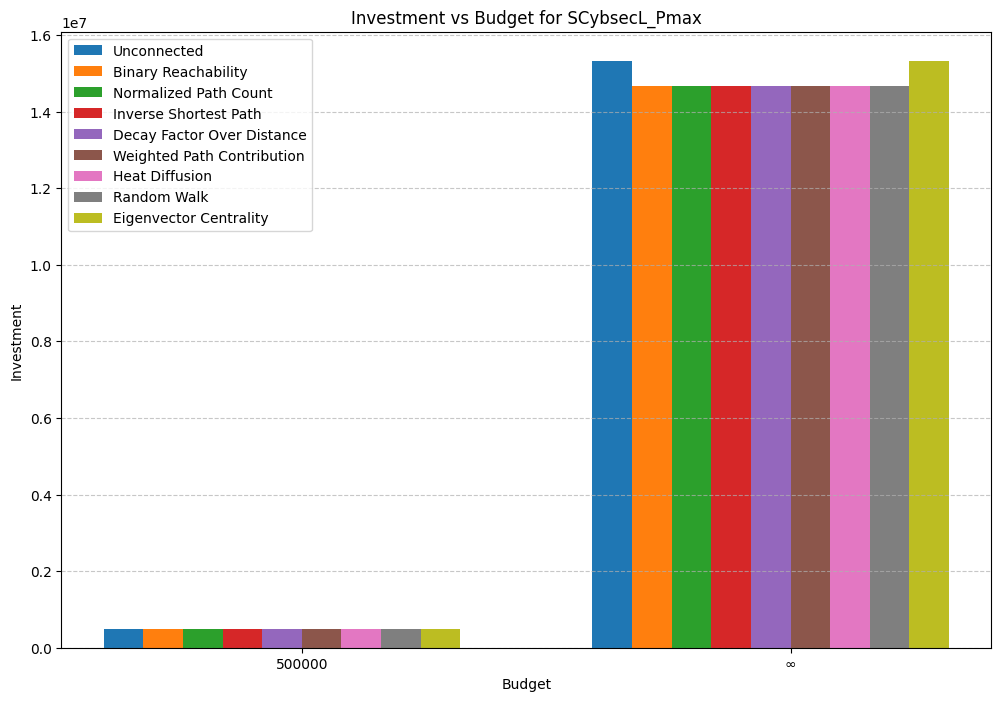

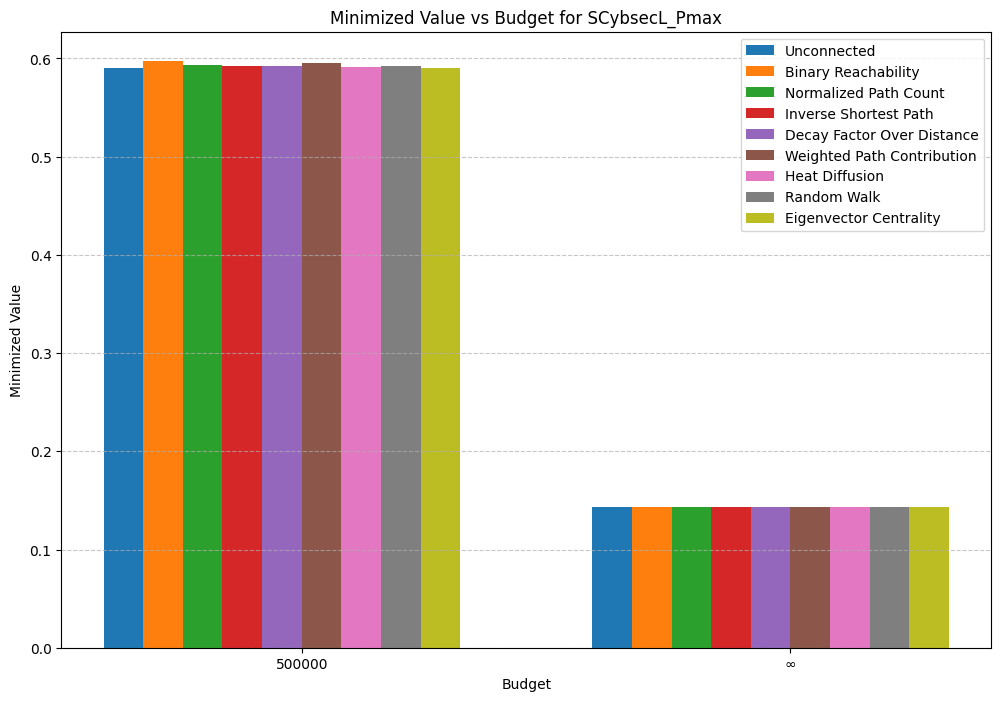

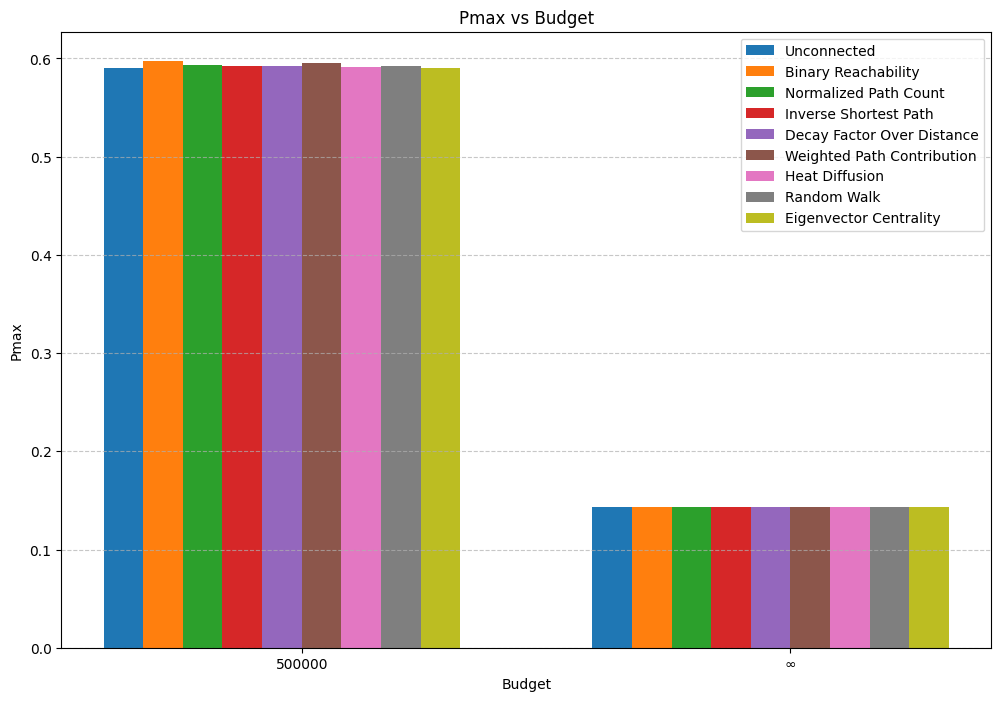


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [74]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_pmax", "SCybsecL_Pmax", "Pmax", "pmax")


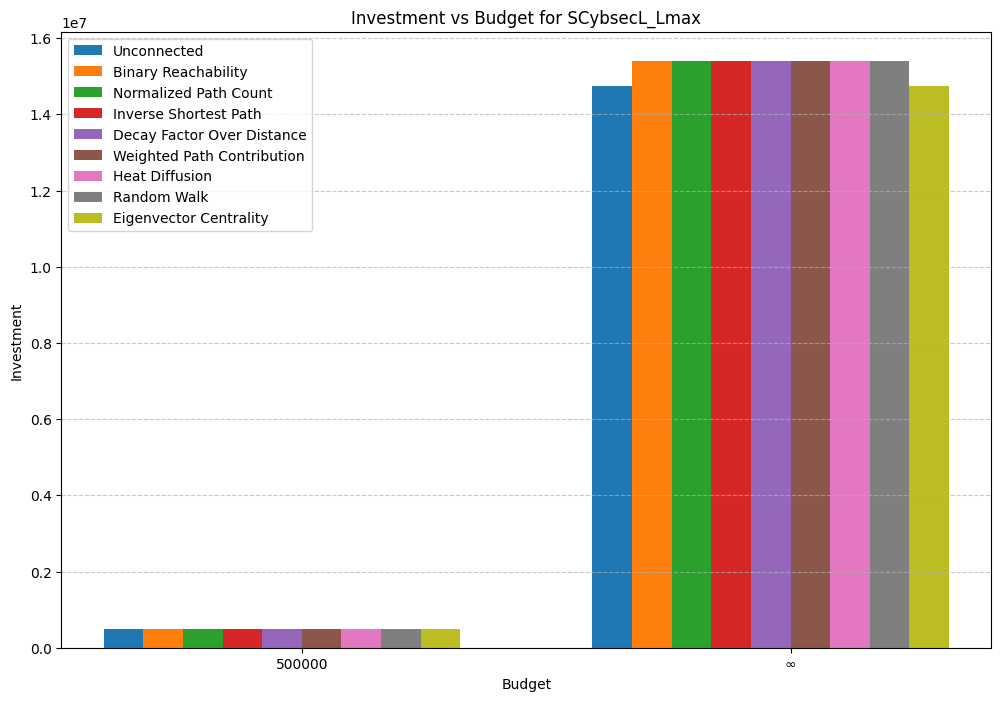

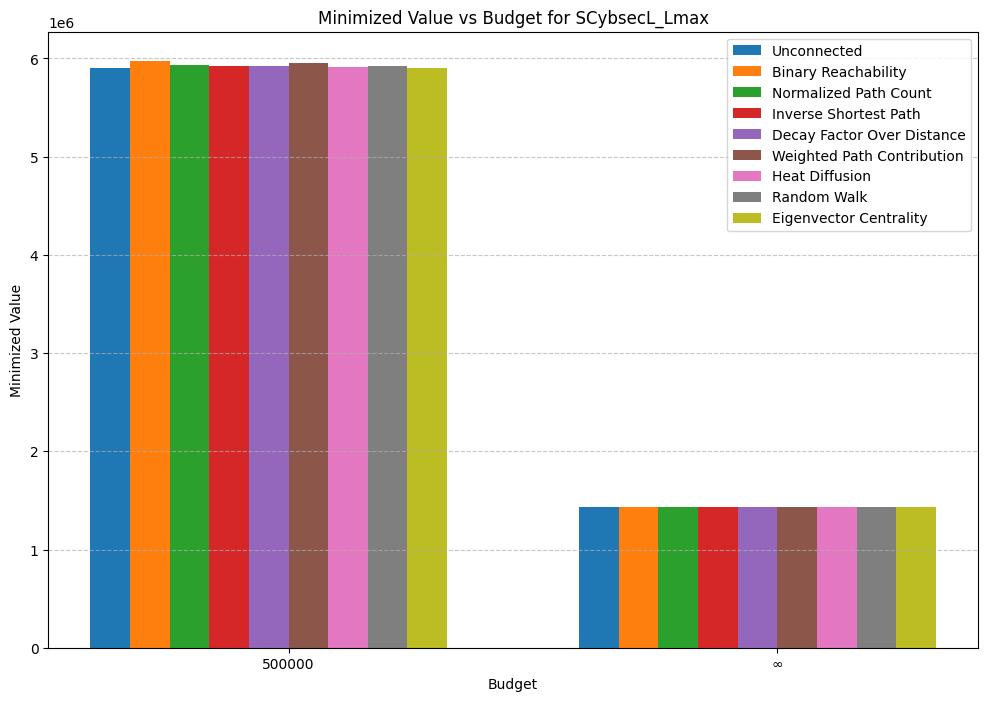

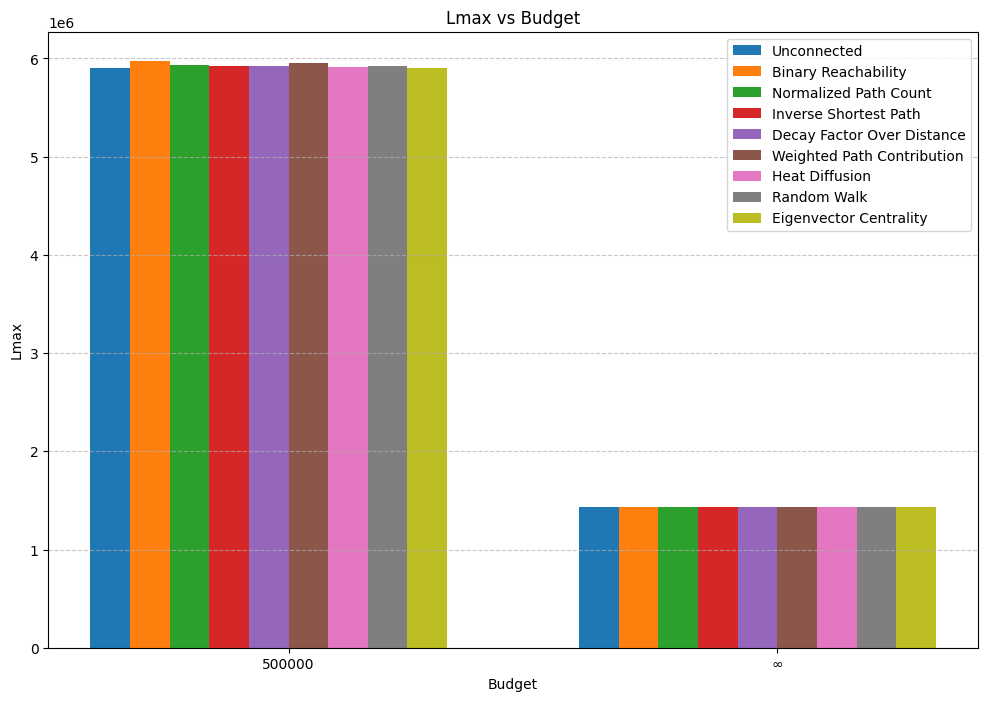


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [75]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_lmax", "SCybsecL_Lmax", "Lmax", "lmax")

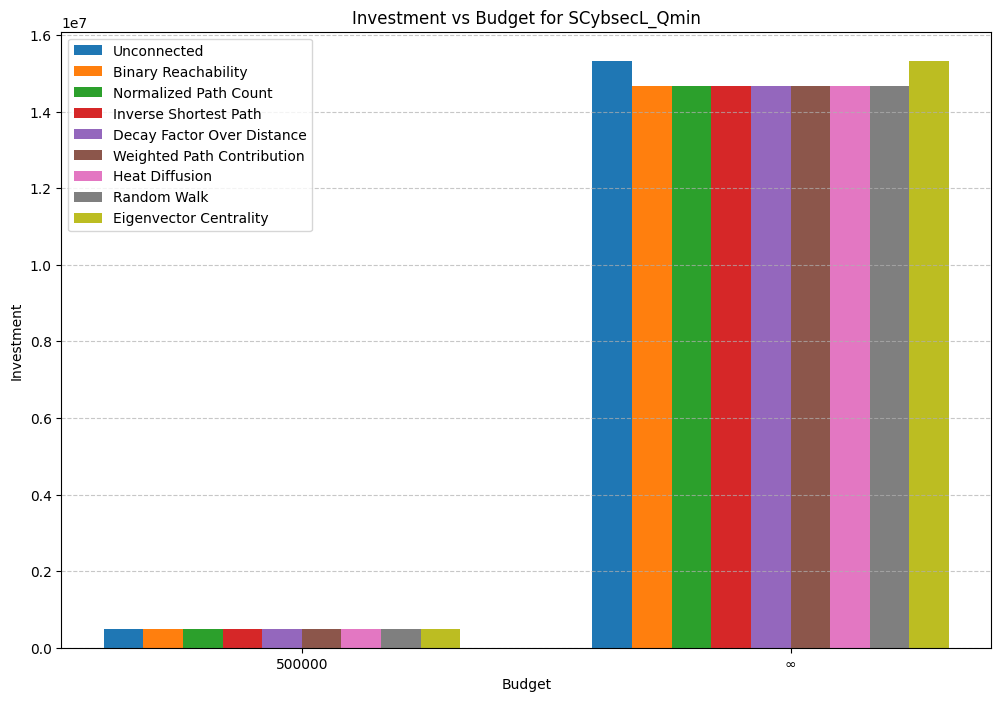

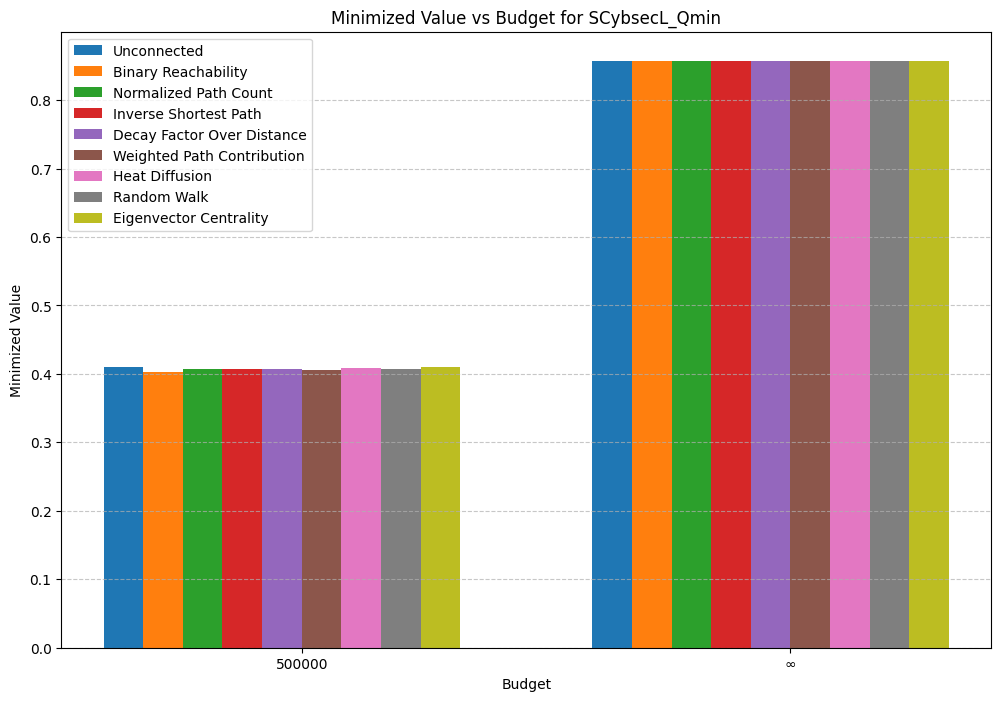

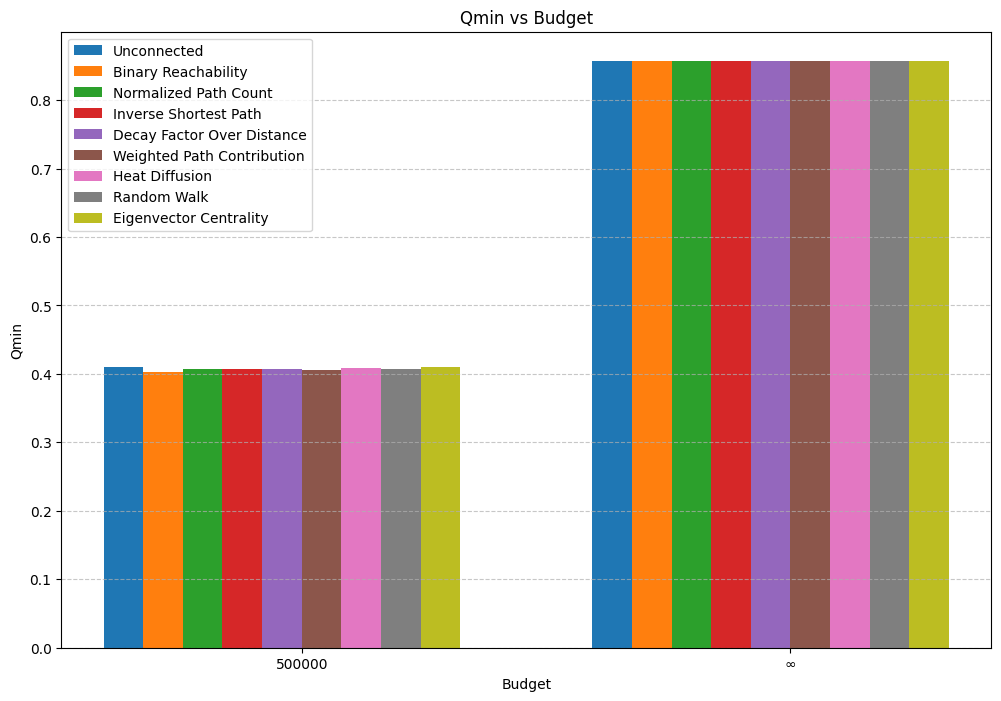


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [76]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_qmin", "SCybsecL_Qmin", "Qmin", "qmin")

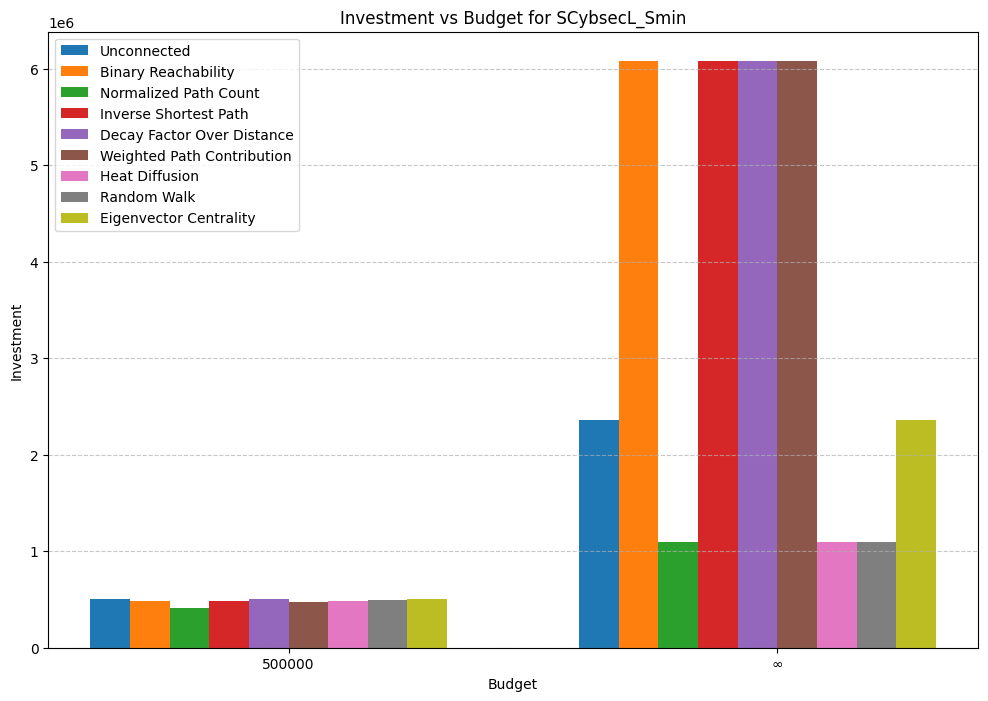

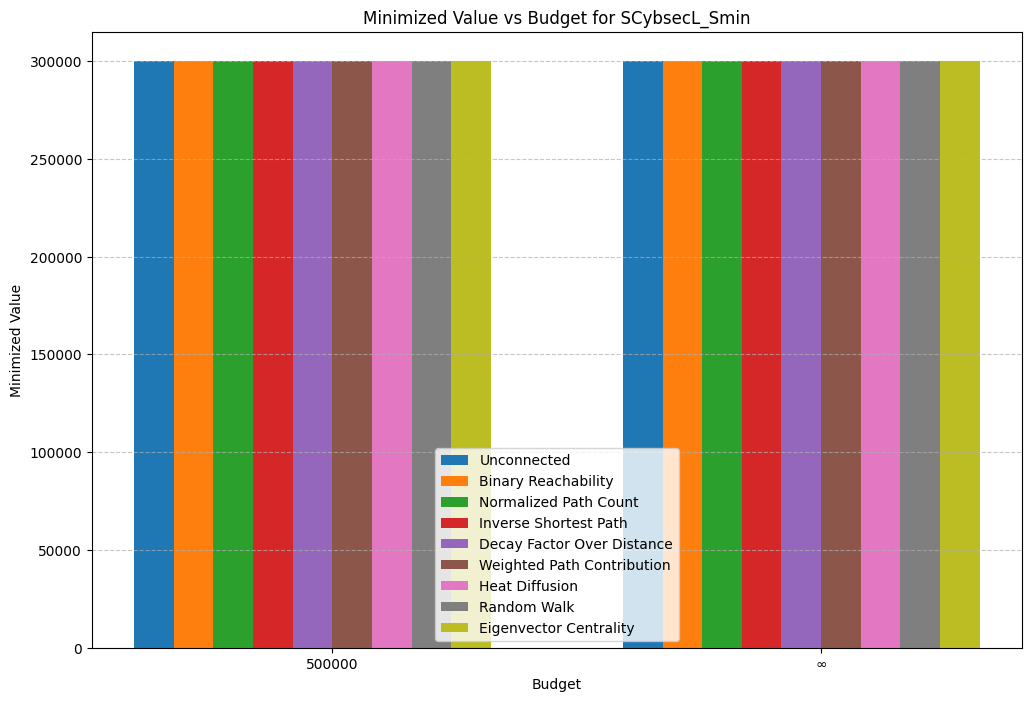

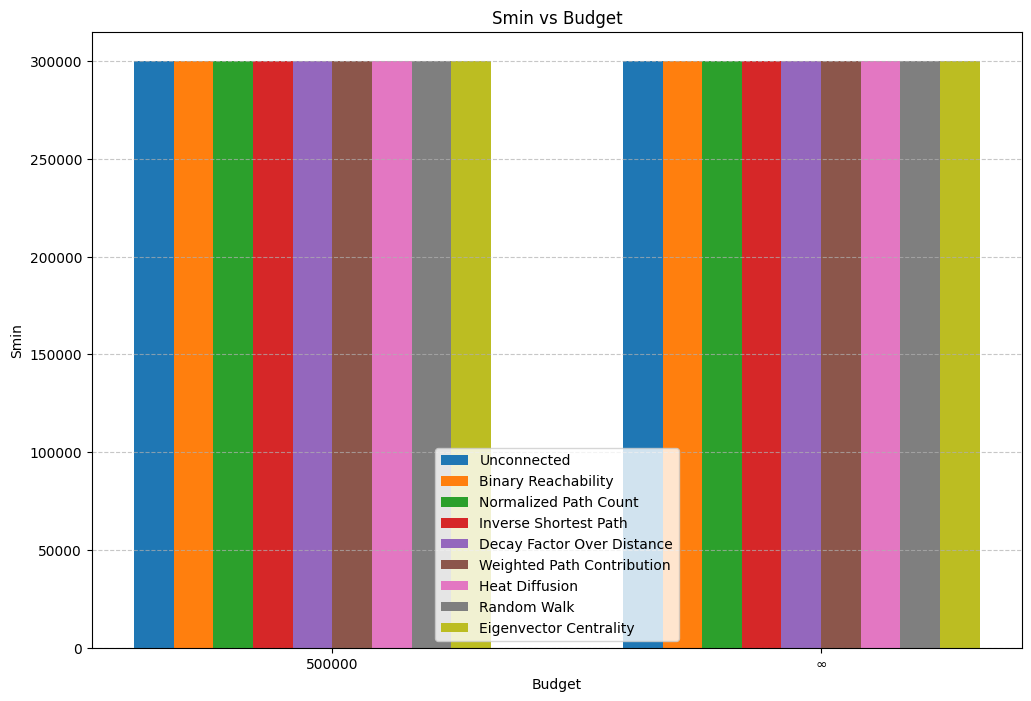


🔹 **Per-Node Values Table** 🔹
+----------------------------+----------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+----------+---------------+-----------------+---------------------+-----------+----------------+------------------+----------------------+
| Graph                      | Budget   |   W (N1) |   Invest (N1) |   Br. Prob (N1) |   Ex. Br. Prob (N1) |   W (N2) |   Invest (N2) |   Br. Prob (N2) |   Ex. Br. Prob (N2) |   W (N3) |   Invest (N3) |   Br. Prob (N3) |   Ex. Br. Prob (N3) |   W (N4) |

In [77]:
plot_results_scybsecl(g_options, g_option_names, budgets, results, "scybsecl_smin", "SCybsecL_Smin", "Smin", "smin")

# Cyberport_SLP

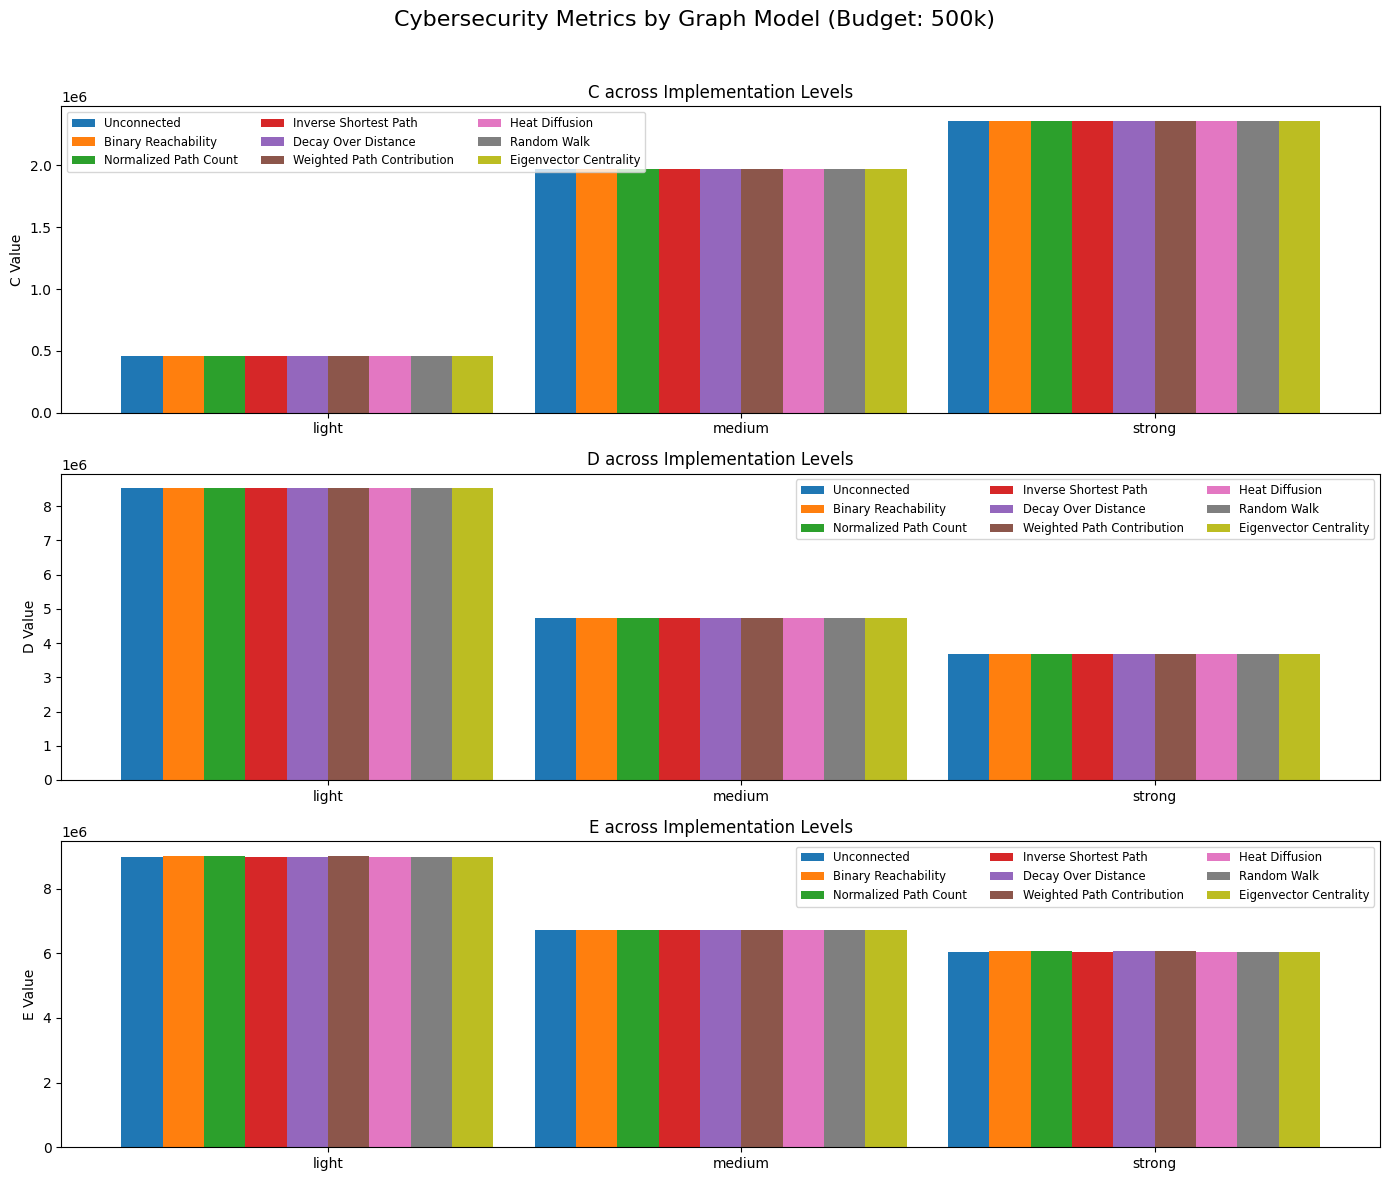

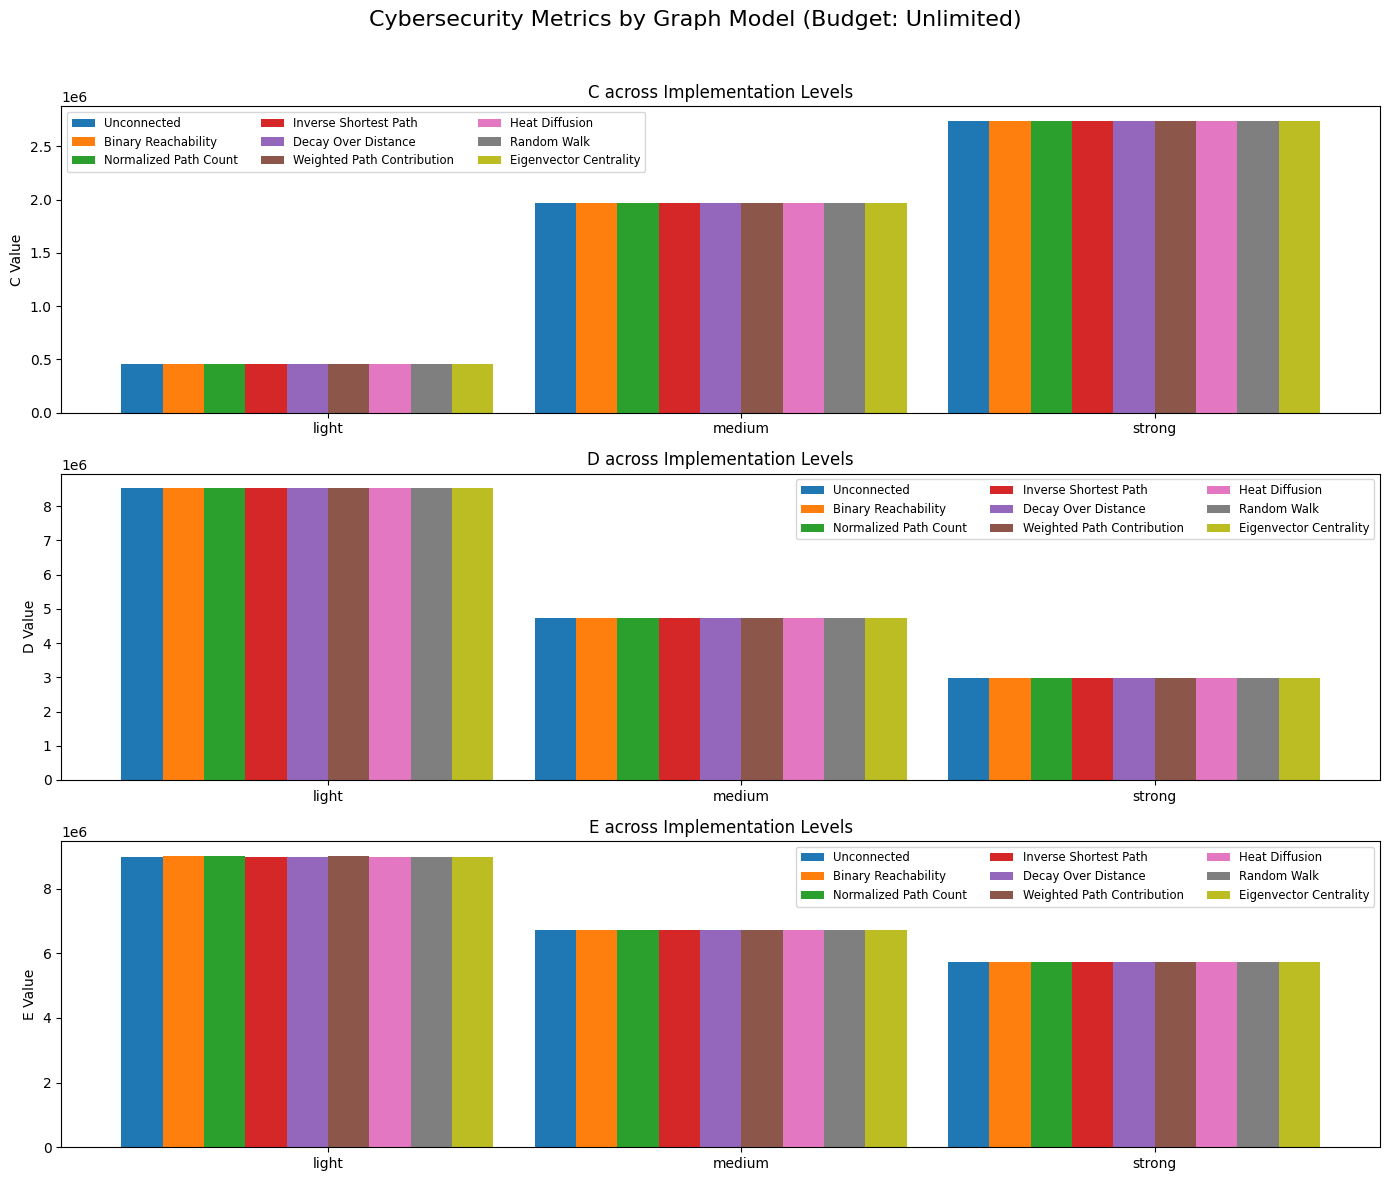

In [87]:
# === Cyberport SLP Optimization Function ===
def cyberport_slp(c, d, V, q, P, r, g):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    model = gp.Model("Cyberport_SLP_Minimize_Cost")
    model.setParam('OutputFlag', 0)  # Silence solver
    model.setParam('Threads', 12)

    u = model.addVars(num_controls, num_levels, vtype=GRB.BINARY, name="u")
    v = model.addVars(num_controls, num_components, num_levels, vtype=GRB.CONTINUOUS, lb=0, name="v")
    W = model.addVars(num_components, vtype=GRB.CONTINUOUS, lb=0, name="W")
    Z = model.addVars(num_components, vtype=GRB.CONTINUOUS, lb=0, name="Z")

    model.setObjective(
        gp.quicksum(c[j][l] * u[j, l] for j in range(num_controls) for l in range(num_levels)) +
        gp.quicksum(P[s] * d[k] * Z[k] for s in range(num_scenarios) for k in range(num_components)),
        GRB.MINIMIZE
    )

    for j in range(num_controls):
        model.addConstr(gp.quicksum(u[j, l] for l in range(num_levels)) == 1)

    for k in range(num_components):
        model.addConstr(gp.quicksum(v[0, k, l] for l in range(num_levels)) == V[k])

    for j in range(num_controls - 1):
        for k in range(num_components):
            model.addConstr(
                gp.quicksum(r[j][k][l] * v[j, k, l] for l in range(num_levels)) ==
                gp.quicksum(v[j + 1, k, l] for l in range(num_levels))
            )

    for k in range(num_components):
        model.addConstr(
            gp.quicksum(r[num_controls - 1][k][l] * v[num_controls - 1, k, l] for l in range(num_levels)) == W[k]
        )

    for j in range(num_controls):
        for k in range(num_components):
            for l in range(num_levels):
                model.addConstr(v[j, k, l] <= u[j, l])

    for i in range(num_components):
        propagated = gp.quicksum(g[h][i] * W[h] for h in range(num_components) if g[h][i] > 0)
        model.addConstr(Z[i] == propagated + W[i])

    model.optimize()

    if model.status != GRB.OPTIMAL:
        return None, None, None, None, None

    implemented_controls = []
    C = 0
    for j in range(num_controls):
        for l in range(num_levels):
            if u[j, l].X > 0.5:
                if l > 0:
                    implemented_controls.append(j + 1)
                    C += c[j][l]

    D = sum(P[s] * d[k] * W[k].X for s in range(num_scenarios) for k in range(num_components))
    E = model.ObjVal
    return C, D, E, 0, implemented_controls

# === Scenario and Probability Calculations ===
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}
    for s in range(num_scenarios):
        bits = [int(b) for b in f"{s:0{len(I)}b}"]
        Ps = np.prod([pi[i] if bits[i] else (1 - pi[i]) for i in range(len(I))])
        scenario_probabilities[s] = Ps
    return scenario_probabilities

# === Main Experiment Setup ===
I = list(range(1, 11))
J = list(range(1, 21))
K = list(range(1, 11))
S = list(range(1, 1025))

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]
cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
dk = [1000 * val for val in [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]]
P = calculate_scenario_probabilities(I, pi)
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [val * 1e-5 for val in q_temp]

# DAG structure
children = [[3], [3,4,5], [5], [6], [6,7], [7], [8,9], [8,9], [], []]
q1 = 1 / len(cj1)**2

# Generate propagation matrices
g_options = [
    [[0]*10 for _ in range(10)],  # Dummy placeholder if needed
    [[q1 * val for val in row] for row in binary_reachability(children).tolist()],
    [[q1 * val for val in row] for row in normalized_path_count(children).tolist()],
    [[q1 * val for val in row] for row in inverse_shortest_path(children).tolist()],
    [[q1 * val for val in row] for row in decay_factor_over_distance(children, lambda_=0.5).tolist()],
    [[q1 * val for val in row] for row in weighted_path_contribution(children).tolist()],
    [[q1 * val for val in row] for row in heat_diffusion_model(children).tolist()],
    [[q1 * val for val in row] for row in random_walk_influence(children, lambda_=0.85).tolist()],
    [[q1 * val for val in row] for row in eigenvector_centrality_influence(children).tolist()],
]

g_option_names = [
    "Unconnected", "Binary Reachability", "Normalized Path Count",
    "Inverse Shortest Path", "Decay Over Distance", "Weighted Path Contribution",
    "Heat Diffusion", "Random Walk", "Eigenvector Centrality"
]

budgets_temp = [500, float('inf')]
budgets = [val * 1000 if val != float('inf') else val for val in budgets_temp]
implementation_levels = ["light", "medium", "strong"]

# === Run Experiments ===
results = {}

for g_idx, g in enumerate(g_options):
    g_name = g_option_names[g_idx]
    results[g_name] = {}

    for budget in budgets:
        budget_label = f"{int(budget/1000)}k" if budget != float('inf') else "Unlimited"
        results[g_name][budget_label] = {"C": [], "D": [], "E": []}

        for level in implementation_levels:
            c = []
            multiplier = 1000 if level == "light" else 5*1000 if level == "medium" else 10*1000
            c = [[0, cj1[i] * multiplier] for i in range(len(cj1))]

            if budget != float('inf'):
                c = [[0, cost if cost <= budget else 1000000000] for [_, cost] in c]

            r = np.zeros((len(c), len(Vk), len(c[0])))
            for j in range(len(c)):
                for k in range(len(Vk)):
                    for l in range(len(c[j])):
                        r[j][k][l] = Vk[k] ** (q[j] * c[j][l])

            C, D, E, _, _ = cyberport_slp(c, dk, Vk, q, P, r, g)
            results[g_name][budget_label]["C"].append(C)
            results[g_name][budget_label]["D"].append(D)
            results[g_name][budget_label]["E"].append(E)

# === Plot Results ===
for budget_label in results[g_option_names[0]].keys():
    fig, axs = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f"Cybersecurity Metrics by Graph Model (Budget: {budget_label})", fontsize=16)
    x = np.arange(len(implementation_levels))
    width = 0.1

    for idx, metric in enumerate(["C", "D", "E"]):
        ax = axs[idx]
        for i, g_name in enumerate(g_option_names):
            values = results[g_name][budget_label][metric]
            ax.bar(x + i * width, values, width, label=g_name)
        ax.set_xticks(x + width * len(g_option_names) / 2)
        ax.set_xticklabels(implementation_levels)
        ax.set_ylabel(f"{metric} Value")
        ax.set_title(f"{metric} across Implementation Levels")
        ax.legend(fontsize='small', ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Cyberport_UBP

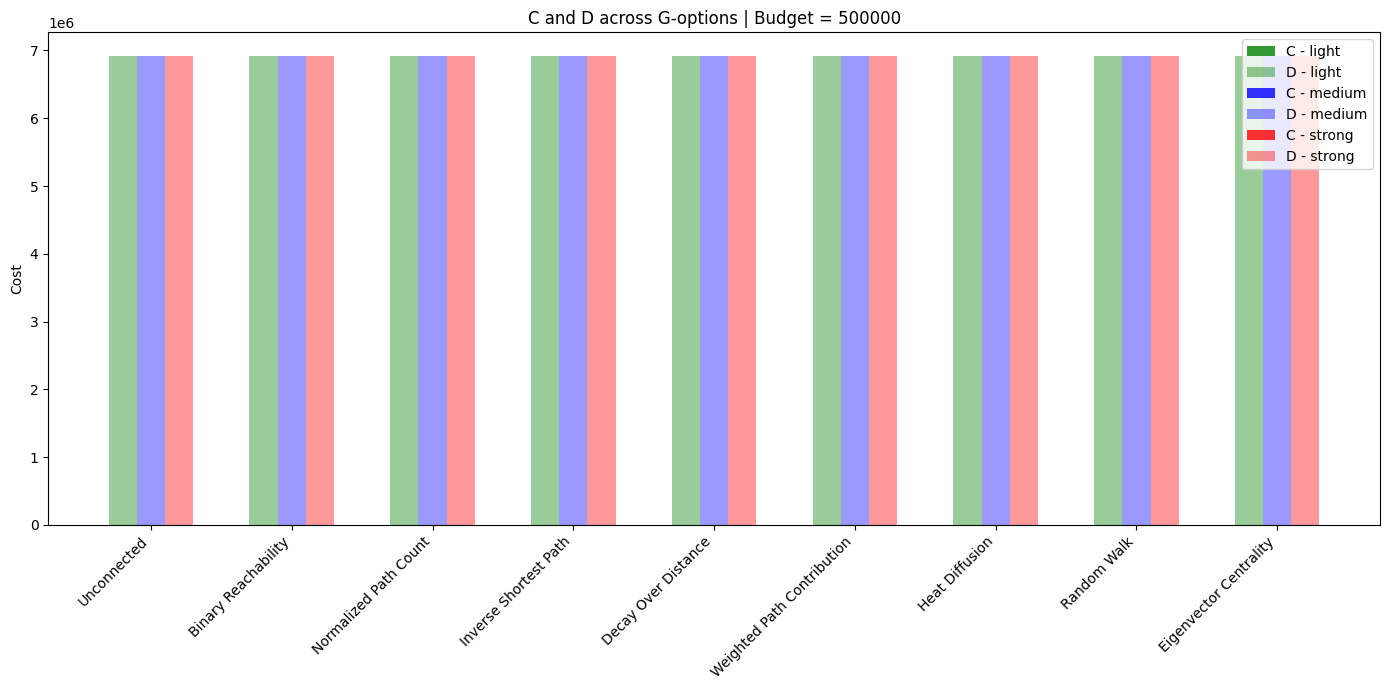

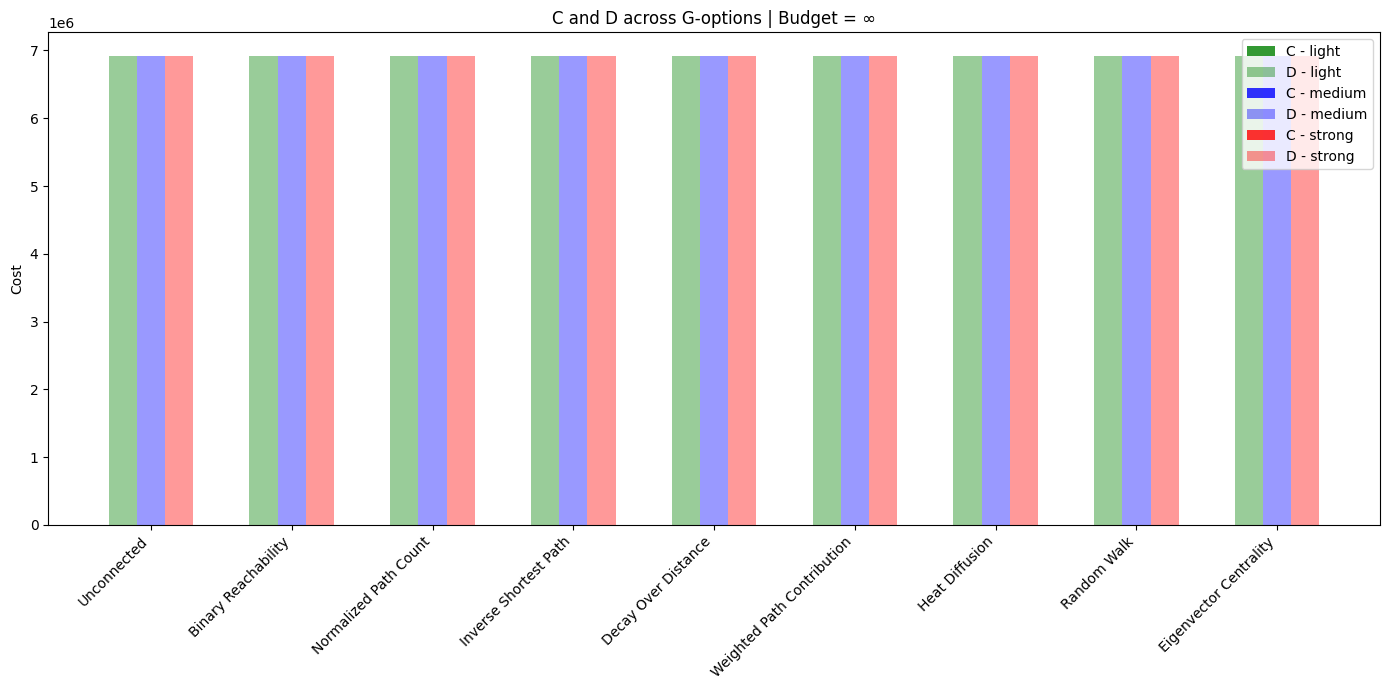


==== Budget: 500000 ====

╒════════════════════════════╤═══════════╤════════════╤════════════╤═══════════╤════════════╤════════════╤═══════════╤════════════╤════════════╕
│ G Option                   │   light C │   medium C │   strong C │   light D │   medium D │   strong D │   light E │   medium E │   strong E │
╞════════════════════════════╪═══════════╪════════════╪════════════╪═══════════╪════════════╪════════════╪═══════════╪════════════╪════════════╡
│ Unconnected                │         0 │          0 │          0 │   6921.72 │    6921.72 │    6920.94 │   6921.72 │    6921.72 │    6920.94 │
├────────────────────────────┼───────────┼────────────┼────────────┼───────────┼────────────┼────────────┼───────────┼────────────┼────────────┤
│ Binary Reachability        │         0 │          0 │          0 │   6921.72 │    6921.72 │    6920.94 │   6921.72 │    6921.72 │    6920.94 │
├────────────────────────────┼───────────┼────────────┼────────────┼───────────┼────────────┼──────────

In [94]:


def cyberport_ubp(c, d, V, q, h, pk):
    num_controls = len(c)
    num_components = len(V)

    model = Model("Cyberport_UBP")
    model.setParam("OutputFlag", 0)  # Suppress output
    model.setParam("Threads", 12)

    # Binary decision variables
    u = model.addVars(num_controls, vtype=GRB.BINARY, name="u")

    # Objective
    C = sum(c[j][1] * u[j] for j in range(num_controls))
    D = sum(pk[k] * d[k] * (1 - sum(q[j] * u[j] for j in range(num_controls))) for k in range(num_components))
    model.setObjective(C + D, GRB.MINIMIZE)

    model.optimize()

    implemented_controls = [j+1 for j in range(num_controls) if u[j].x > 0.5]
    C_value = sum(c[j][1] for j in range(num_controls) if u[j].x > 0.5)
    D_value = sum(pk[k] * d[k] * (1 - sum(q[j] * (u[j].x > 0.5) for j in range(num_controls))) for k in range(num_components))
    E_value = C_value + D_value

    return C_value, D_value, E_value, implemented_controls

def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}
    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        Ps = np.prod([pi[i] if Is[i] == 1 else (1 - pi[i]) for i in range(len(I))])
        scenario_probabilities[s] = Ps
    return scenario_probabilities

def calculate_h(P, d, r, V, c):
    num_controls = len(c)
    num_components = len(V)
    h = [0] * num_controls
    for j in range(num_controls):
        h[j] = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for s in P for k in range(num_components))
        h[j] *= 1e7
    return h

# Inputs
I = list(range(10))
J = list(range(20))
K = list(range(10))

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 0.697596, 0.992109, 0.977199, 0.993963]
cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk = [1000 * value for value in [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]]
q = [val * 1e-5 for val in [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247,
                            6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]]
P = calculate_scenario_probabilities(I, pi)

implementation_levels = ["light", "medium", "strong"]
budget_options = [500000, float('inf')]
g_options = [
    [[0]*10 for _ in range(10)],  # Dummy placeholder if needed
    [[q1 * val for val in row] for row in binary_reachability(children).tolist()],
    [[q1 * val for val in row] for row in normalized_path_count(children).tolist()],
    [[q1 * val for val in row] for row in inverse_shortest_path(children).tolist()],
    [[q1 * val for val in row] for row in decay_factor_over_distance(children, lambda_=0.5).tolist()],
    [[q1 * val for val in row] for row in weighted_path_contribution(children).tolist()],
    [[q1 * val for val in row] for row in heat_diffusion_model(children).tolist()],
    [[q1 * val for val in row] for row in random_walk_influence(children, lambda_=0.85).tolist()],
    [[q1 * val for val in row] for row in eigenvector_centrality_influence(children).tolist()],
]

g_option_names = [
    "Unconnected", "Binary Reachability", "Normalized Path Count",
    "Inverse Shortest Path", "Decay Over Distance", "Weighted Path Contribution",
    "Heat Diffusion", "Random Walk", "Eigenvector Centrality"
]

results = {}

for g_idx, g in enumerate(g_options):
    gname = g_option_names[g_idx]
    results[gname] = {}

    for budget in budget_options:
        results[gname][budget] = {"C": [], "D": [], "E": []}

        for level in implementation_levels:
            # Adjust cost based on implementation level
            factor = 1000 if level == "light" else 5000 if level == "medium" else 10000
            c = [[0, cj1[i] * factor] for i in range(len(cj1))]

            # Apply budget constraint
            if budget != float('inf'):
                for i in range(len(c)):
                    if c[i][1] > budget:
                        c[i][1] = 0

            # Build r matrix based on g_option
            r = np.zeros((len(c), len(Vk), 2))
            for j in range(len(c)):
                for k in range(len(Vk)):
                    r[j][k][1] = Vk[k] ** (q[j] * c[j][1]) if isinstance(g, list) else 0

            h = calculate_h(P, dk, r, Vk, c)
            C, D, E, controls = cyberport_ubp(c, dk, Vk, q, h, pk)

            results[gname][budget]["C"].append(C)
            results[gname][budget]["D"].append(D)
            results[gname][budget]["E"].append(E)

# ---- Plotting ----


colors = {
    "light": "green",
    "medium": "blue",
    "strong": "red"
}

for budget in budget_options:
    fig, ax = plt.subplots(figsize=(14, 7))
    x = np.arange(len(g_option_names))
    width = 0.2

    C_vals = [results[g][budget]["C"] for g in g_option_names]
    D_vals = [results[g][budget]["D"] for g in g_option_names]
    E_vals = [results[g][budget]["E"] for g in g_option_names]

    # Convert to arrays for easier slicing
    C_vals = np.array(C_vals)
    D_vals = np.array(D_vals)
    E_vals = np.array(E_vals)

    # Plot for each implementation level
    for idx, level in enumerate(implementation_levels):
        offset = (idx - 1) * width
        ax.bar(x + offset, C_vals[:, idx], width, label=f'C - {level}', alpha=0.8, color=colors[level])
        ax.bar(x + offset, D_vals[:, idx], width, bottom=C_vals[:, idx], label=f'D - {level}', alpha=0.4, color=colors[level])

    ax.set_xticks(x)
    ax.set_xticklabels(g_option_names, rotation=45, ha='right')
    ax.set_ylabel('Cost')
    ax.set_title(f'C and D across G-options | Budget = {"∞" if budget == float("inf") else budget}')
    ax.legend()
    plt.tight_layout()
    plt.show()

def generate_result_table(results, budget):
    headers = ["G Option"] + [f"{level} C" for level in implementation_levels] + \
              [f"{level} D" for level in implementation_levels] + \
              [f"{level} E" for level in implementation_levels]

    table_data = []

    for g_name in g_option_names:
        row = [g_name]
        for level in implementation_levels:
            row.append(round(results[g_name][budget]["C"][implementation_levels.index(level)] / 1000, 2))
        for level in implementation_levels:
            row.append(round(results[g_name][budget]["D"][implementation_levels.index(level)] / 1000, 2))
        for level in implementation_levels:
            row.append(round(results[g_name][budget]["E"][implementation_levels.index(level)] / 1000, 2))
        table_data.append(row)

    table = tabulate(table_data, headers=headers, tablefmt="fancy_grid")
    return table

# Example usage:
for budget in budget_options:
    print(f"\n==== Budget: {'∞' if budget == float('inf') else budget} ====\n")
    print(generate_result_table(results, budget))

